In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('jet')

In [2]:
# case_name = '9w_ms_bhp_rate'
case_name = '7w_cha'

# sim_case_name = 'case8_9w_bhp_rate_ms_gau'
sim_case_name = 'case9_cha'


# data_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_bhp_rate_fix_wl/'
# data_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_ms_bhp_rate_fix_wl/'
data_dir = '/data3/Astro/lstm_rom/e2c_larry/data/' + case_name + '/'

target_suffix = '_fix_wl_rel_1' # the dataset being evaluated here
train_suffix = '_with_p'

model_suffix = '_flux_loss'
# model_suffix = '_no_fl'
# model_suffix = '_ae_with_l2'

num_t = 20
run_eval = 100
num_eval = num_t * run_eval
# dt = 200 // num_t
dt = 100 # days

nt = 6000 # the older than 7 relization does not have this. Study impact of nt on rel_7

In [3]:
# well_loc_file = '/data/cees/zjin/lstm_rom/sim_runs/case6_9w_bhp_rate_ms_h5/template/well_loc00.dat'
# well_loc_file = '/data3/Astro/personal/zjin/sim_runs/case8_9w_bhp_rate_ms_gau/template/well_loc00.dat'
well_loc_file = '/data3/Astro/personal/zjin/sim_runs/' + sim_case_name + '/template/well_loc00.dat'

In [4]:
# hf_r = h5py.File(data_dir + case_name + target_suffix + '_state_seq_pred_ctrl.mat', 'r')
# hf_r = h5py.File(data_dir + case_name + target_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(nt), 'r')
hf_r = h5py.File(data_dir + case_name + target_suffix + model_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(nt), 'r')
state_true = np.array(hf_r.get('true_seq'))
state_pred = np.array(hf_r.get('pred_seq'))
state_train = np.array(hf_r.get('train_seq'))
ctrl = np.array(np.array(hf_r.get('ctrl_seq')))
train_ctrl = np.array(hf_r.get('train_ctrl'))
eval_ctrl = np.array(hf_r.get('eval_ctrl'))
hf_r.close()

In [5]:
print(ctrl.shape)
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(train_ctrl.shape)
print(eval_ctrl.shape)

(100, 20, 14)
(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(300, 140)
(100, 140)


In [6]:
well_loc = np.loadtxt(well_loc_file).astype(int)
num_prod = well_loc[0,0]
num_inj = well_loc[0,1]
num_well = num_prod+num_inj
print(num_inj, num_prod)

3 4


In [7]:
prod_loc = well_loc[1:num_prod+1,:]
print("prod_loc:\n{}".format(prod_loc))
inj_loc = well_loc[num_prod+1:,:]
print("inj_loc:\n{}".format(inj_loc))

prod_loc:
[[11 10]
 [14 50]
 [40 30]
 [55 20]]
inj_loc:
[[10 21]
 [51 40]
 [19 40]]


## Find closest training

In [8]:
# ind_case = np.array(range(0, 100, 25)) + 10
# ind_case = np.array([10, 25, 77, 97])
ind_case = np.array([10, 15, 17, 74])
print(ind_case)

[10 15 17 74]


In [9]:
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(ctrl.shape)
print(train_ctrl.shape)
print(eval_ctrl.shape)

num_train = state_train.shape[0]
num_eval = state_true.shape[0]
print("num_train:{}".format(num_train))
print("num_eval:{}".format(num_eval))

(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(100, 20, 14)
(300, 140)
(100, 140)
num_train:300
num_eval:100


In [10]:
ctrl_dist = np.zeros((num_eval, num_train))
for i in range(num_eval):
    ctrl_dist[i,:] = np.linalg.norm(eval_ctrl[i,:] - train_ctrl, axis=1, ord=1)
print(ctrl_dist.shape)

(100, 300)


In [11]:
close_train = np.argmax(ctrl_dist, axis=1)
print(close_train.shape)

(100,)


In [12]:
min_ctrl_dist = np.zeros((num_eval))
for i in range(num_eval):
    min_ctrl_dist[i] = ctrl_dist[i, close_train[i]]
print(min_ctrl_dist.shape)

(100,)


In [13]:
# plt.figure()
# plt.plot(train_ctrl[])

## Plot producer block pressure

In [14]:
num_case = len(ind_case)
num_step = state_true.shape[1]
print("num_case:%d"%(num_case))
print("num_step:%d"%(num_step))

num_case:4
num_step:20


In [15]:
print(prod_loc.shape)

(4, 2)


In [16]:
p_max = 425*14.5038
p_min = 250*14.5038

p_diff = p_max - p_min
p_mid = 0.75*p_diff + p_min
print(p_mid)

5529.57375


In [17]:
state_pred[:, :, :, :, 1] = state_pred[:, :, :, :, 1] * p_diff + p_min
state_true[:, :, :, 1] = state_true[:, :, :, 1] * p_diff + p_min
state_train[:, :, :, 1] = state_train[:, :, :, 1] * p_diff + p_min

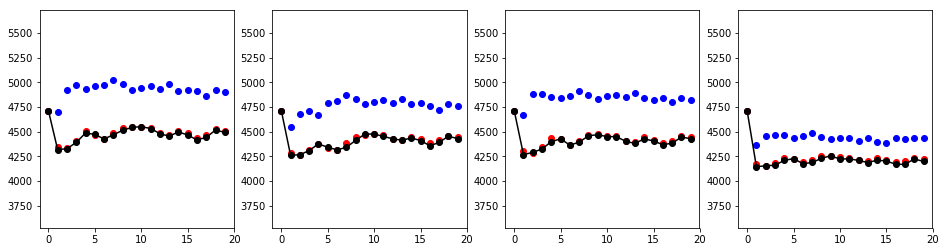

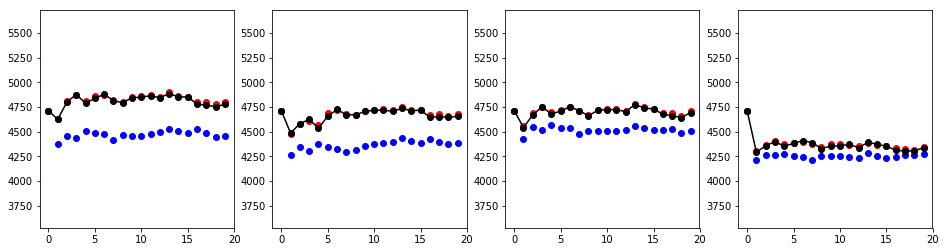

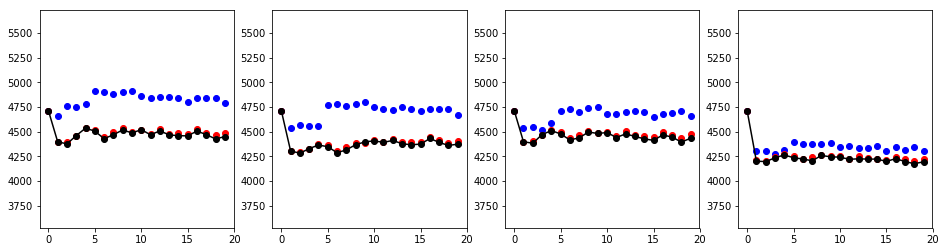

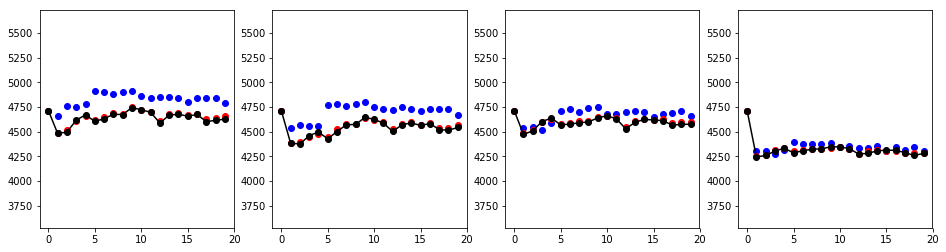

In [18]:
for k in range(num_case):
    plt.figure(k, figsize=(16,4))
    for i in range(num_prod):
        plt.subplot(1, num_prod, i+1)
        pres_true = state_true[ind_case[k], :, :, 1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_pred = state_pred[ind_case[k], :, :, :, 1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_train = state_train[close_train[ind_case[k]], :, :, 1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        plt.plot(pres_train,'bo')
        plt.plot(pres_pred,'ro')
        plt.plot(pres_true,'ko-')
        plt.ylim([p_min-100, p_mid+200])
#         plt.title("P%d,diff=%.3f"%(i+1, np.linalg.norm(pres_pred - pres_true)))
plt.show()
        

## Plot Producer block saturation

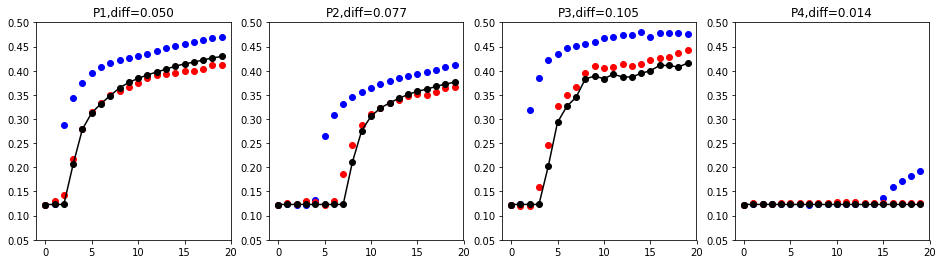

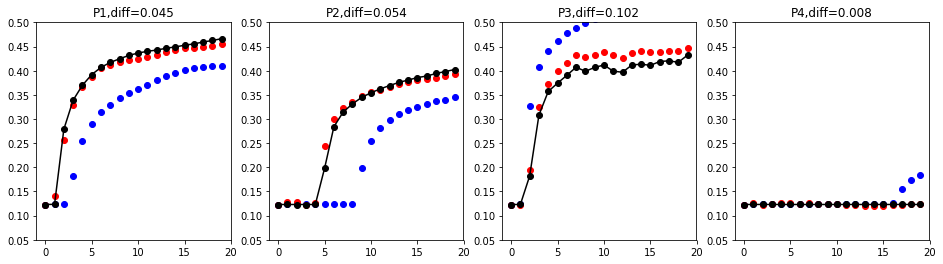

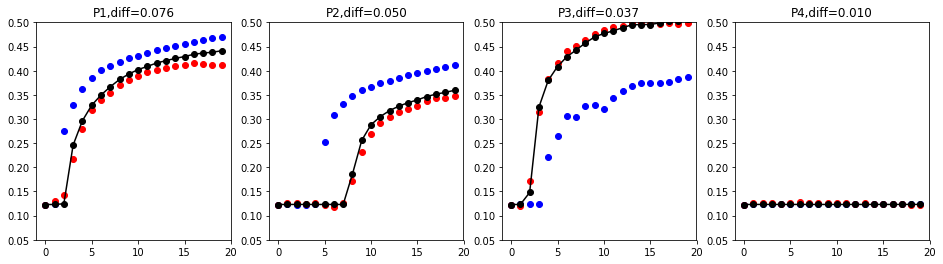

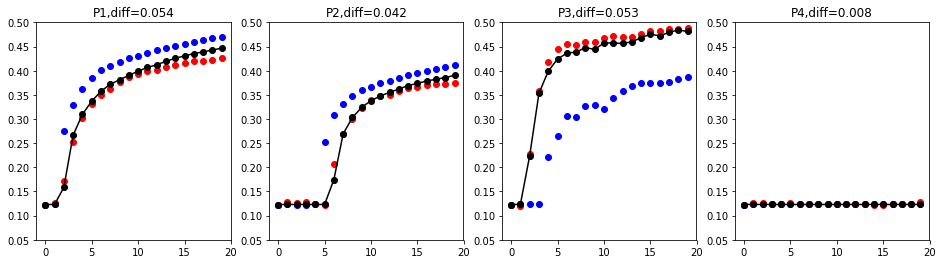

In [19]:
for k in range(num_case):
    im = plt.figure(k, figsize=(16,4))
    for i in range(num_prod):
        plt.subplot(1, num_prod, i+1)
#         print(prod_loc[i,1], prod_loc[i,0])
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        plt.plot(sat_train,'bo')
        plt.plot(sat_pred,'ro')
        plt.plot(sat_true,'ko-')
        plt.ylim([0.05, 0.5])
        plt.title('P%d,diff=%.3f'%(i+1, np.linalg.norm(sat_true - sat_pred)))
plt.show()
        

## Plot injector saturation

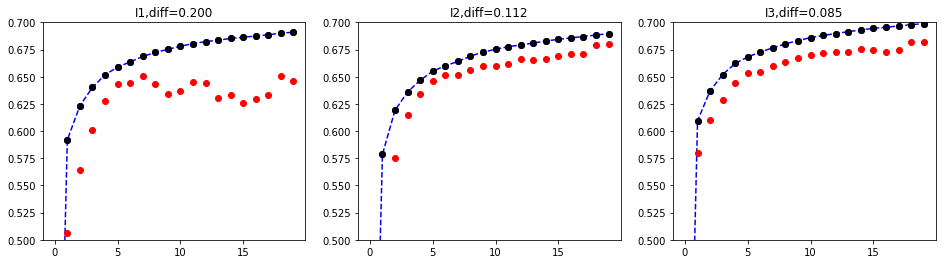

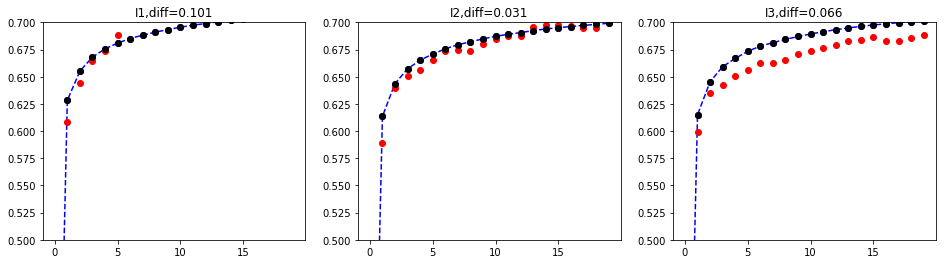

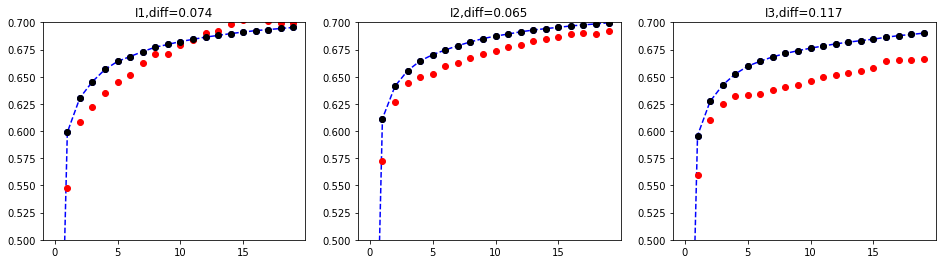

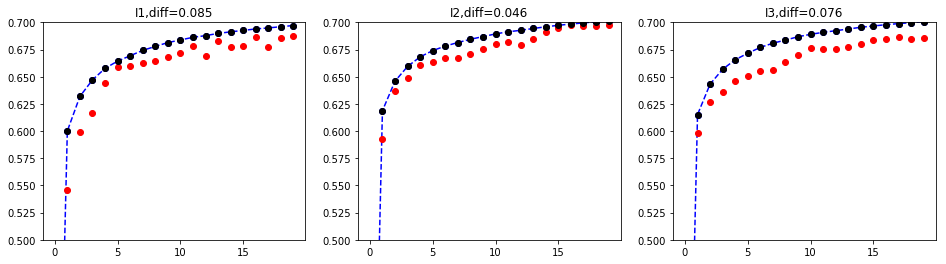

In [20]:
for k in range(num_case):
    im = plt.figure(k, figsize=(16,4))
    for i in range(num_inj):
        plt.subplot(1, num_inj, i+1)
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        plt.plot(sat_true,'bo--')
        plt.plot(sat_pred,'ro')
        plt.plot(sat_true,'ko')
        plt.ylim([0.5, 0.7])
        plt.title('I%d,diff=%.3f'%(i+1, np.linalg.norm(sat_true - sat_pred)))
plt.show()
        

## Plot Production Rates

In [21]:
# import sys
# sys.path.append('/data3/Astro/global/python/')
from cal_well_data import cal_prod_rate, cal_inj_bhp

In [22]:
# logk_file = '/data/cees/zjin/lstm_rom/sim_runs/case4_9w_bhp_rate/template/logk1.dat'
# logk_file = '/data3/Astro/personal/zjin/sim_runs/case8_9w_bhp_rate_ms_gau/template/logk1.dat'
logk_file = '/data3/Astro/personal/zjin/sim_runs/' + sim_case_name + '/template/logk1.dat'

logk = np.loadtxt(logk_file)
# logk = logk.reshape((60,60)).T

In [23]:
# this shold be correct
# i: index on x-axis
# j: index on y-axis
def get_logk(logk, i, j):
    nx = 60
    ny = 60
    return logk[j*nx + i] -3.5

In [24]:
ctrl.shape

(100, 20, 14)

In [25]:
p_max = 425*14.5038
p_min = 250*14.5038
p_diff = p_max - p_min

q_max = 6500
q_min = 1500
q_diff = q_max - q_min

In [26]:
t_steps = np.arange(0,200,10)

## Plot oil/water production rates

Evaluation Case 1


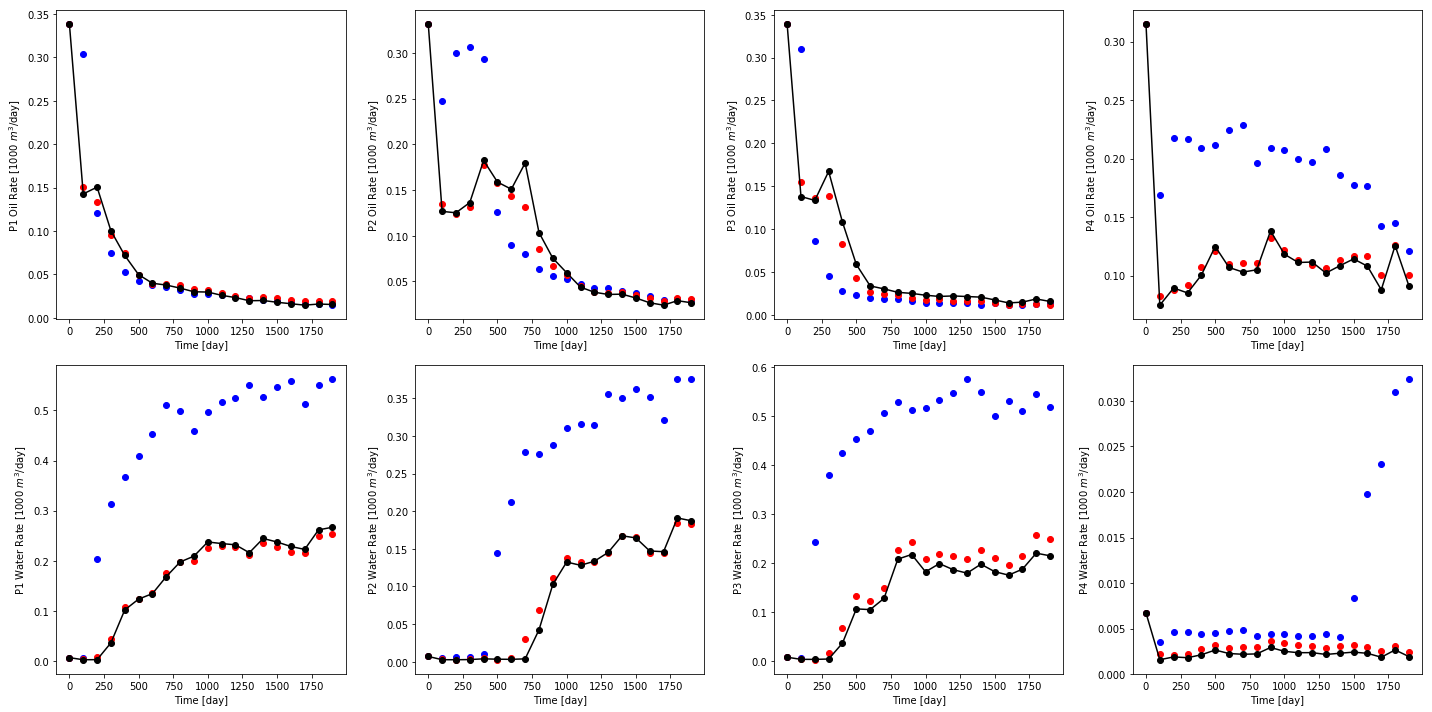

Evaluation Case 2


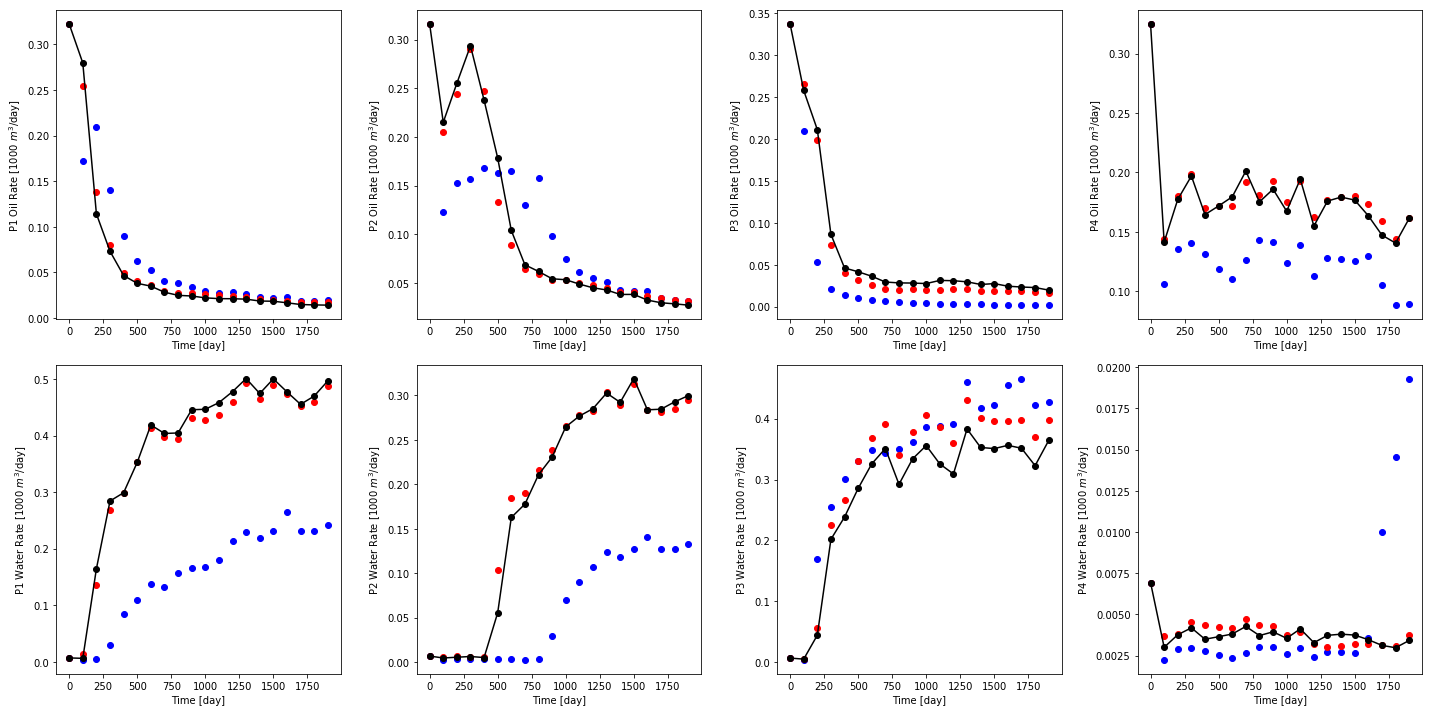

Evaluation Case 3


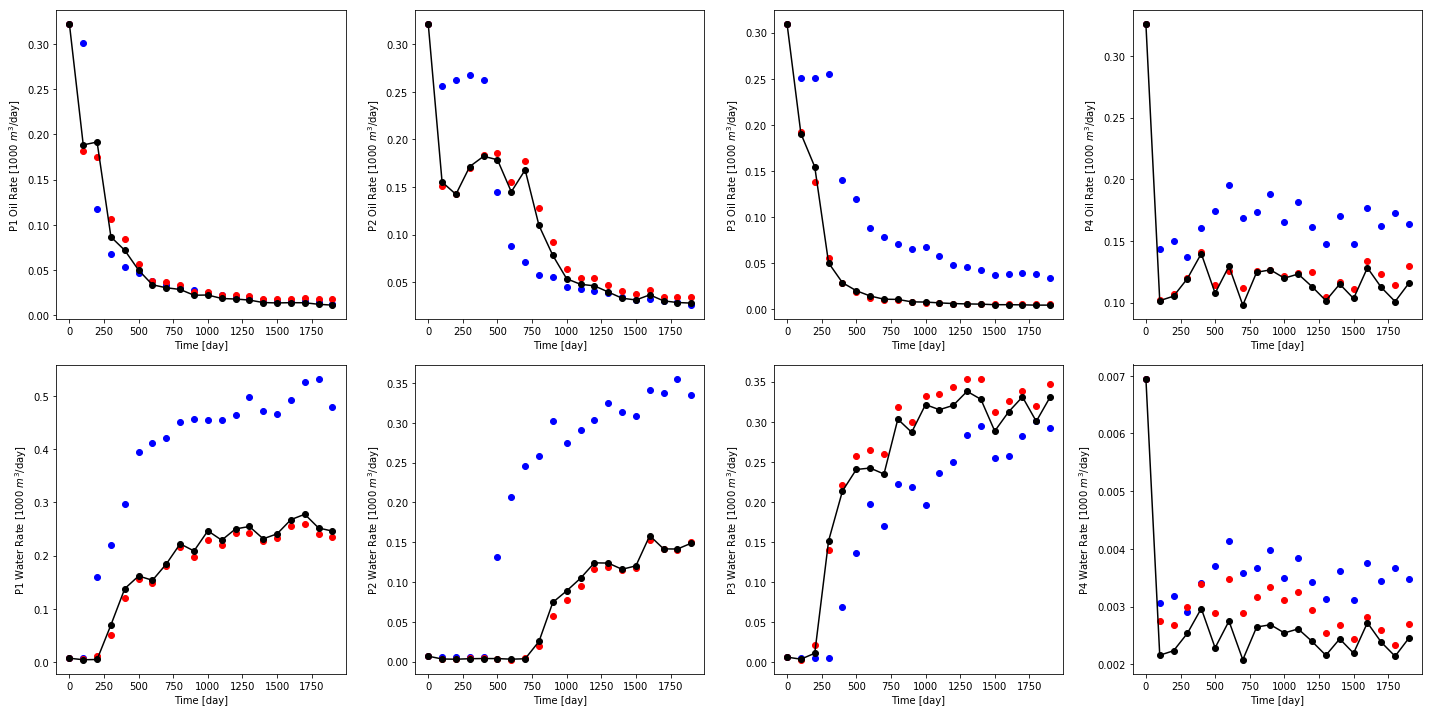

Evaluation Case 4


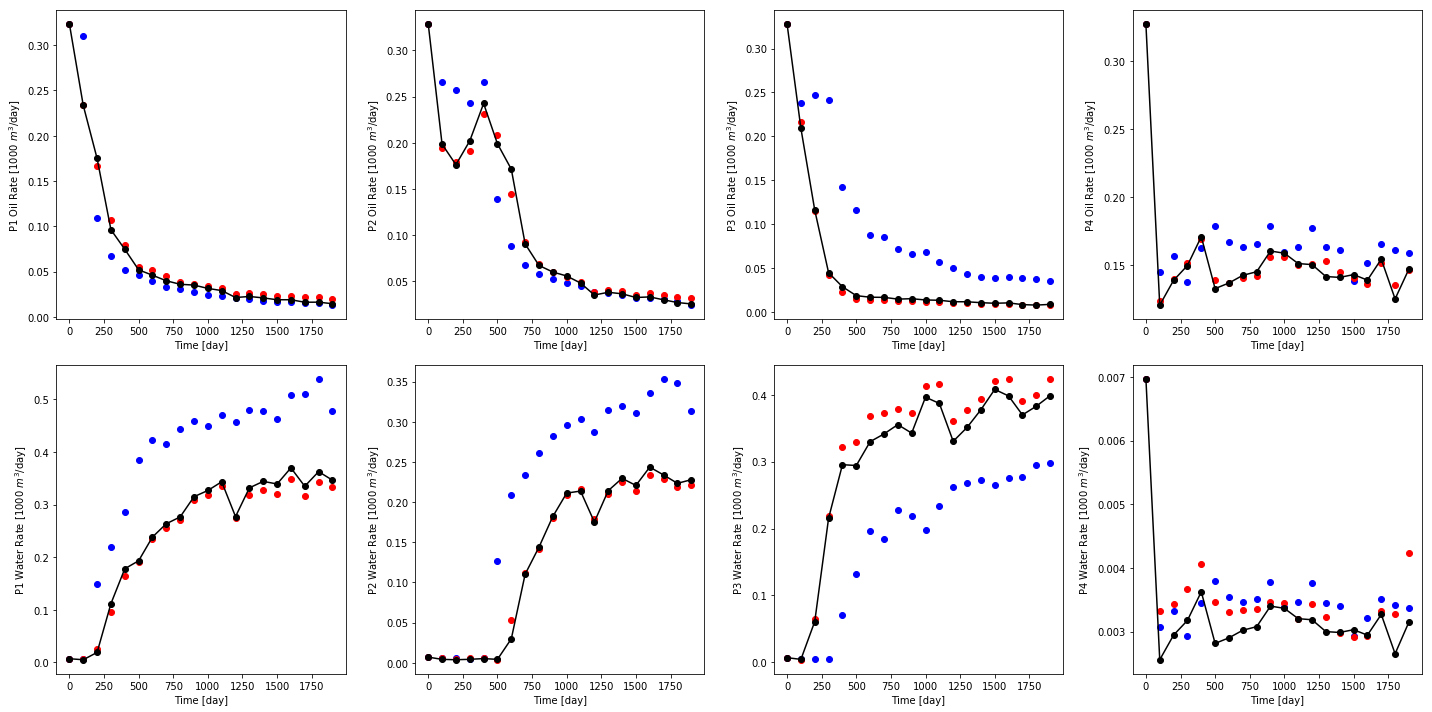

In [27]:
for k in range(num_case):
    print('Evaluation Case %d' % (k+1))
    plt.figure(k, figsize=(20,10))
    for i in range(num_prod):
        prodx = prod_loc[i, 0]
        prody = prod_loc[i, 1]
        perm = np.exp(get_logk(logk, prodx, prody))
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        pres_true = state_true[ind_case[k], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_pred = state_pred[ind_case[k], :, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_train = state_train[close_train[ind_case[k]], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        bhp = ctrl[ind_case[k], :, i+num_well] * p_diff + p_min
        
        wrat_true = np.zeros_like(bhp)
        wrat_pred = np.zeros_like(bhp)
        orat_true = np.zeros_like(bhp)
        orat_pred = np.zeros_like(bhp)
        wrat_train = np.zeros_like(bhp)
        orat_train = np.zeros_like(bhp)
        
        for j in range(len(bhp)):
            wrat_true[j], orat_true[j] = cal_prod_rate(pres_true[[j]], sat_true[[j]], bhp[j], perm)
            wrat_pred[j], orat_pred[j] = cal_prod_rate(pres_pred[[j]], sat_pred[[j]], bhp[j], perm)
            wrat_train[j], orat_train[j] = cal_prod_rate(pres_train[[j]], sat_train[[j]], bhp[j], perm)
        
        bbl2m3 = 6.2898 * 1000
        
        plt.subplot(2, num_prod, i+1)
        plt.plot(t_steps*10, orat_train/bbl2m3, 'bo')
        plt.plot(t_steps*10, orat_pred/bbl2m3, 'ro')
        plt.plot(t_steps*10, orat_true/bbl2m3, 'ko-')
        plt.xlabel('Time [day]')
        plt.ylabel(r'P%d Oil Rate [1000 $m^{3}$/day]' % (i+1))
        
        plt.subplot(2, num_prod, i+num_prod+1)
        plt.plot(t_steps*10, wrat_train/bbl2m3, 'bo')
        plt.plot(t_steps*10, wrat_pred/bbl2m3, 'ro')
        plt.plot(t_steps*10, wrat_true/bbl2m3, 'ko-')
        plt.xlabel('Time [day]')
        plt.ylabel(r'P%d Water Rate [1000 $m^{3}$/day]' % (i+1))
    plt.tight_layout()
    plt.show()
        
        

## Plot injection BHP

In [28]:
# check injection block perm
for k in range(1):
    for i in range(num_inj):
        injx = inj_loc[i, 0]
        injy = inj_loc[i, 1]
        print(injx, injy, get_logk(logk, injx, injy))

10 21 5.6782
51 40 3.7234999999999996
19 40 4.3529


Evaluation Case 1


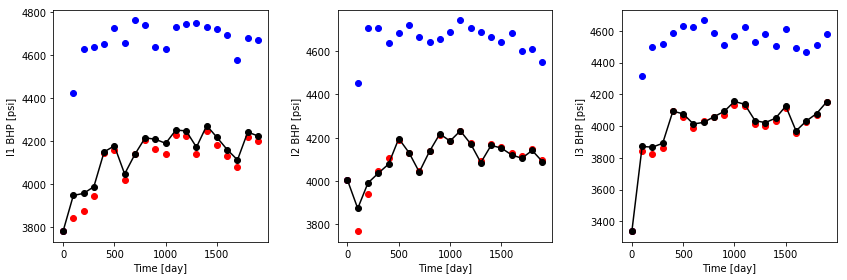

Evaluation Case 2


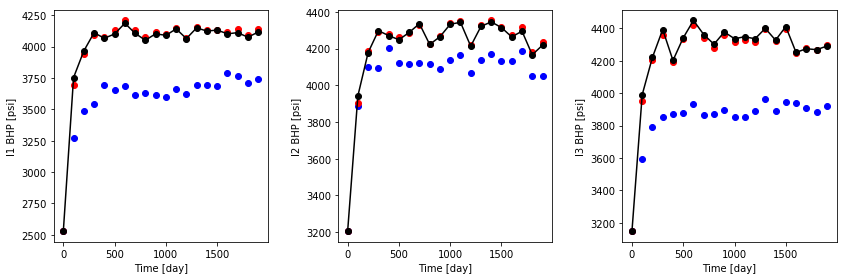

Evaluation Case 3


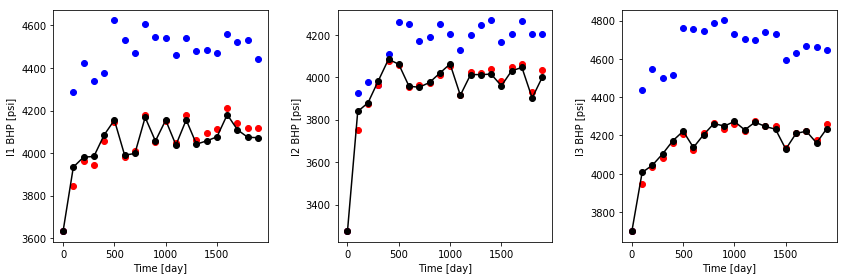

Evaluation Case 4


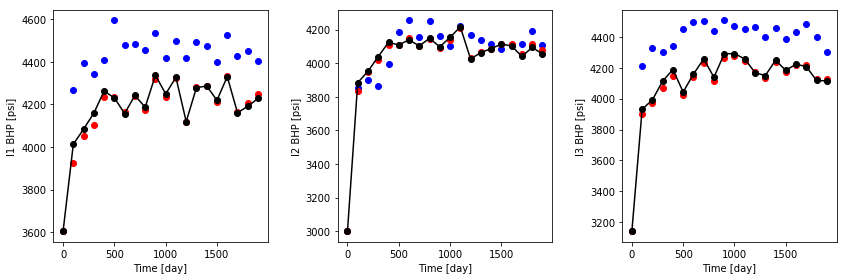

In [29]:
for k in range(num_case):
    print('Evaluation Case %d' % (k+1))
    plt.figure(k, figsize=(12,4))
    for i in range(num_inj):
        injx = inj_loc[i, 0]
        injy = inj_loc[i, 1]
        perm = np.exp(get_logk(logk, injx, injy))
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        pres_true = state_true[ind_case[k], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_pred = state_pred[ind_case[k], :, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_train = state_train[close_train[ind_case[k]], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        inj_rate = ctrl[ind_case[k], :, i+num_prod+num_well] * q_diff + q_min
        
        inj_bhp_pred = np.zeros_like(inj_rate)
        inj_bhp_true = np.zeros_like(inj_rate)
        inj_bhp_train = np.zeros_like(inj_rate)
        
        for j in range(len(bhp)):
            inj_bhp_pred[j] = cal_inj_bhp(pres_pred[[j]], sat_pred[[j]], inj_rate[j], perm)
            inj_bhp_true[j] = cal_inj_bhp(pres_true[[j]], sat_true[[j]], inj_rate[j], perm)
            inj_bhp_train[j] = cal_inj_bhp(pres_train[[j]], sat_train[[j]], inj_rate[j], perm)
   
        plt.subplot(1, num_inj, i+1)
        
        plt.plot(t_steps*10, inj_bhp_train, 'bo')
        plt.plot(t_steps*10, inj_bhp_pred, 'ro')
        plt.plot(t_steps*10, inj_bhp_true, 'ko-')
        
        plt.xlabel('Time [day]')
        plt.ylabel('I%d BHP [psi]' % (i+1))
    plt.tight_layout()
    plt.show()
        
    
    
    

## Sat/Pres plot with error evaluation on closest training

In [30]:
print(t_steps)
num_tstep = len(t_steps)
print(num_tstep)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
20


Case num: 10


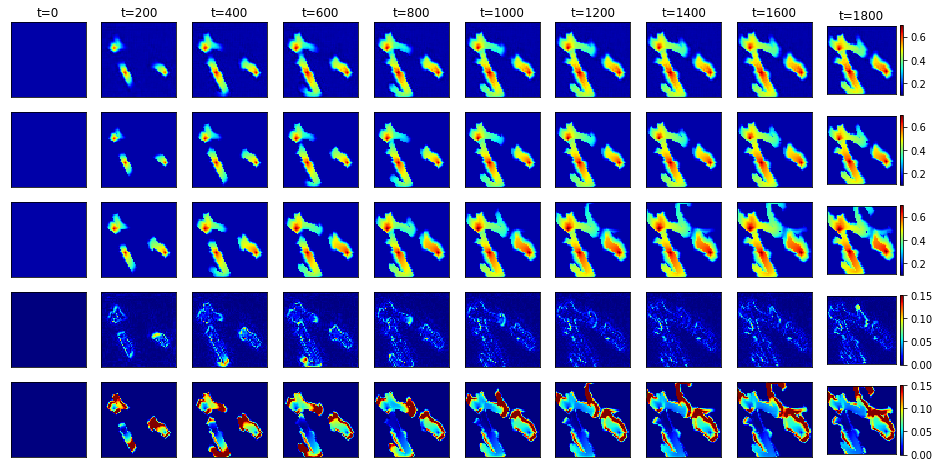

Case num: 15


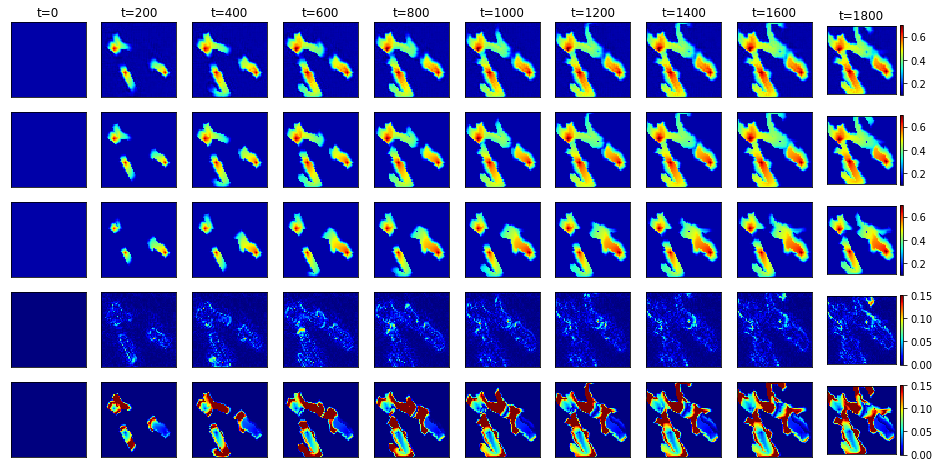

Case num: 17


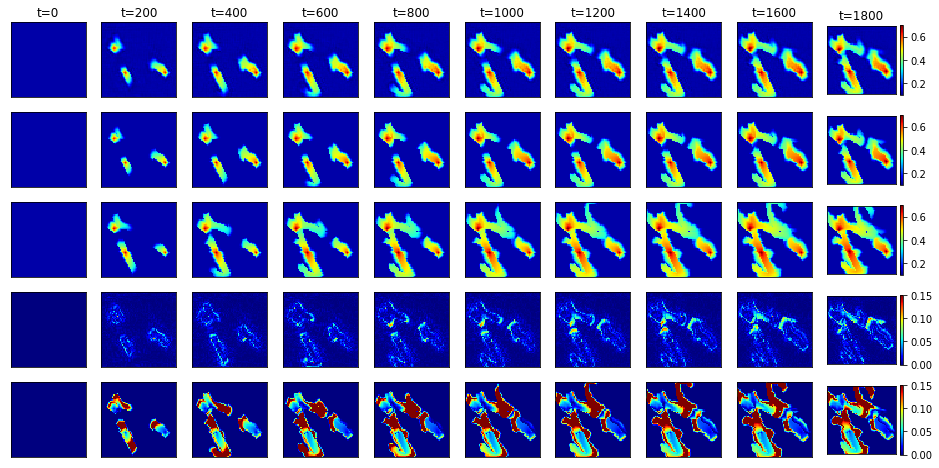

Case num: 74


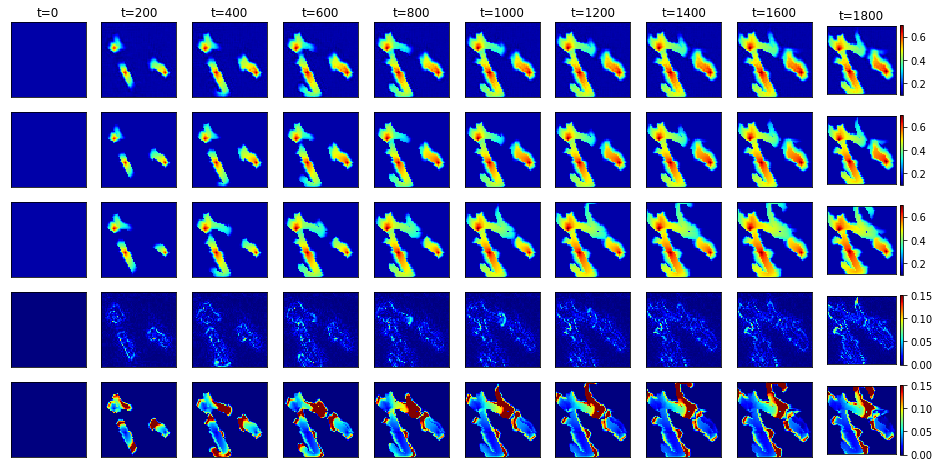

In [31]:
divide = 2
for k in range(num_case):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,8))
    for i_tstep in range(10):
        plt.subplot(5, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred[ind_case[k], i_tstep*divide, :,:, 0])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*10))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        plt.subplot(5, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)       
            
        plt.subplot(5, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(state_train[close_train[ind_case[k]], i_tstep*divide, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)  
        
        plt.subplot(5, num_tstep//divide, i_tstep+1+3*num_tstep//divide)
        plt.imshow(np.fabs(state_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)) - state_pred[ind_case[k], i_tstep*divide, :,:, 0]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
        
        plt.subplot(5, num_tstep//divide, i_tstep+1+4*num_tstep//divide)
        plt.imshow(np.fabs(state_train[close_train[ind_case[k]], i_tstep*divide, :, 0].reshape((60,60)) - state_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60))))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [32]:
state_pred_plot = state_pred[:, :, :, :, 1]
state_true_plot = state_true[:, :, :, 1]
state_train_plot = state_train[:, :, :, 1]

In [33]:
print(state_pred_plot.shape)
print(state_true_plot.shape)
print(state_train_plot.shape)

(100, 20, 60, 60)
(100, 20, 3600)
(300, 20, 3600)


Case num: 10


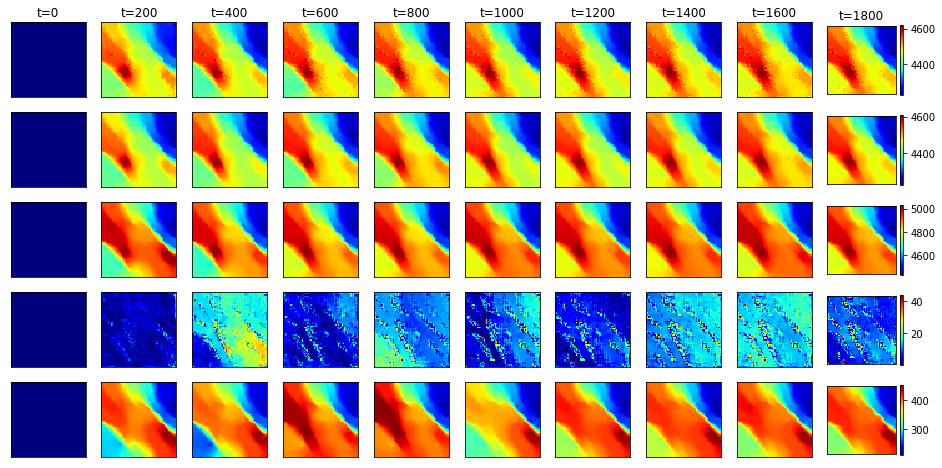

Case num: 15


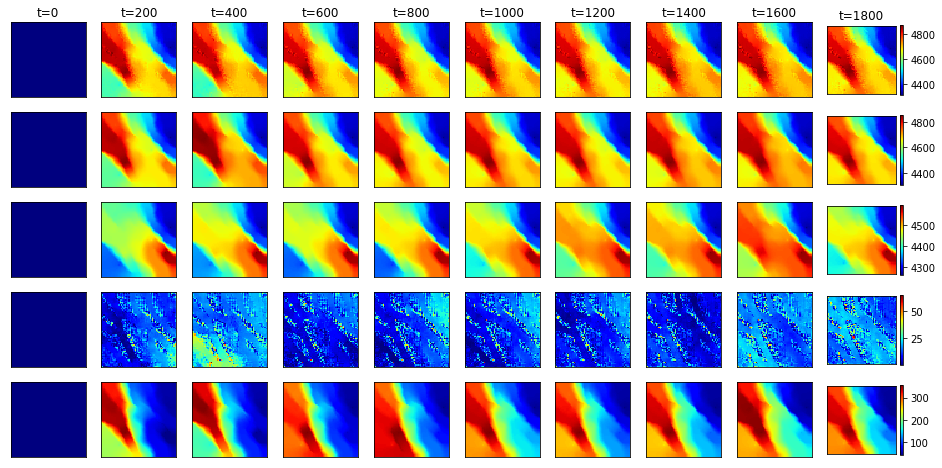

Case num: 17


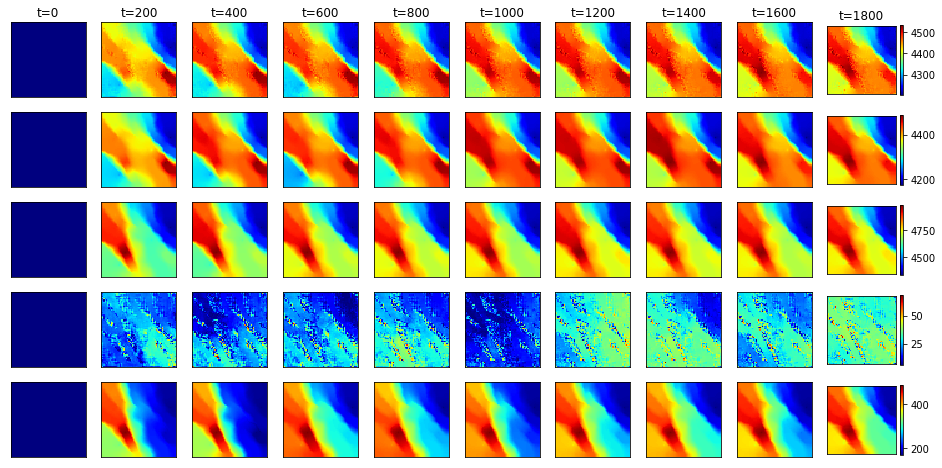

Case num: 74


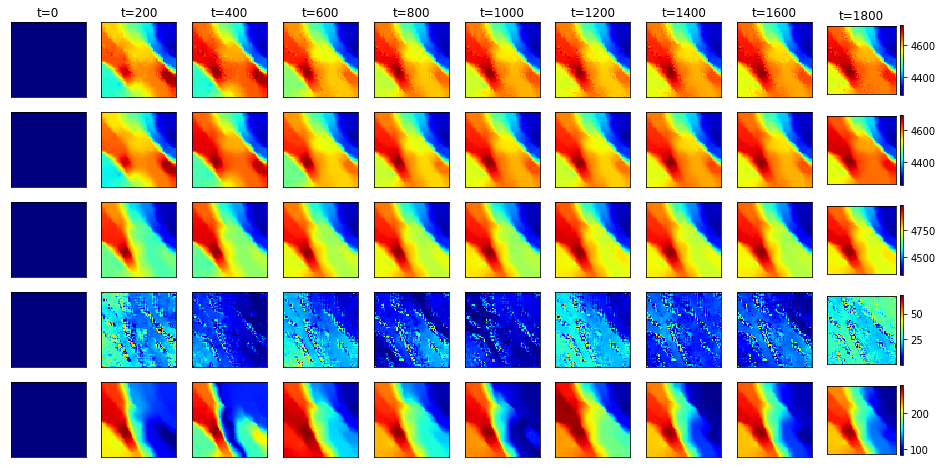

In [34]:
divide = 2
for k in range(num_case):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,8))
    for i_tstep in range(10):
        plt.subplot(5, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*10))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        plt.subplot(5, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
            
        
        plt.subplot(5, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(state_train_plot[close_train[ind_case[k]], i_tstep*divide, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)  
        
        plt.subplot(5, num_tstep//divide, i_tstep+1+3*num_tstep//divide)
        plt.imshow(np.fabs(state_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)) - state_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 30])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
        
        plt.subplot(5, num_tstep//divide, i_tstep+1+4*num_tstep//divide)
        plt.imshow(np.fabs(state_train_plot[close_train[ind_case[k]], i_tstep*divide, :].reshape((60,60)) - state_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60))))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 


    plt.show()

## Artworks in the paper

In [35]:
plt.rcParams.update({'font.size': 20})

In [36]:
print(dt)

100


ind_case: 10
ind_case: 15


/data3/Astro/global/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ind_case: 17
ind_case: 74


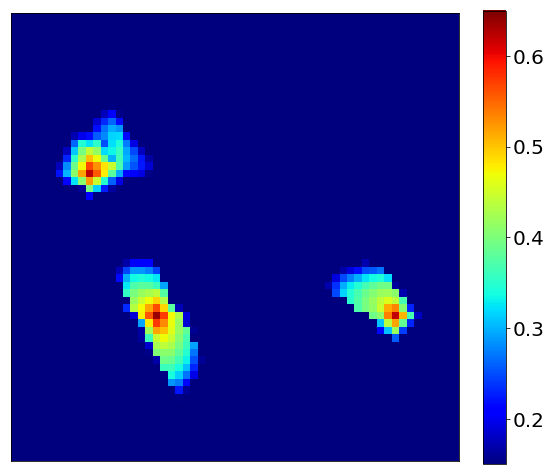

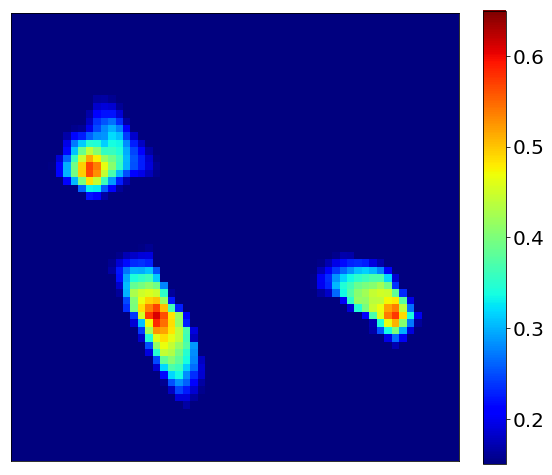

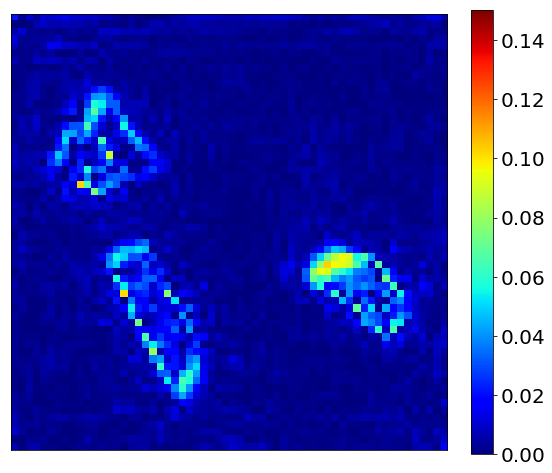

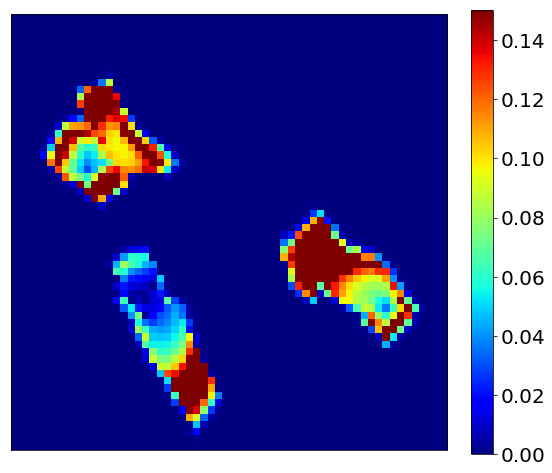

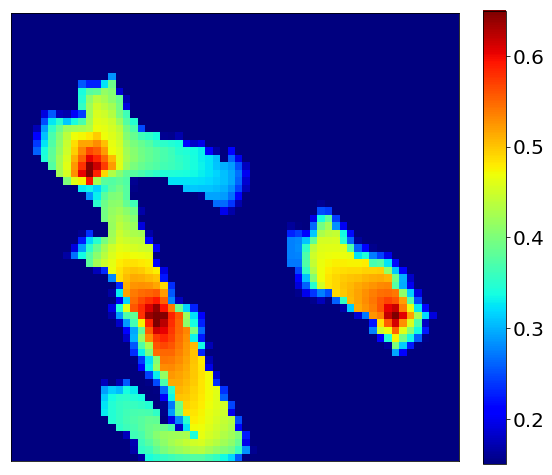

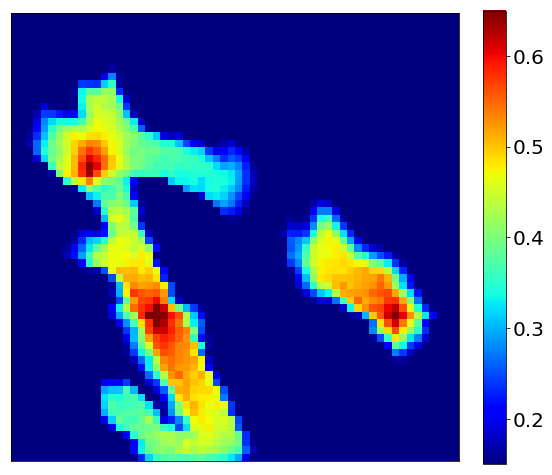

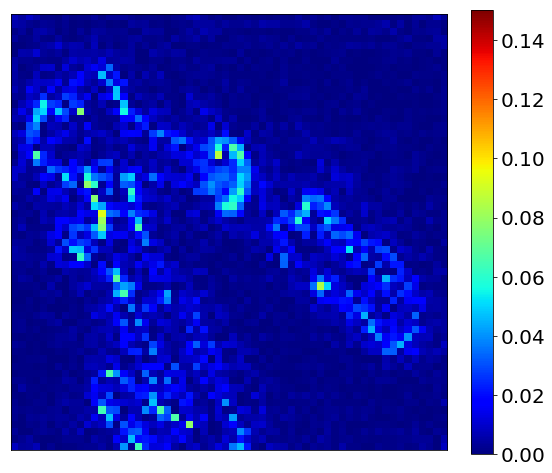

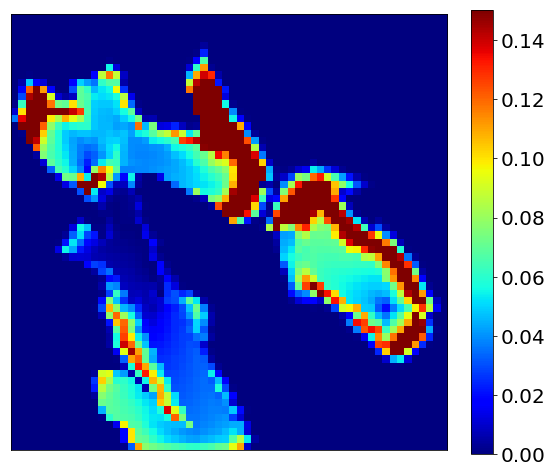

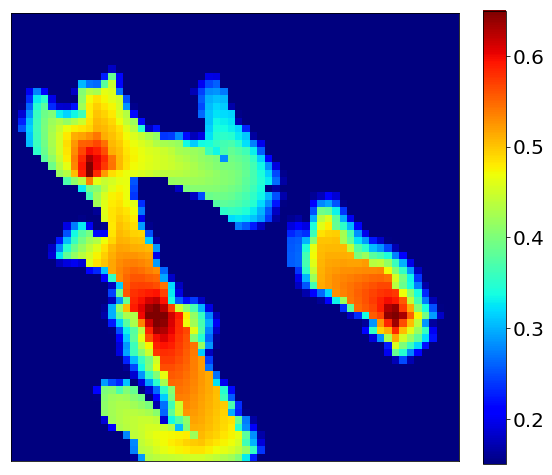

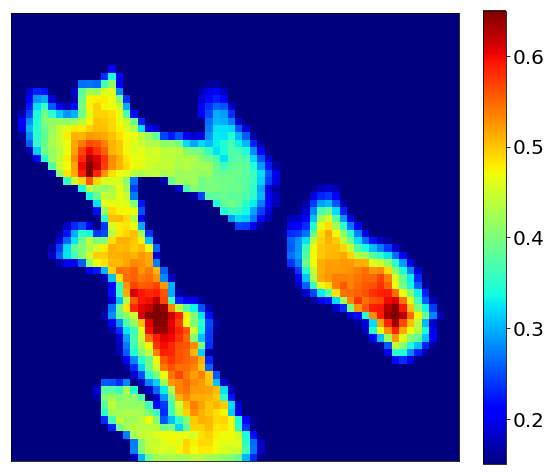

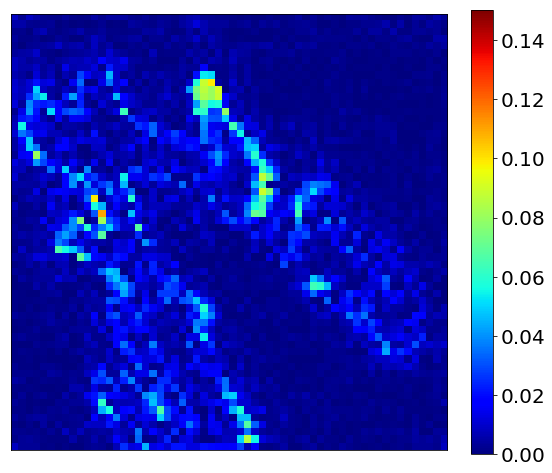

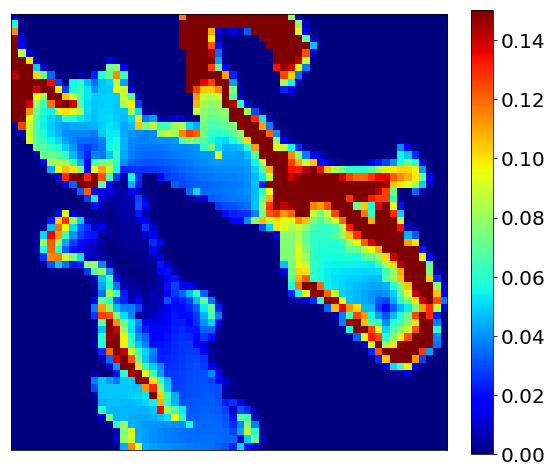

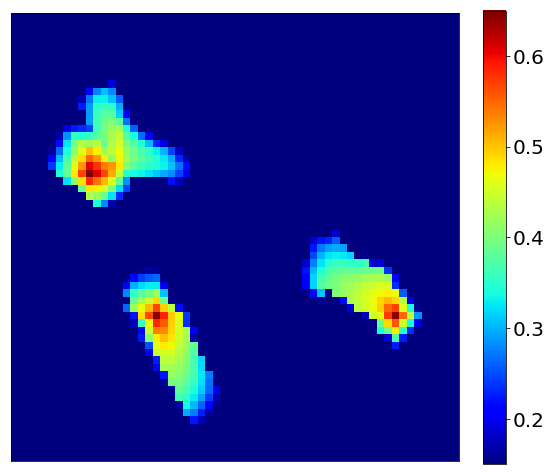

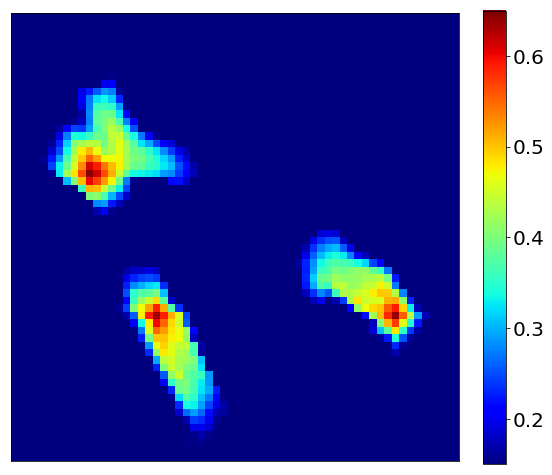

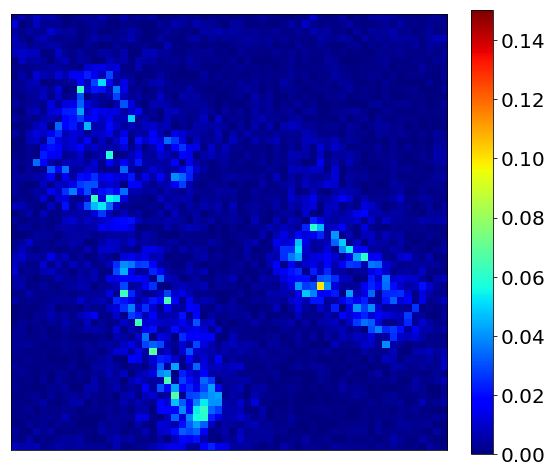

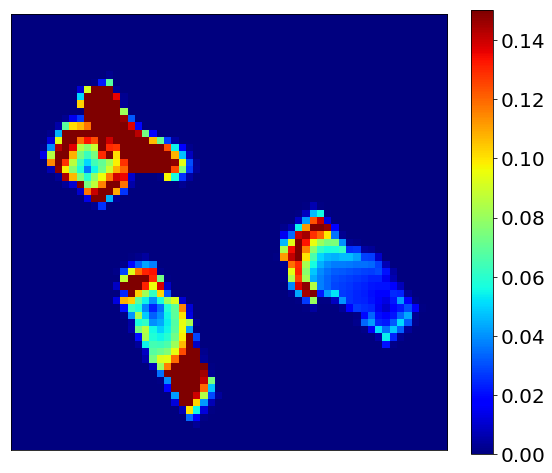

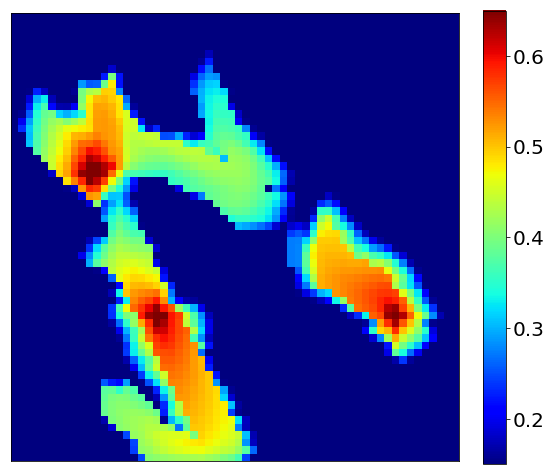

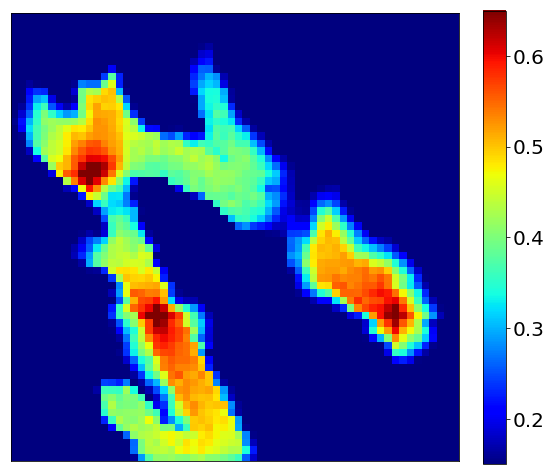

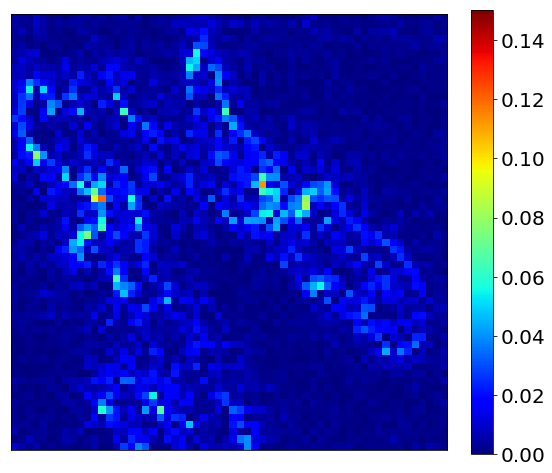

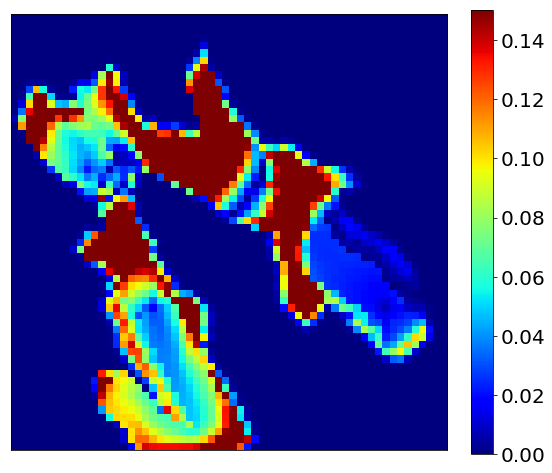

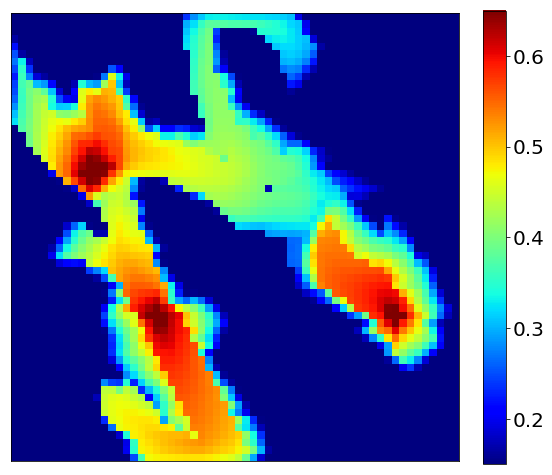

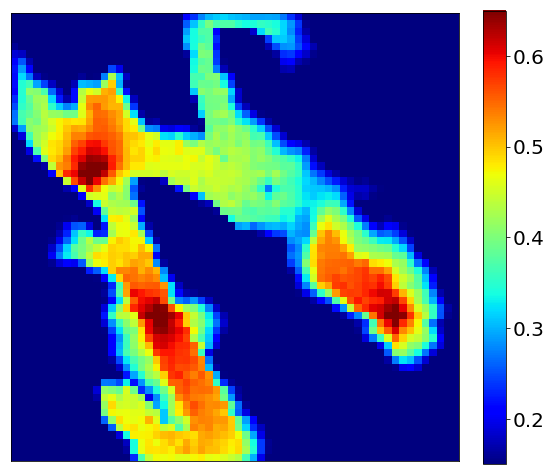

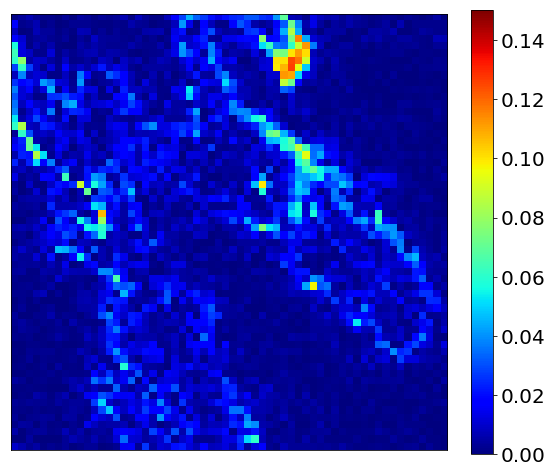

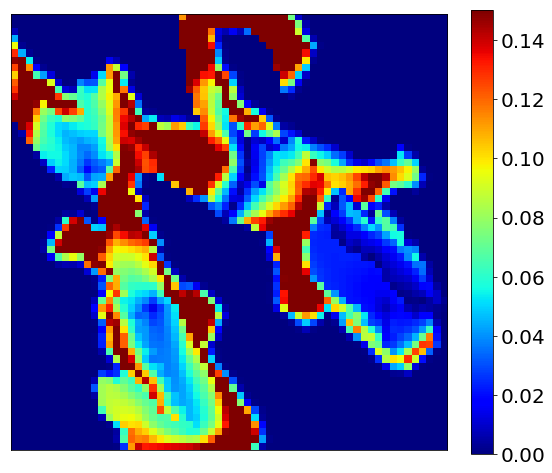

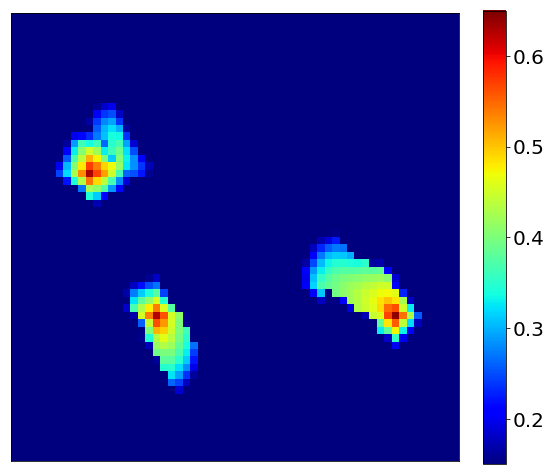

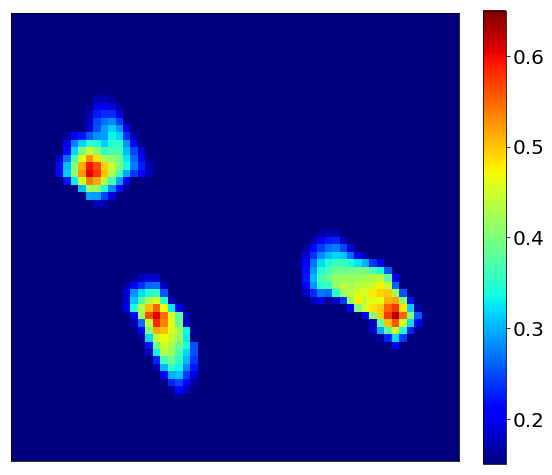

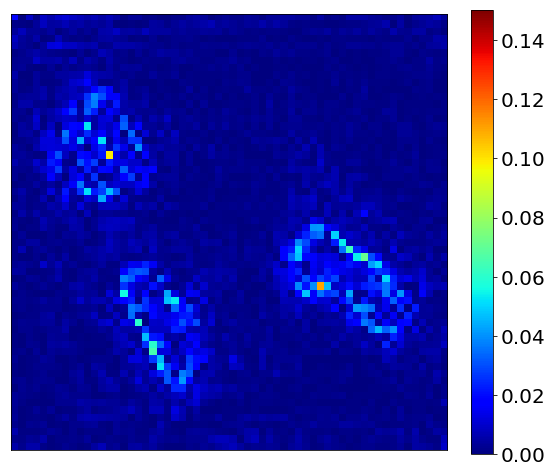

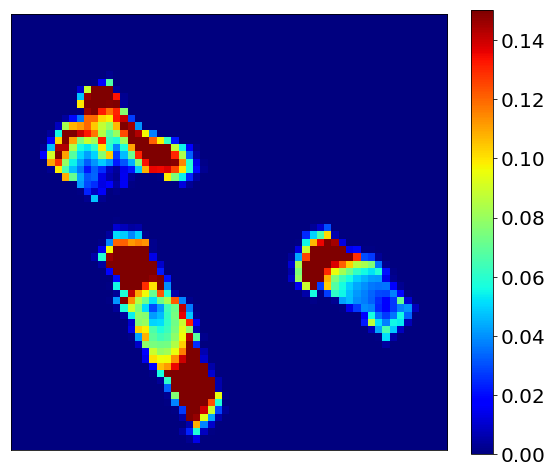

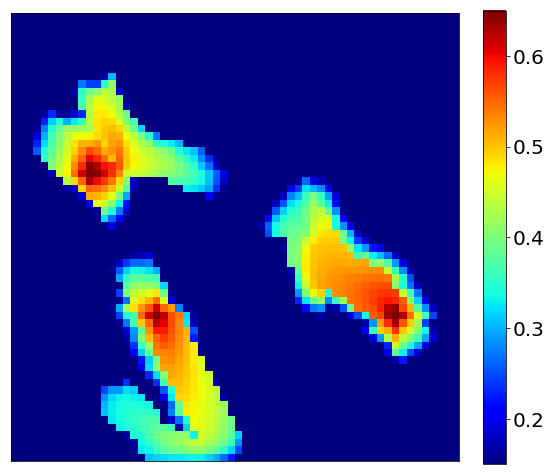

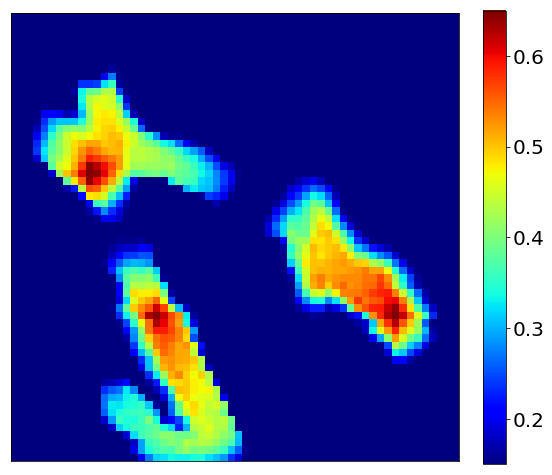

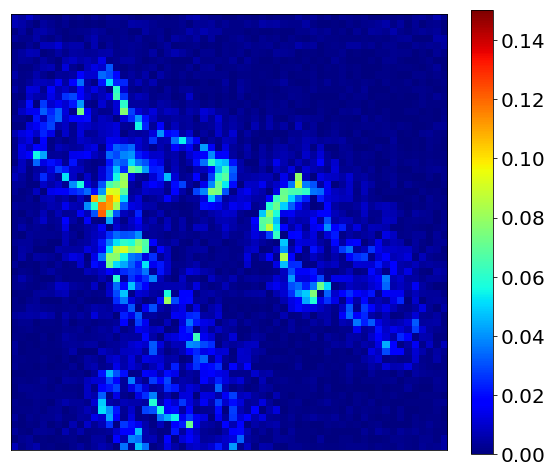

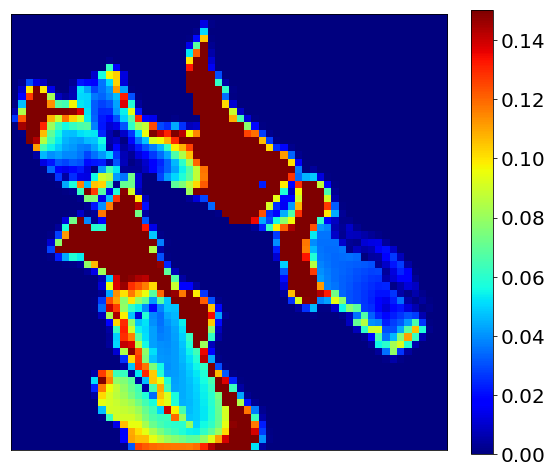

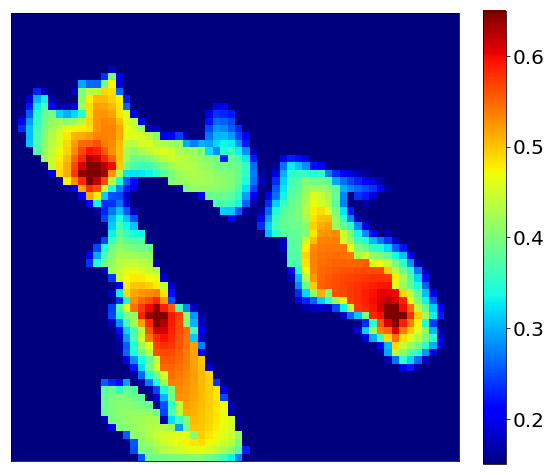

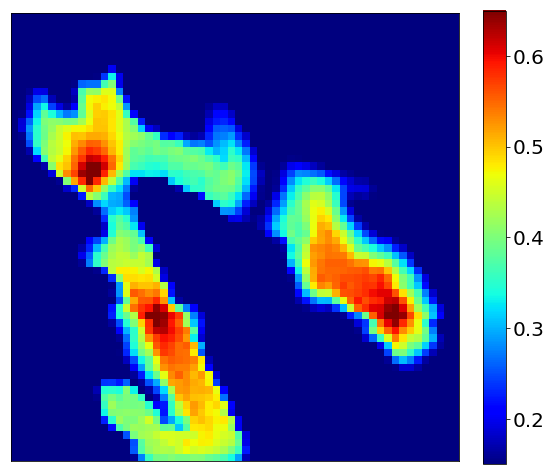

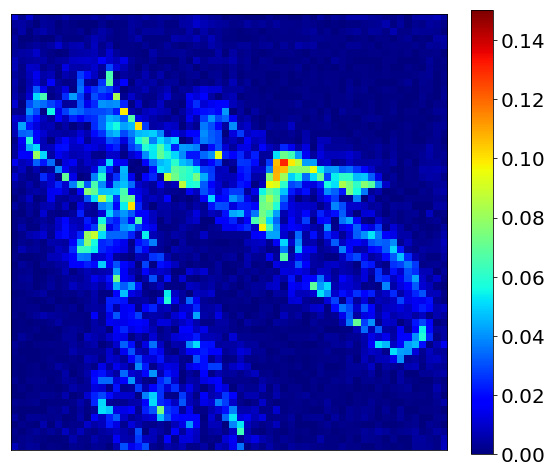

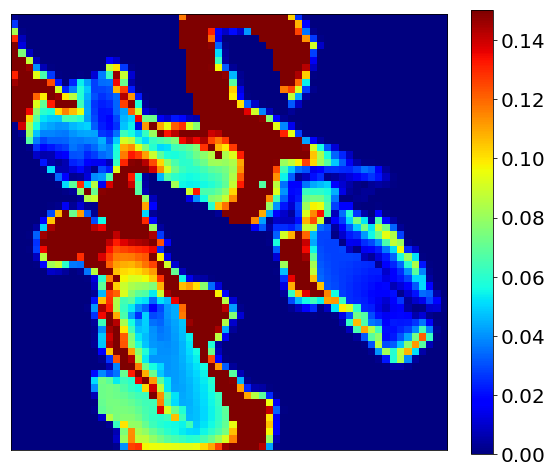

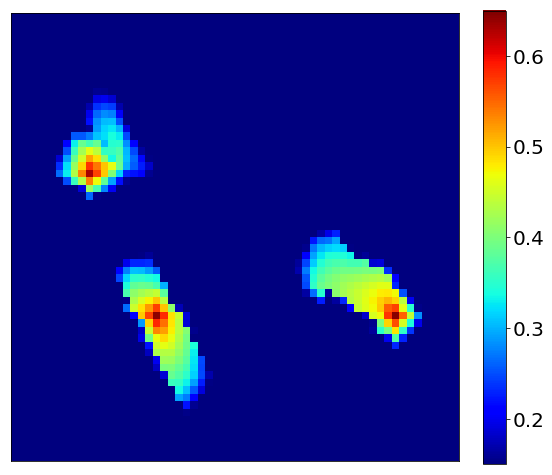

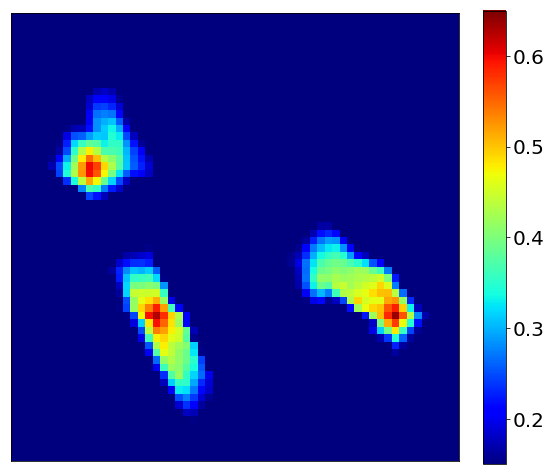

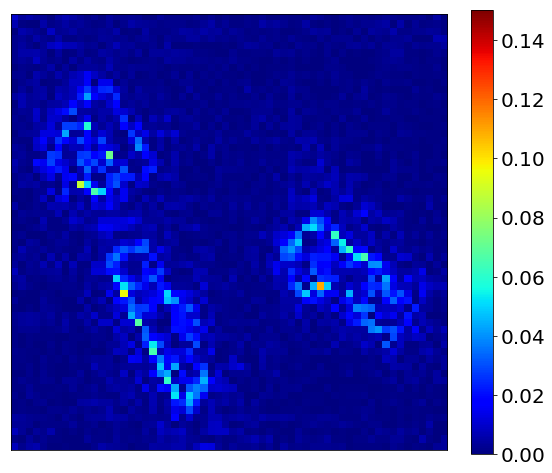

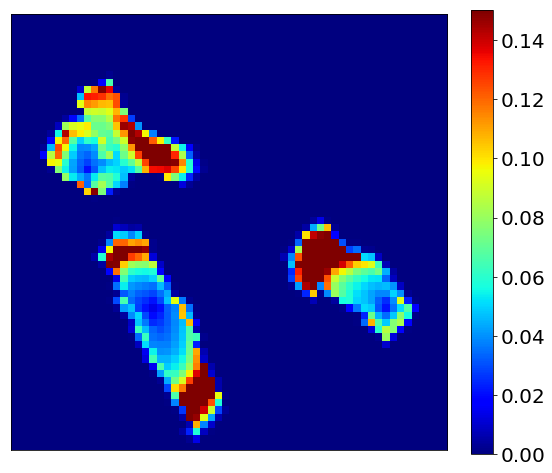

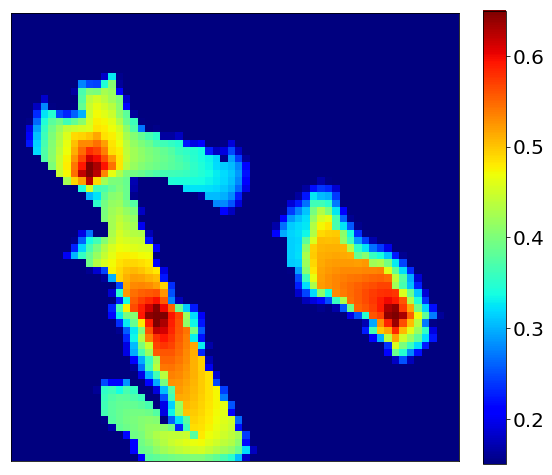

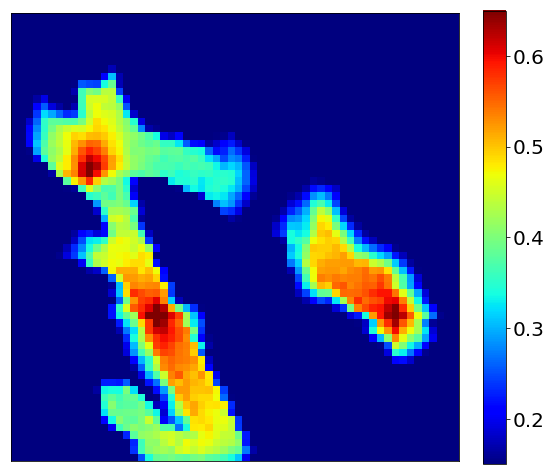

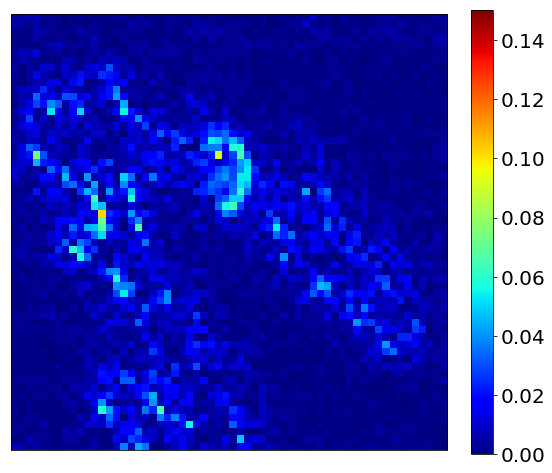

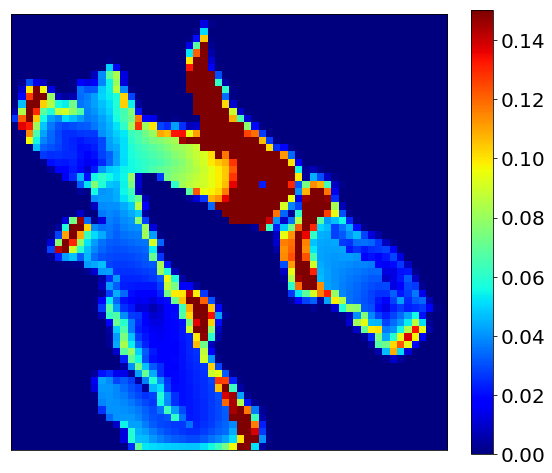

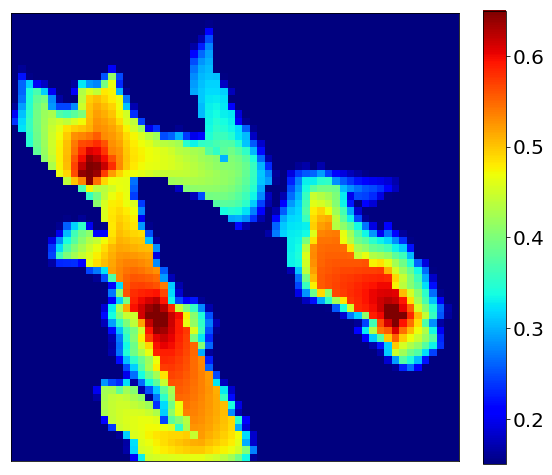

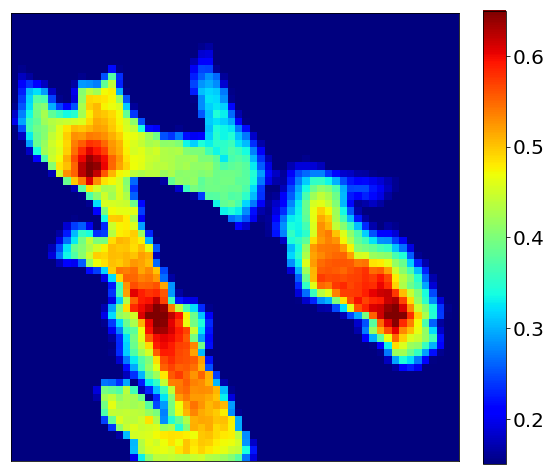

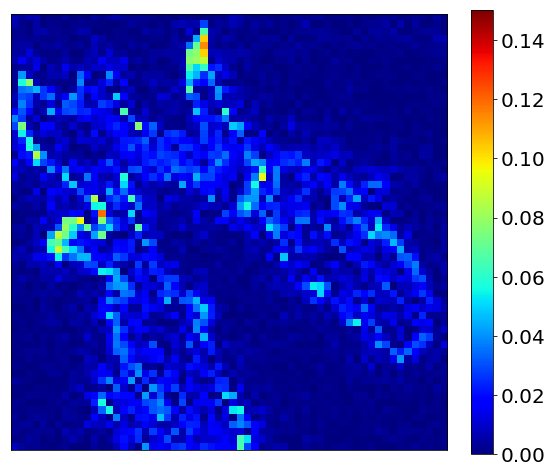

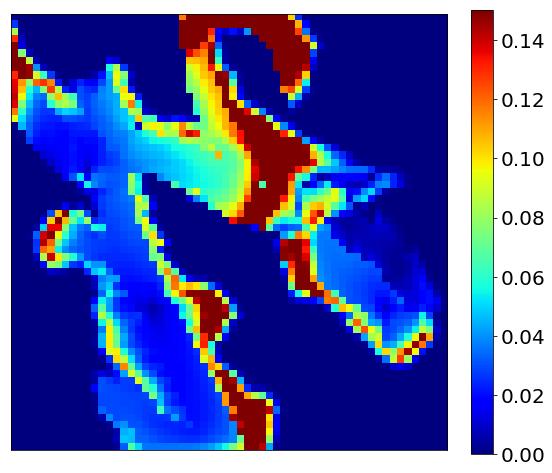

In [37]:
plot_step = [2, 10, 18]
for k in range(len(ind_case)):
    print('ind_case: %d'%(ind_case[k]))
    for i, i_tstep in enumerate(plot_step):
        
        plt.figure(figsize=(8,7))
#         plt.subplot(231)
        plt.imshow(state_true[ind_case[k], i_tstep, :, 0].reshape((60,60)))
#         plt.title('t = %d days'%(i_tstep*dt))
        plt.clim([0.15, 0.65])
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        plt.figure(figsize=(8,7))
#         plt.subplot(232)
        plt.imshow(state_pred[ind_case[k], i_tstep, :, :, 0])
#         plt.title('Predicted')
        plt.clim([0.15, 0.65])
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046) 
        plt.tight_layout()
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_pred.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_pred.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        plt.figure(figsize=(8,7))
#         plt.subplot(233)
        plt.imshow(np.fabs(state_true[ind_case[k], i_tstep, :, 0].reshape((60,60)) - state_pred[ind_case[k], i_tstep, :,:, 0]))
#         plt.title('|True - Predicted|')
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        plt.colorbar(fraction=0.046) 
        plt.tight_layout()
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-pred.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-pred.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        plt.figure(figsize=(8,7))
#         plt.subplot(236)
        plt.imshow(np.fabs(state_train[close_train[ind_case[k]], i_tstep, :, 0].reshape((60,60)) - state_true[ind_case[k], i_tstep, :, 0].reshape((60,60))))
#         plt.title('|True - Closest train|')
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-train.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'sat_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-train.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
    

ind_case: 10
ind_case: 15
ind_case: 17
ind_case: 74


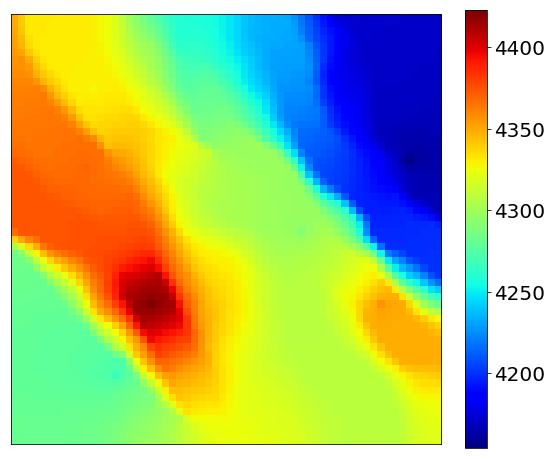

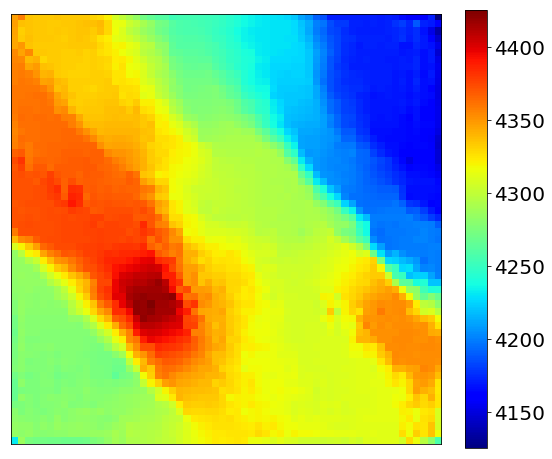

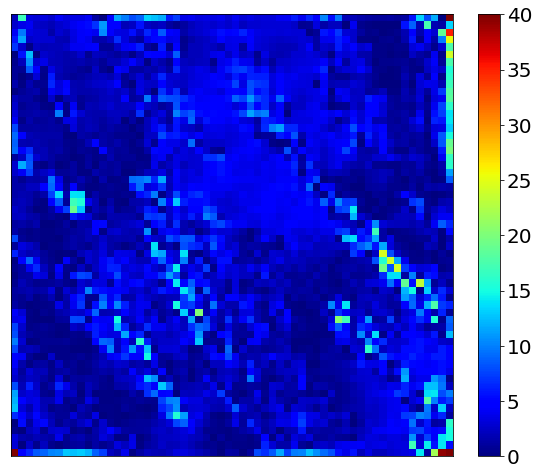

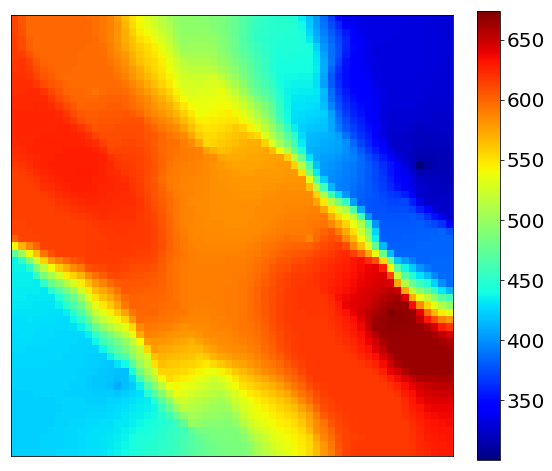

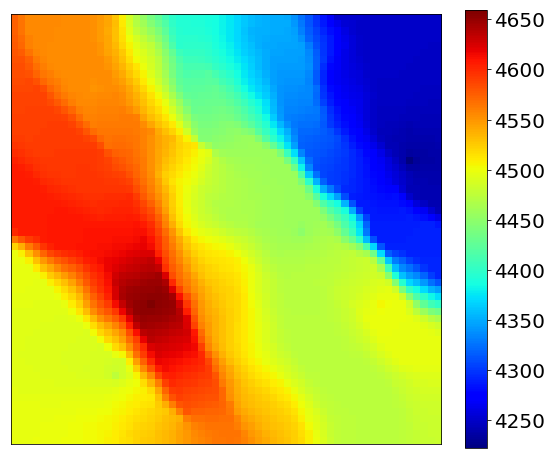

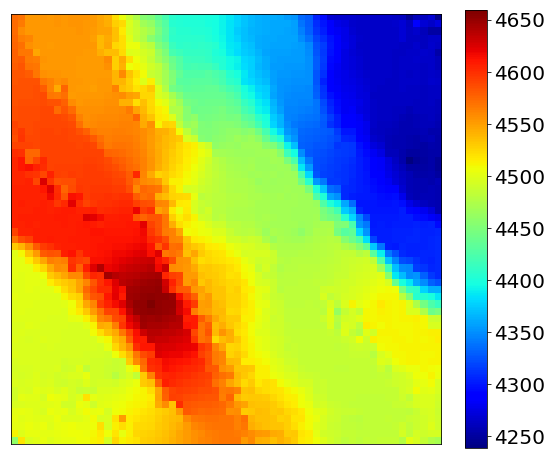

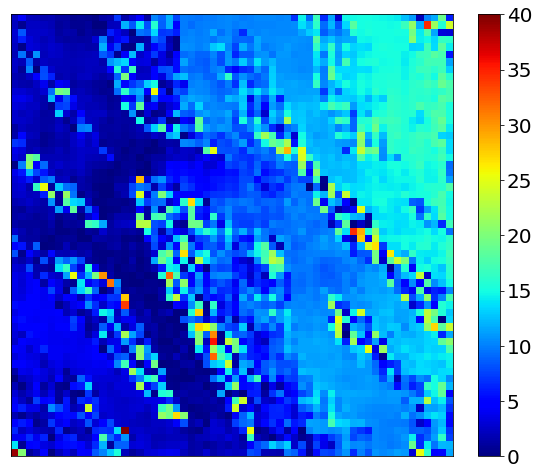

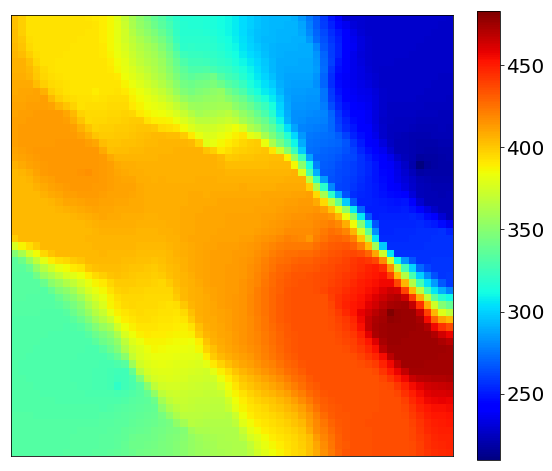

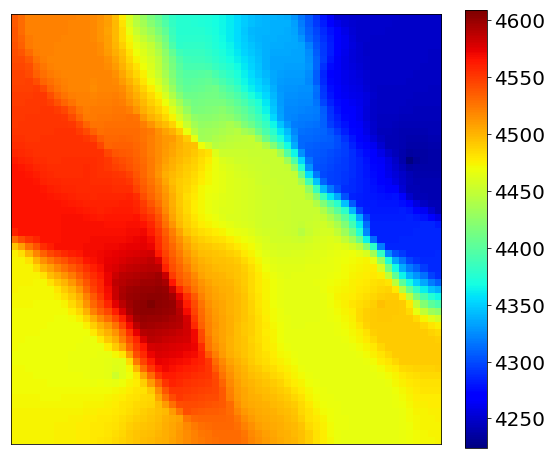

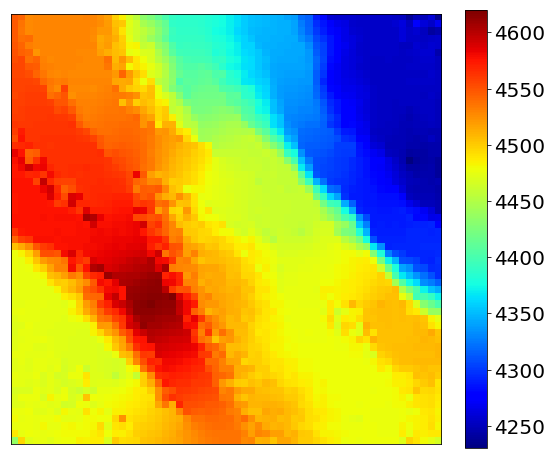

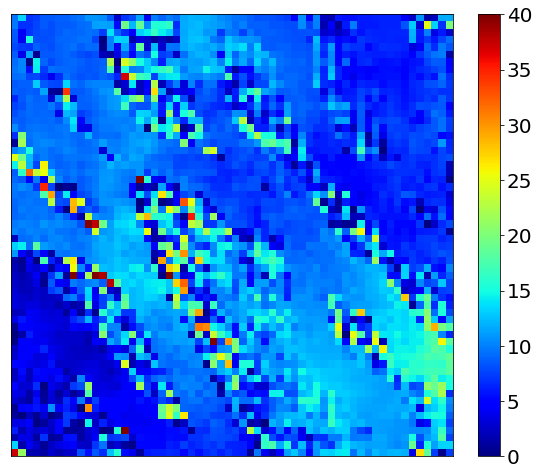

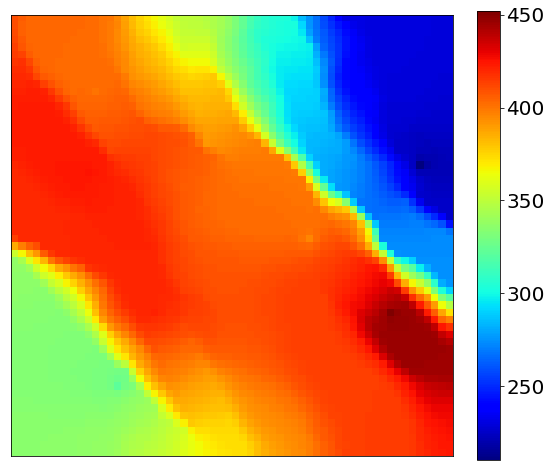

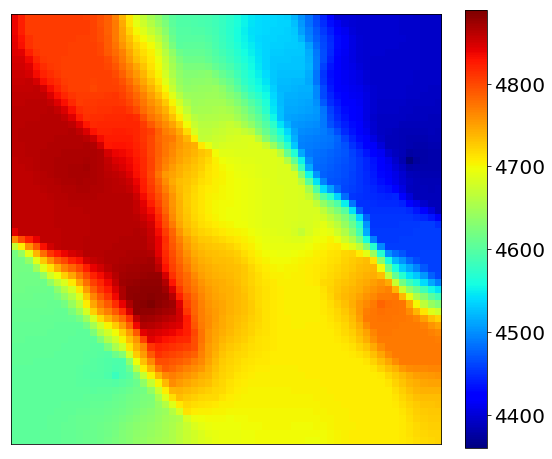

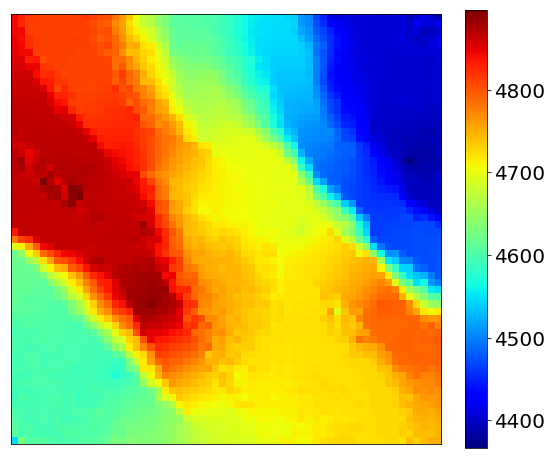

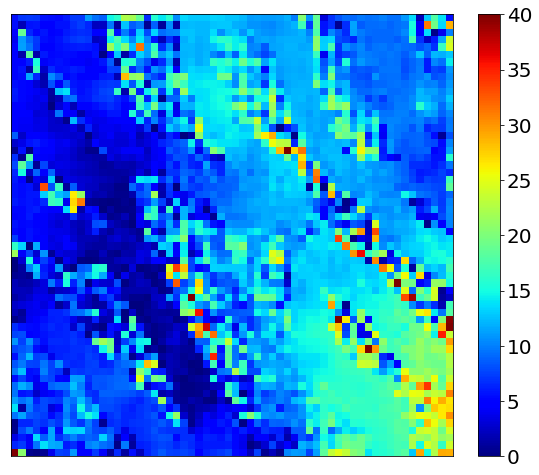

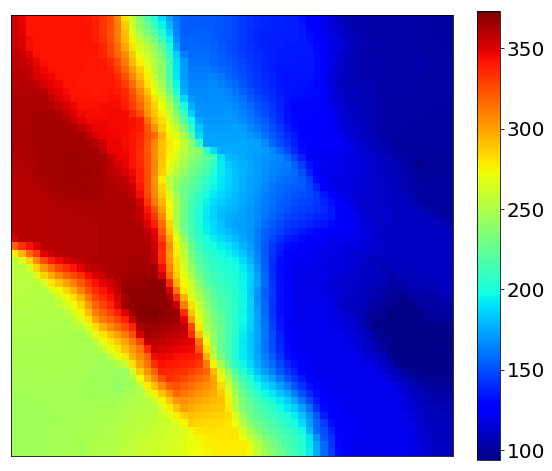

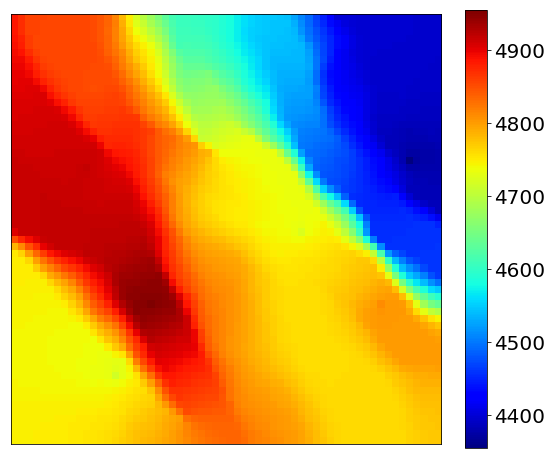

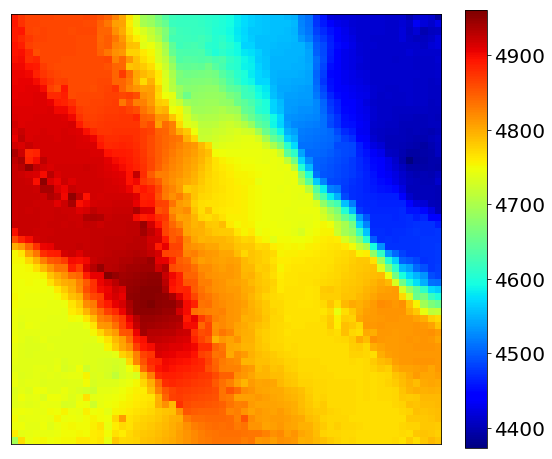

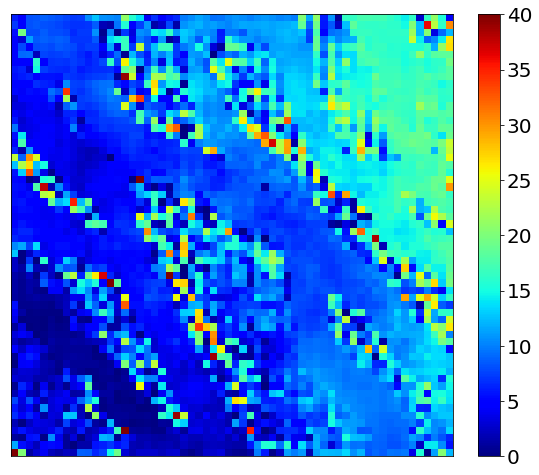

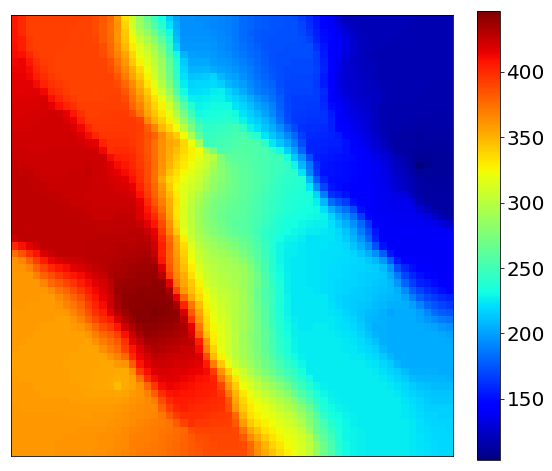

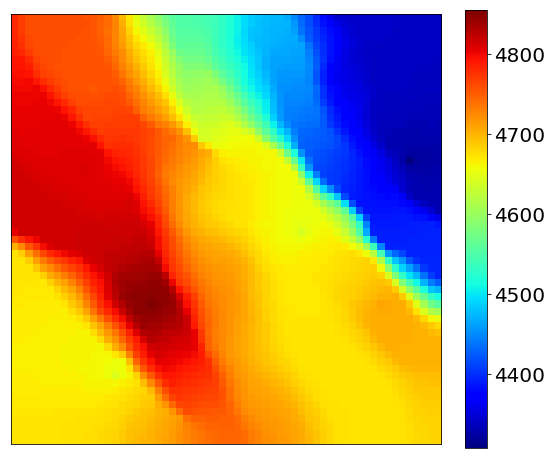

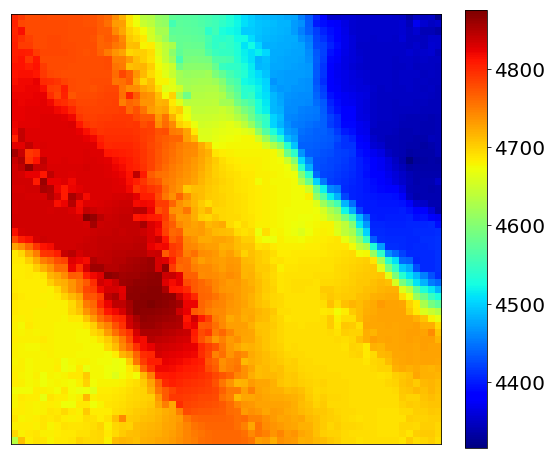

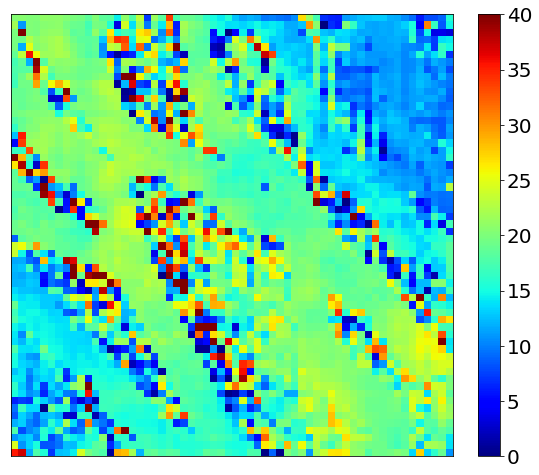

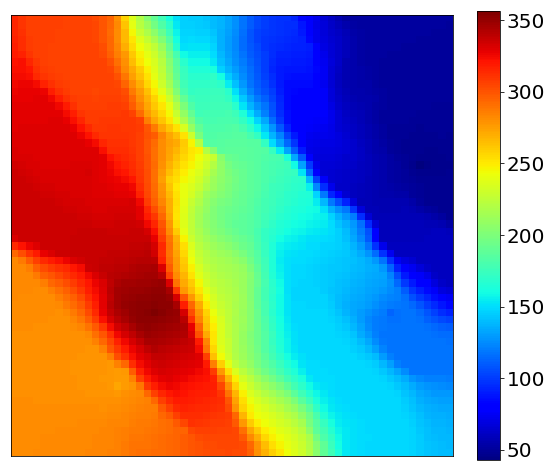

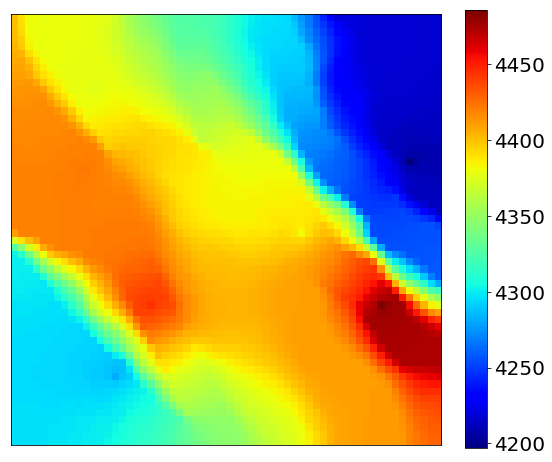

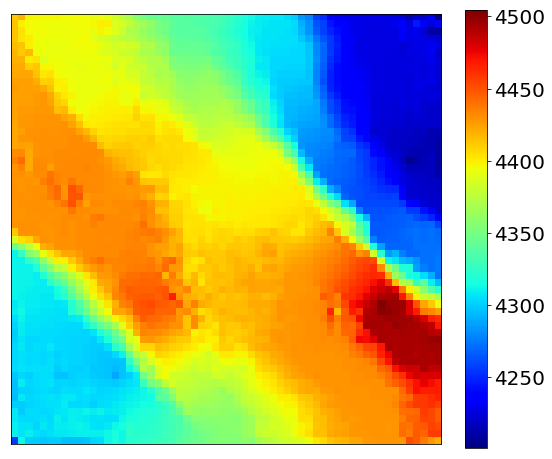

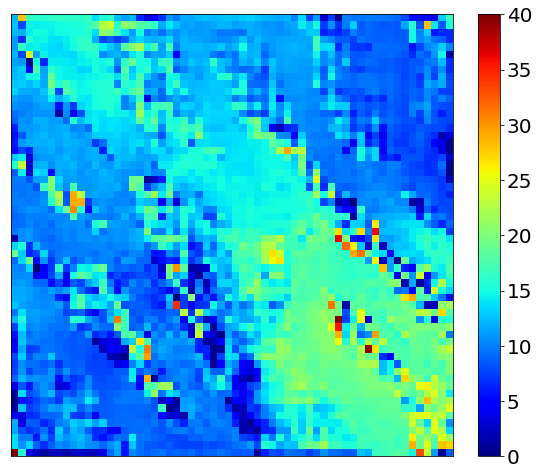

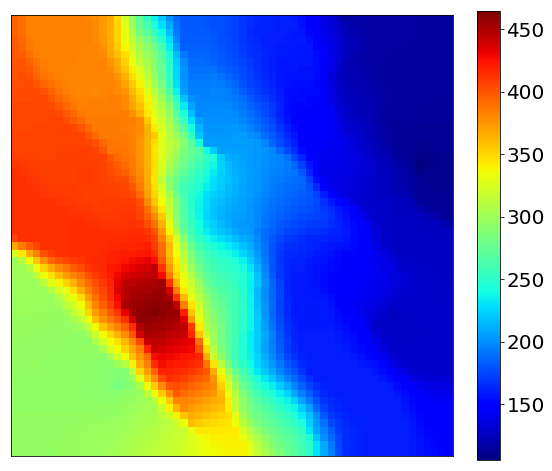

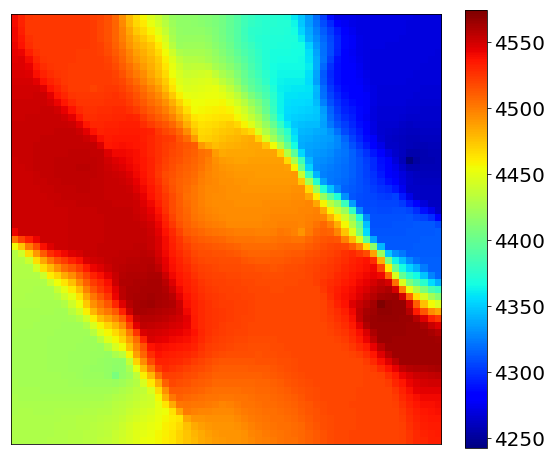

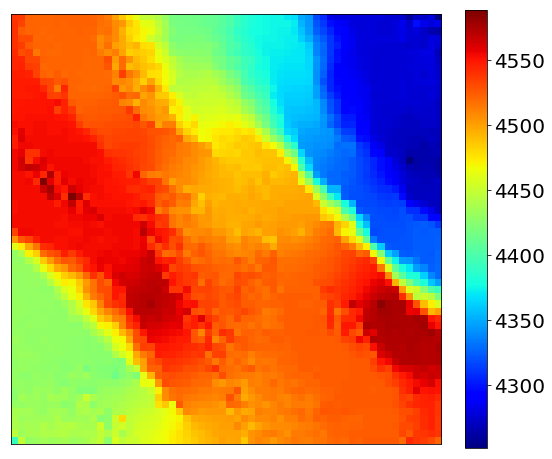

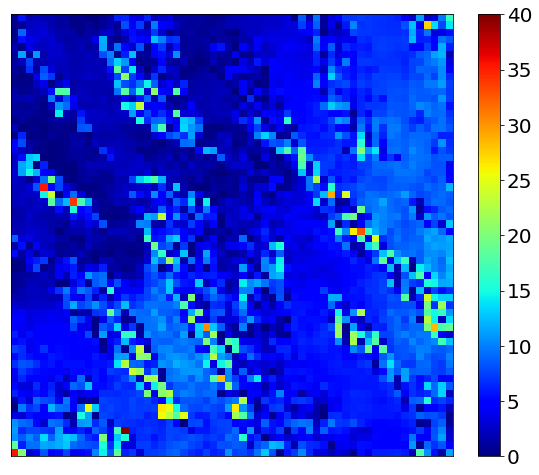

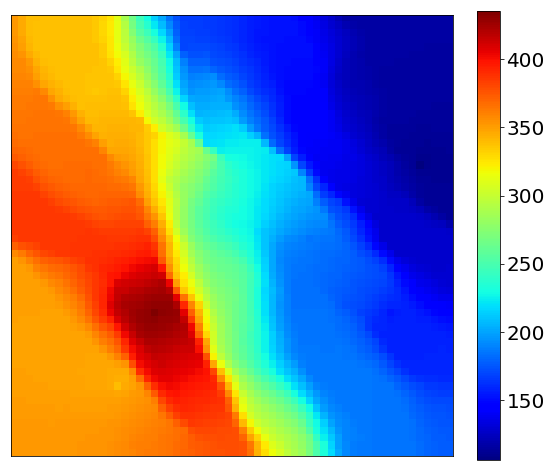

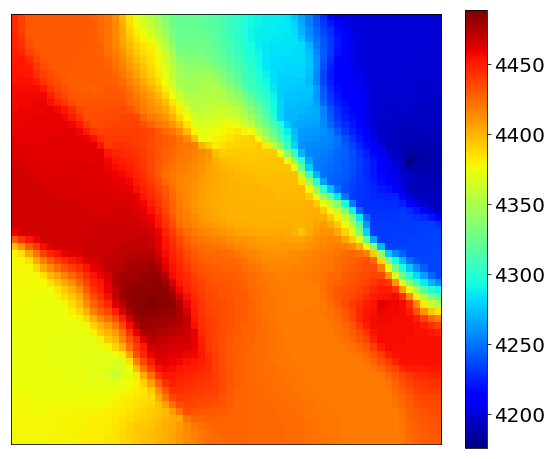

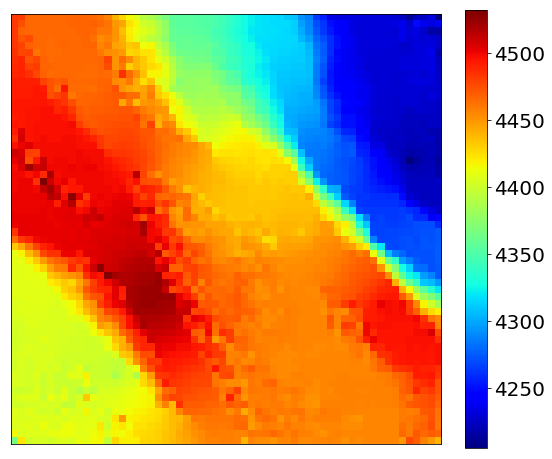

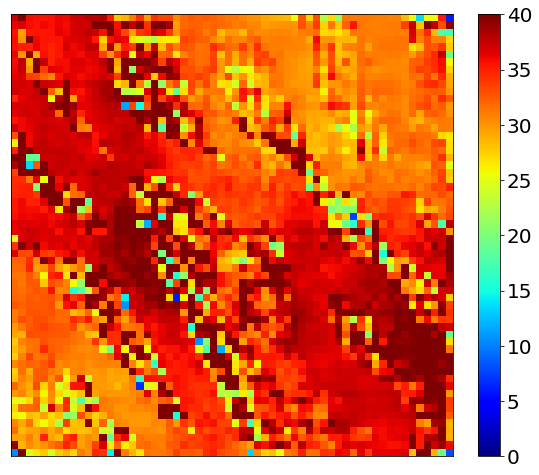

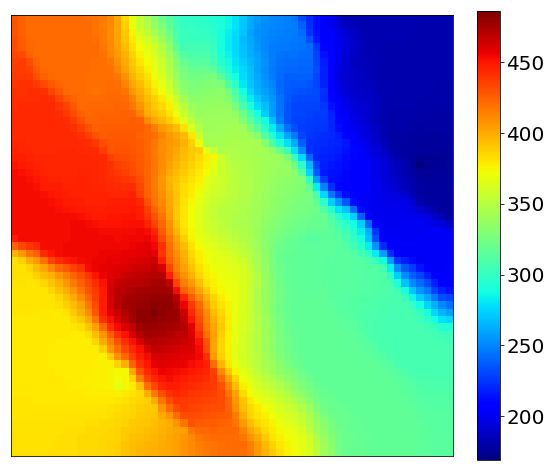

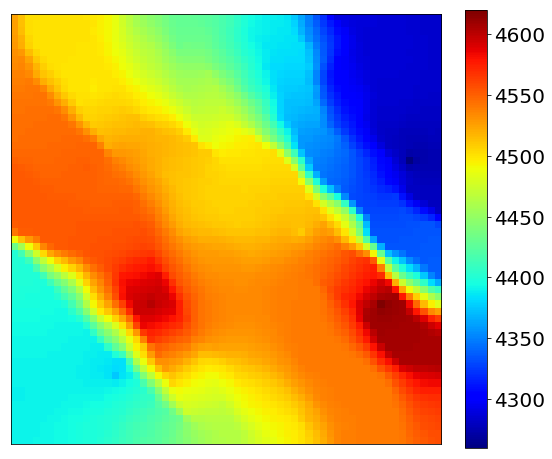

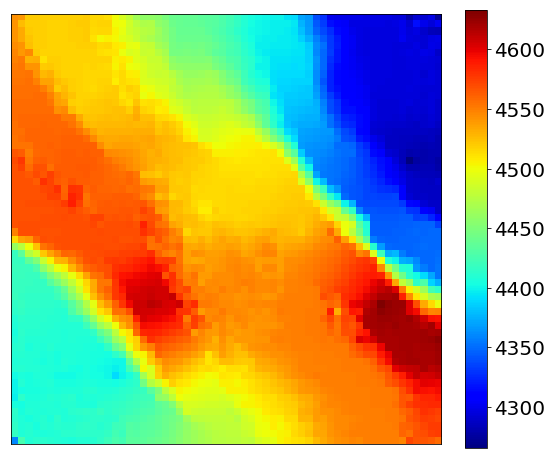

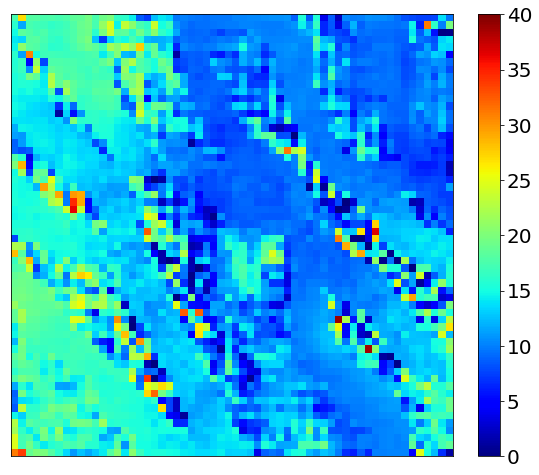

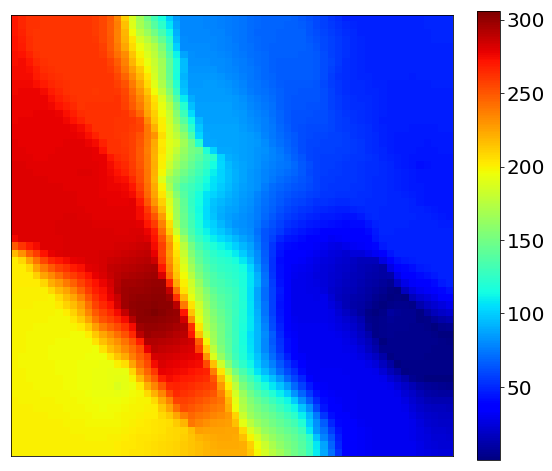

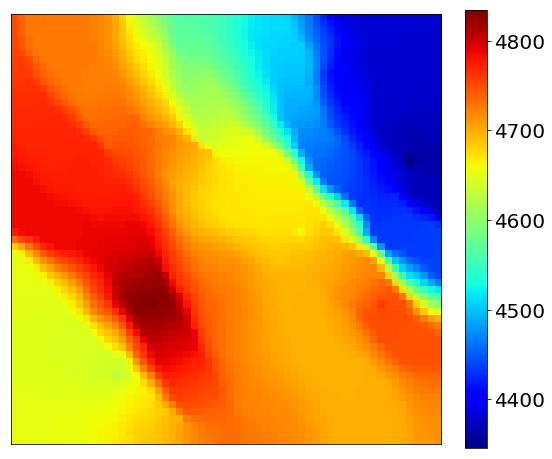

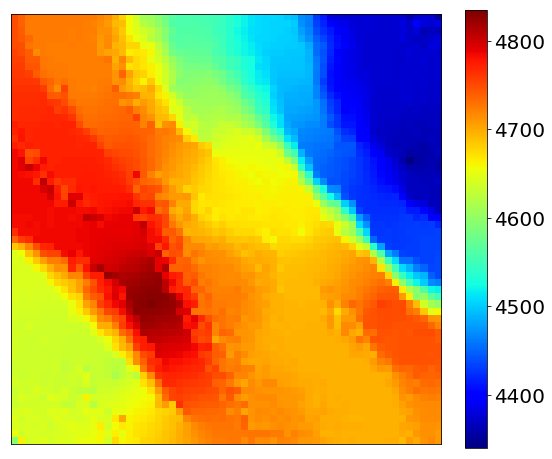

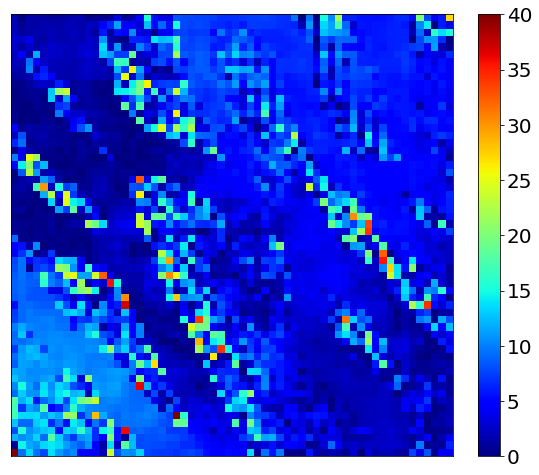

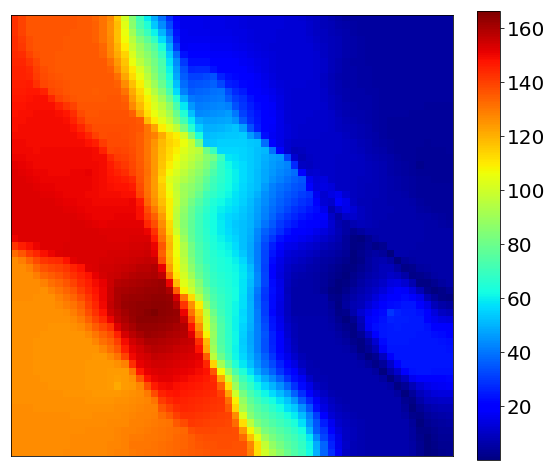

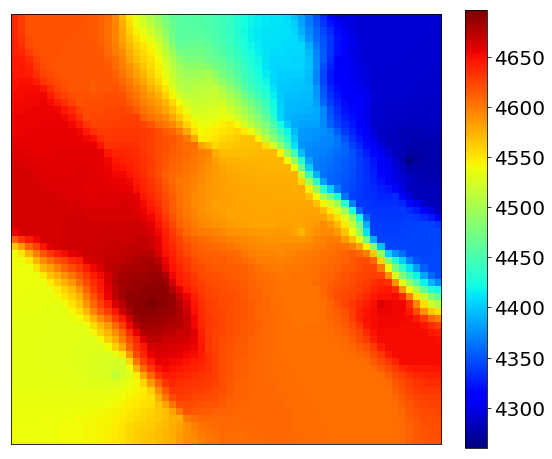

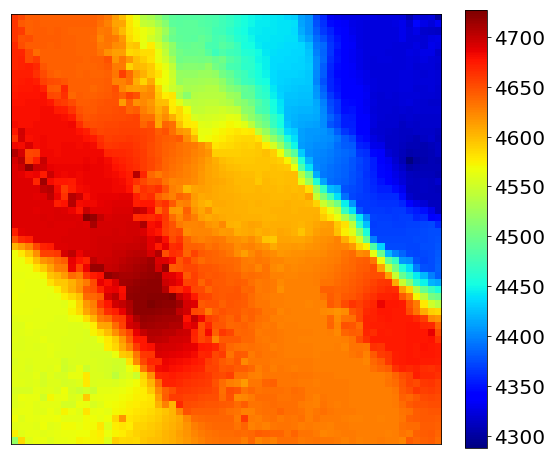

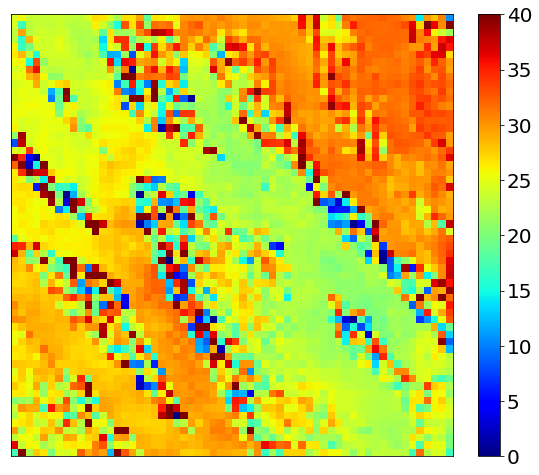

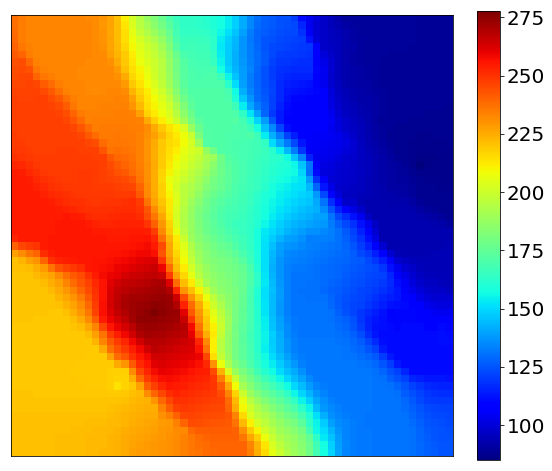

In [38]:
plot_step = [2, 10, 18]
for k in range(len(ind_case)):
    print('ind_case: %d'%(ind_case[k]))
    for i, i_tstep in enumerate(plot_step):

        plt.figure(figsize=(8,7))
        plt.imshow(state_true_plot[ind_case[k], i_tstep, :].reshape((60,60)))
#         plt.title('t = %d days'%(i_tstep*dt))
#         plt.clim([0.15, 0.65])
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        plt.figure(figsize=(8,7))
        plt.imshow(state_pred_plot[ind_case[k], i_tstep, :, :])
#         plt.title('Predicted')
#         plt.clim([0.15, 0.65])
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_pred.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_pred.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        plt.figure(figsize=(8,7))
        plt.imshow(np.fabs(state_true_plot[ind_case[k], i_tstep, :].reshape((60,60)) - state_pred_plot[ind_case[k], i_tstep, :,:]))
#         plt.title('|True - Predicted|')
        plt.clim([0, 40])
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-pred.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-pred.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)

        plt.figure(figsize=(8,7))
        plt.imshow(np.fabs(state_train_plot[close_train[ind_case[k]], i_tstep, :].reshape((60,60)) - state_true_plot[ind_case[k], i_tstep, :].reshape((60,60))))
#         plt.title('|True - Closest train|')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(fraction=0.046) 
        plt.tight_layout()
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-train.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'pres_eval_%d_t_%d_'%(ind_case[k], i_tstep*dt) + case_name + target_suffix + '_nt_%d_true-train.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
    

Evaluation Case 1
Evaluation Case 2
Evaluation Case 3
Evaluation Case 4


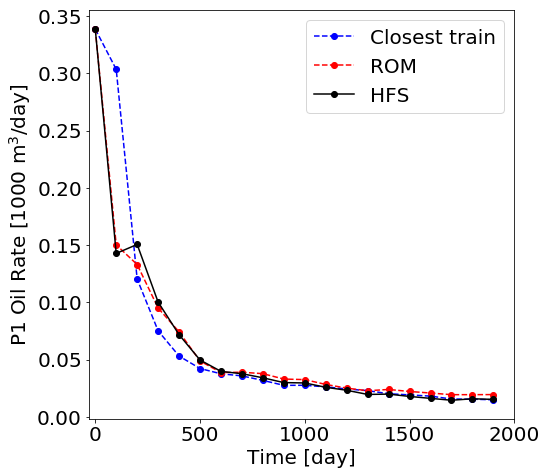

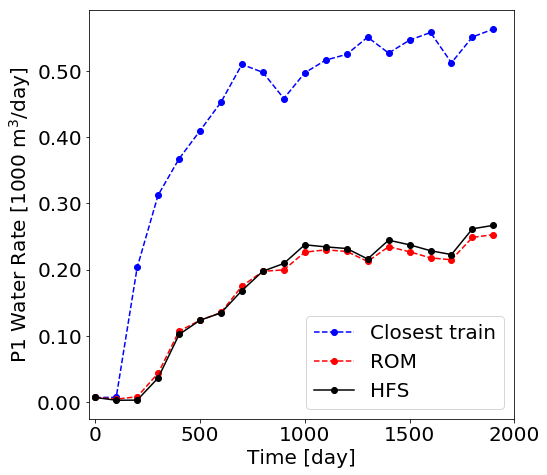

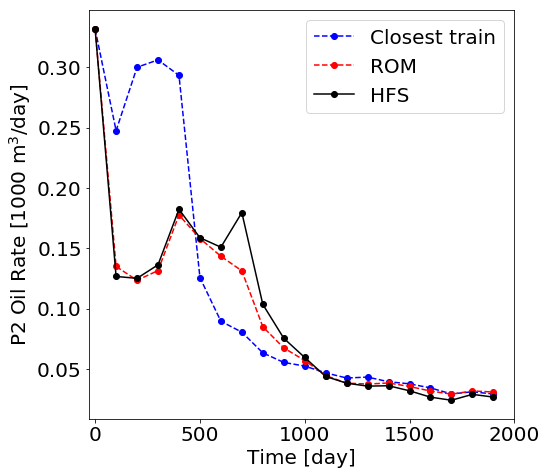

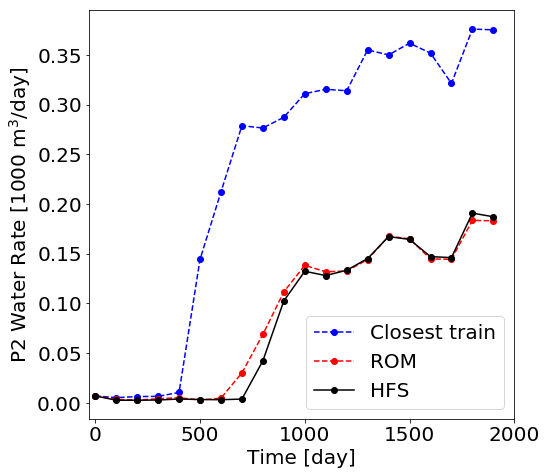

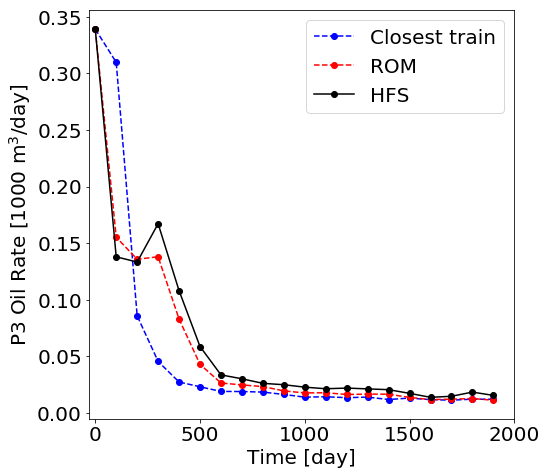

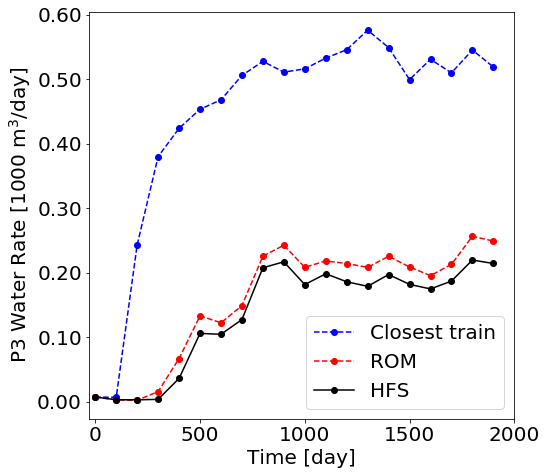

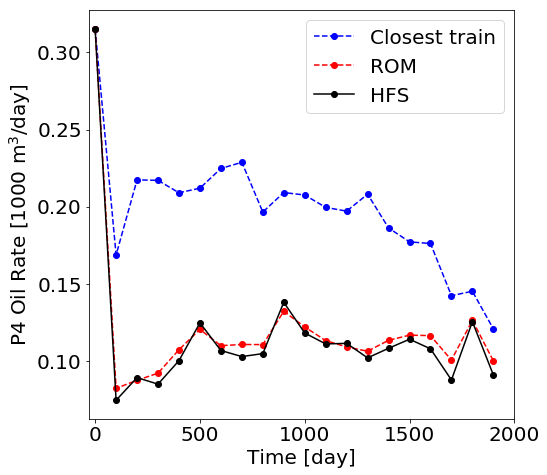

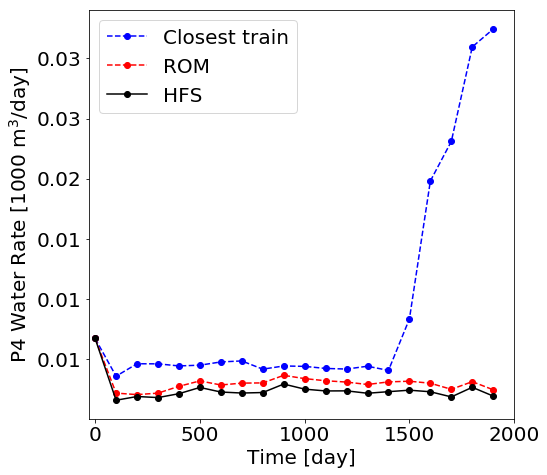

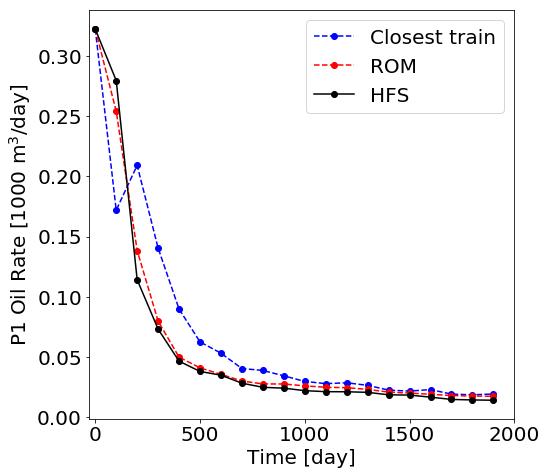

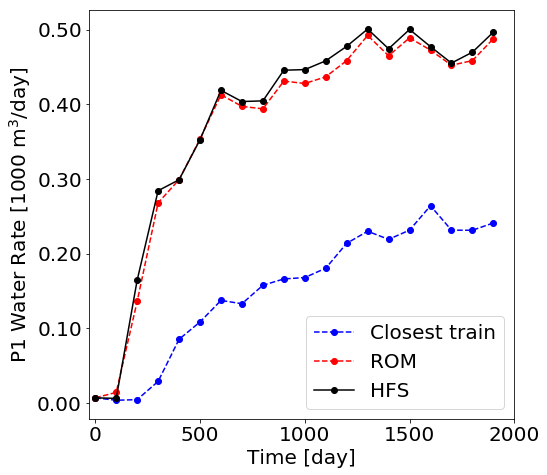

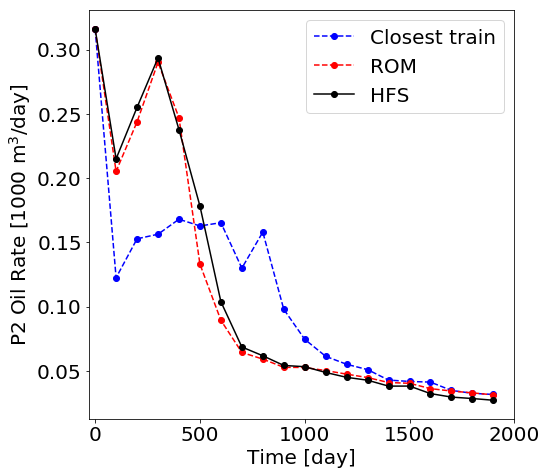

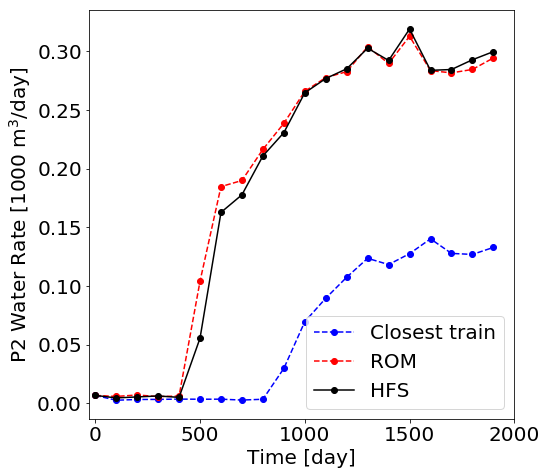

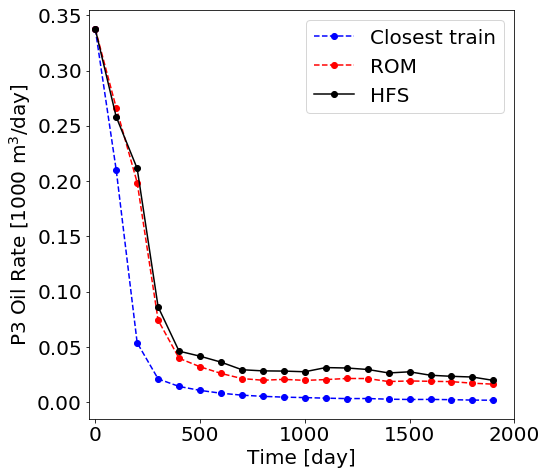

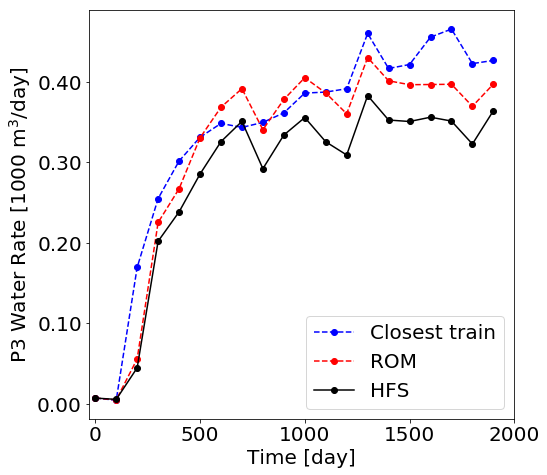

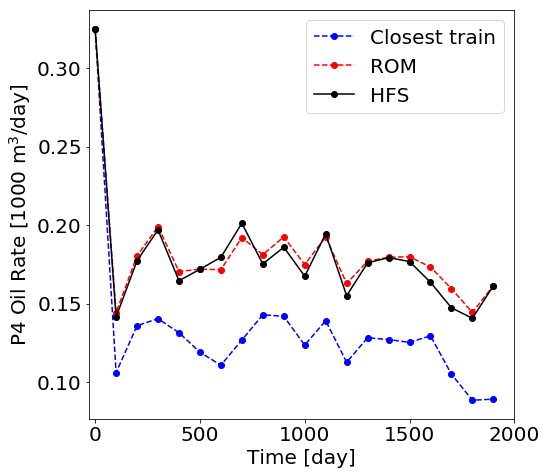

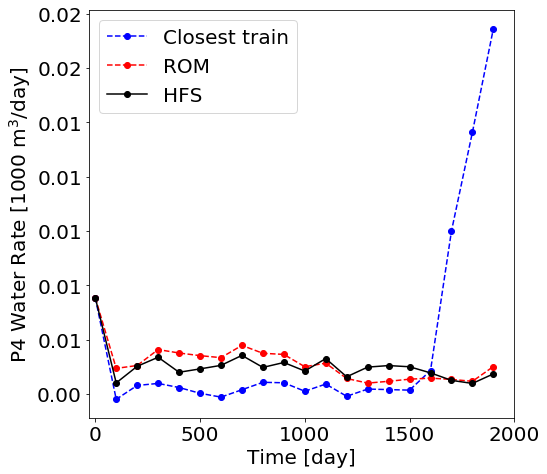

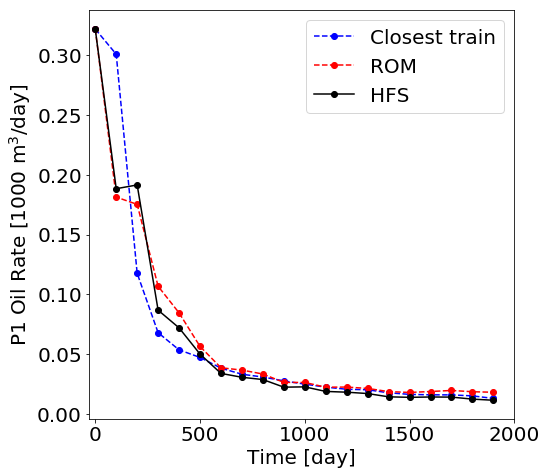

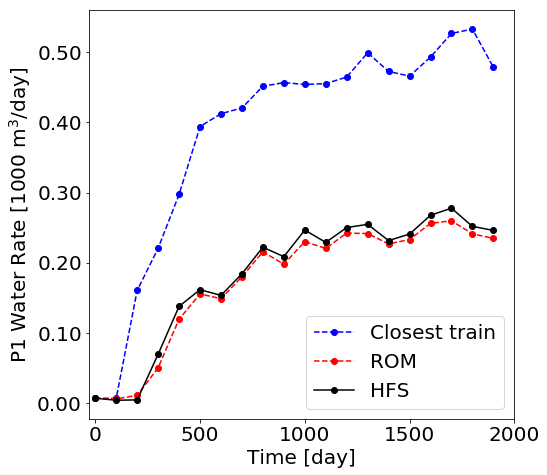

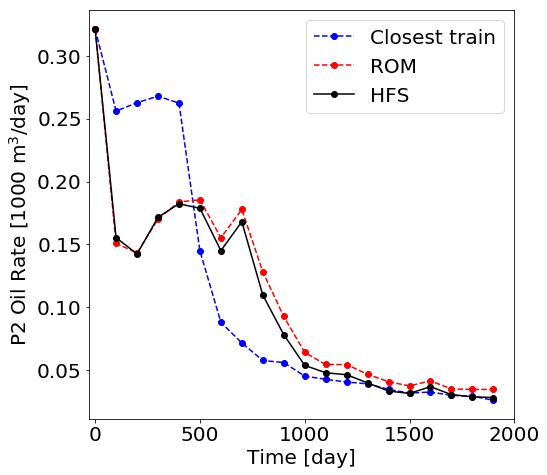

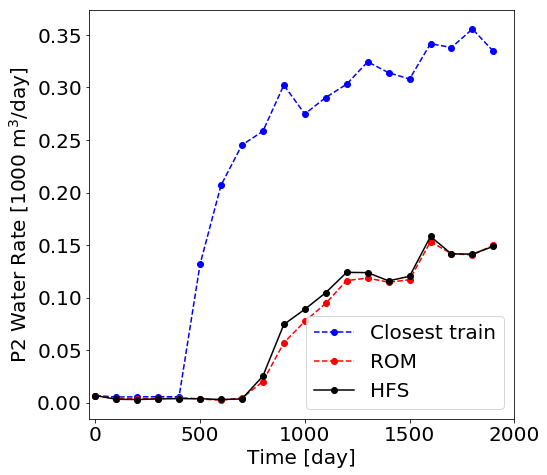

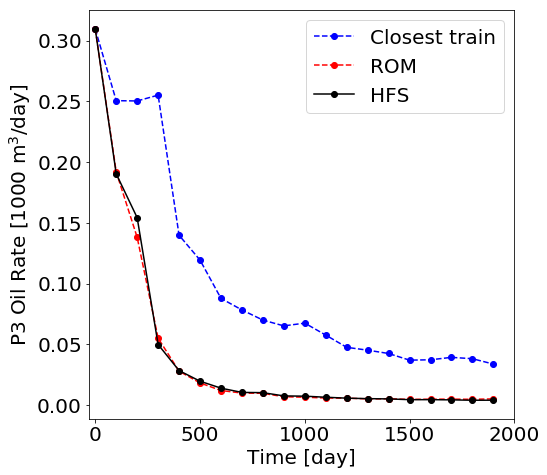

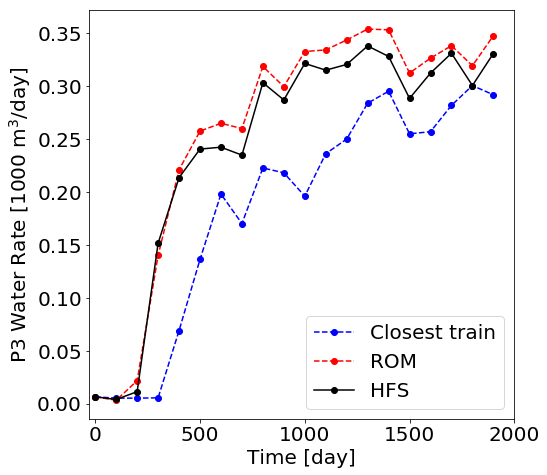

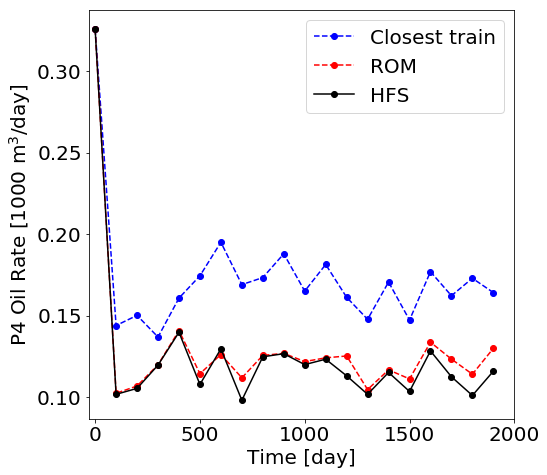

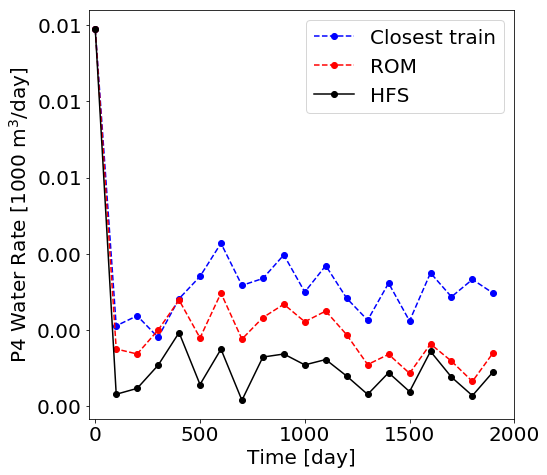

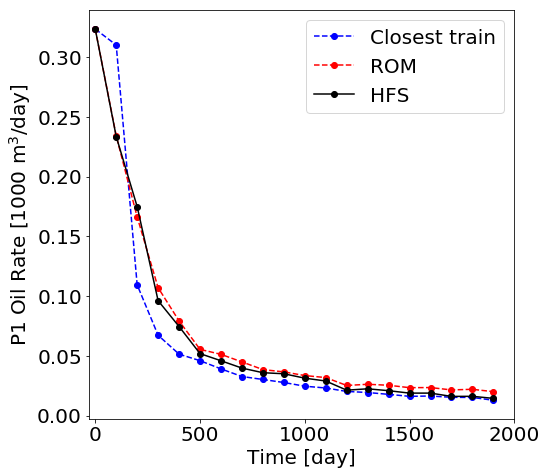

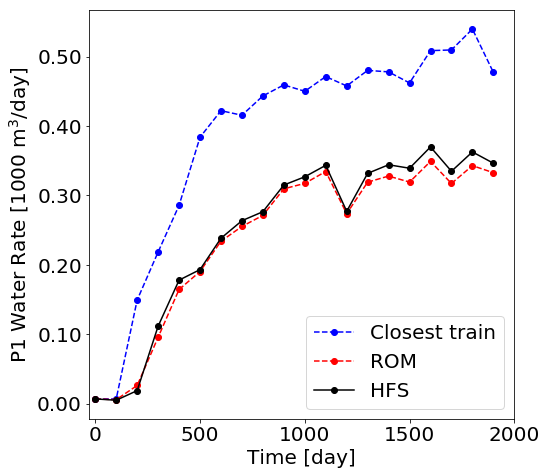

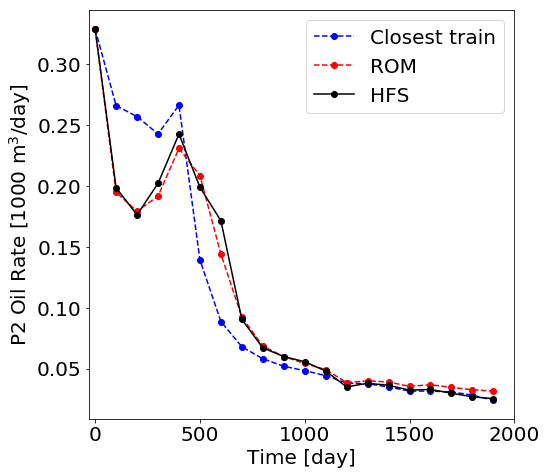

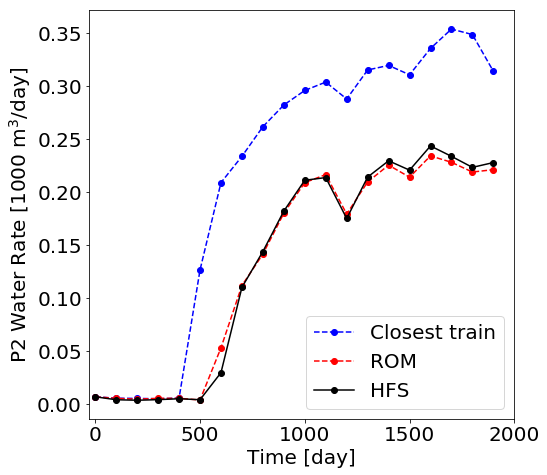

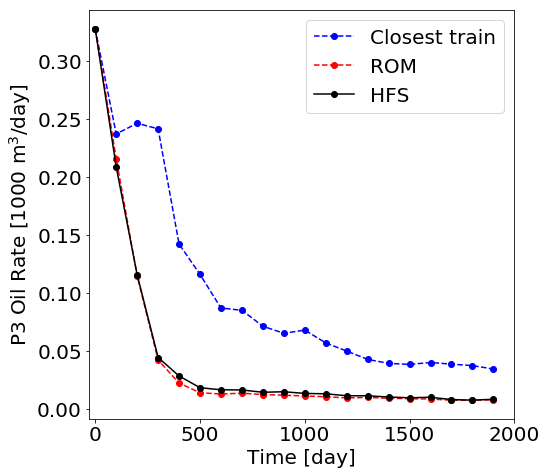

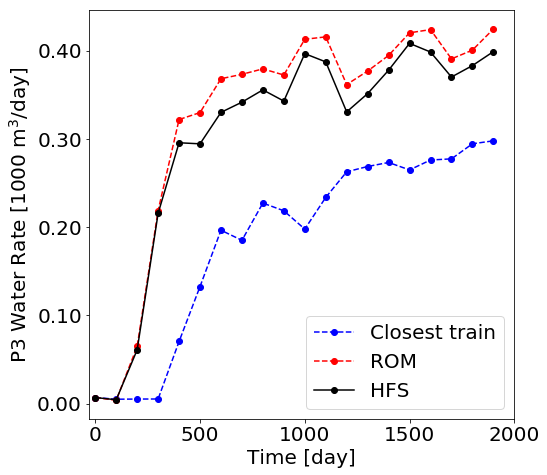

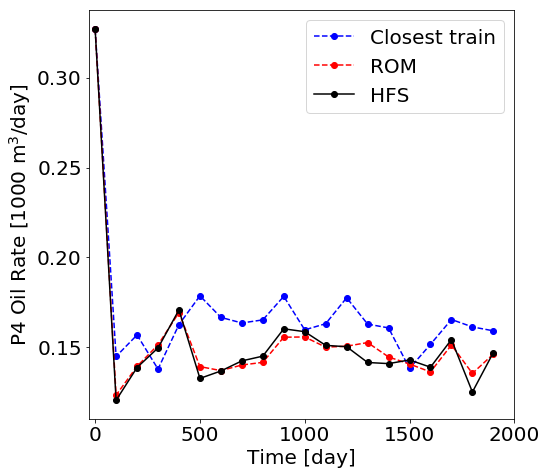

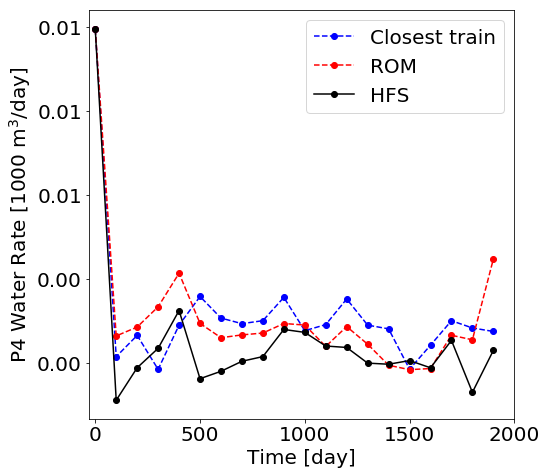

In [39]:
from matplotlib.ticker import FormatStrFormatter
for k in range(num_case): # num_case
    print('Evaluation Case %d' % (k+1))
#     plt.figure(k, figsize=(20,10))
    for i in range(num_prod): # num_prod
        prodx = prod_loc[i, 0]
        prody = prod_loc[i, 1]
        perm = np.exp(get_logk(logk, prodx, prody))
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        pres_true = state_true[ind_case[k], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_pred = state_pred[ind_case[k], :, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_train = state_train[close_train[ind_case[k]], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        bhp = ctrl[ind_case[k], :, i+num_well] * p_diff + p_min
        
        wrat_true = np.zeros_like(bhp)
        wrat_pred = np.zeros_like(bhp)
        orat_true = np.zeros_like(bhp)
        orat_pred = np.zeros_like(bhp)
        wrat_train = np.zeros_like(bhp)
        orat_train = np.zeros_like(bhp)
        
        for j in range(len(bhp)):
            wrat_true[j], orat_true[j] = cal_prod_rate(pres_true[[j]], sat_true[[j]], bhp[j], perm)
            wrat_pred[j], orat_pred[j] = cal_prod_rate(pres_pred[[j]], sat_pred[[j]], bhp[j], perm)
            wrat_train[j], orat_train[j] = cal_prod_rate(pres_train[[j]], sat_train[[j]], bhp[j], perm)
        
        bbl2m3 = 6.2898 * 1000
        
#         plt.figure(figsize=(8,7))
        fig1, ax1 = plt.subplots()
        fig1.set_figheight(7)
        fig1.set_figwidth(8)
#         plt.subplot(121)
        plt.plot(t_steps*10, orat_train/bbl2m3, 'bo--')
        plt.plot(t_steps*10, orat_pred/bbl2m3, 'ro--')
        plt.plot(t_steps*10, orat_true/bbl2m3, 'ko-')
        plt.xlabel('Time [day]')
        plt.ylabel(r'P%d Oil Rate [1000 m$^{3}$/day]' % (i+1))
        plt.xlim([-30, 2000])
        plt.legend(['Closest train', 'ROM', 'HFS'])
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        plt.tight_layout()
        plt.savefig('figs/'+ 'rate_eval_%d_p%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d_oil.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'rate_eval_%d_p%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d_oil.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        
        
#         plt.figure(figsize=(8,7))
        fig2, ax2 = plt.subplots()
        fig2.set_figheight(7)
        fig2.set_figwidth(8)
#         plt.subplot(122)
        plt.plot(t_steps*10, wrat_train/bbl2m3, 'bo--')
        plt.plot(t_steps*10, wrat_pred/bbl2m3, 'ro--')
        plt.plot(t_steps*10, wrat_true/bbl2m3, 'ko-')
        plt.xlabel('Time [day]')
        plt.ylabel(r'P%d Water Rate [1000 m$^{3}$/day]' % (i+1))
        plt.xlim([-30, 2000])
        plt.legend(['Closest train', 'ROM', 'HFS'])
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        plt.tight_layout()
        plt.savefig('figs/'+ 'rate_eval_%d_p%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d_water.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'rate_eval_%d_p%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d_water.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)
        


Evaluation Case 1
Evaluation Case 2
Evaluation Case 3
Evaluation Case 4


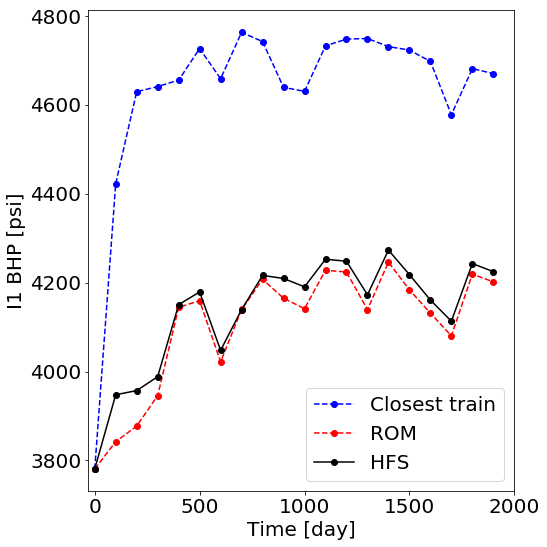

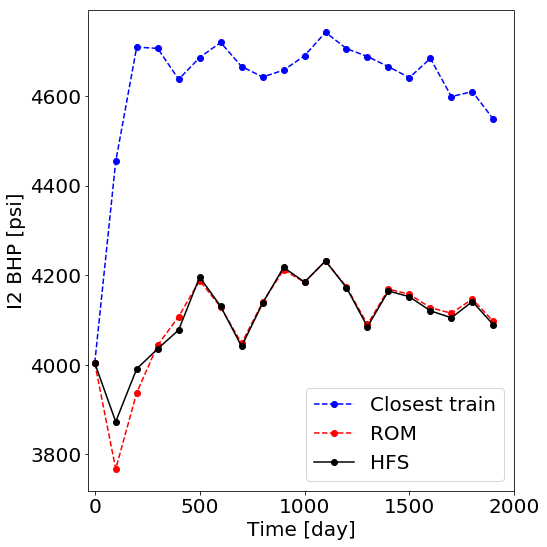

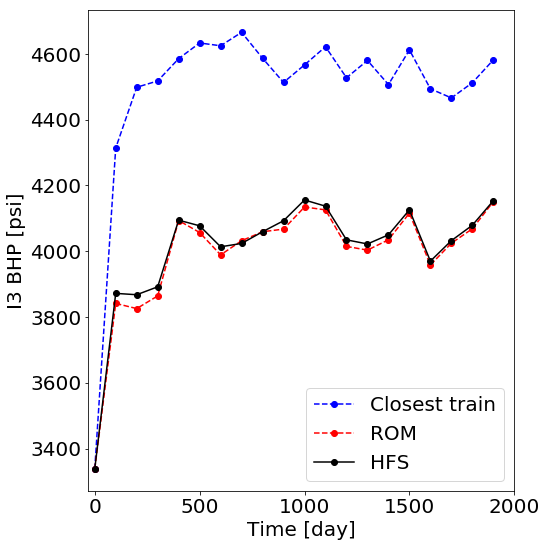

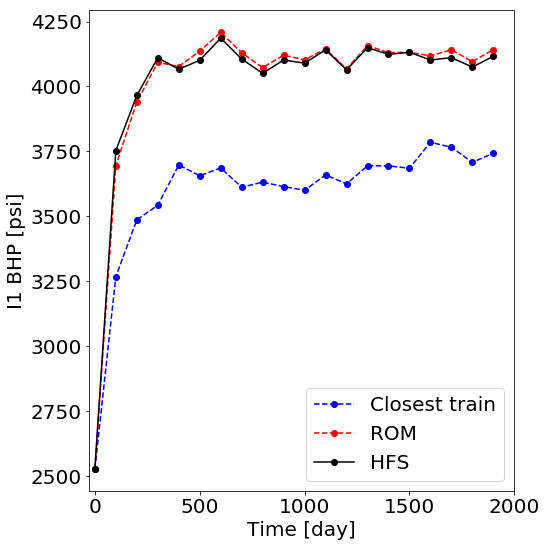

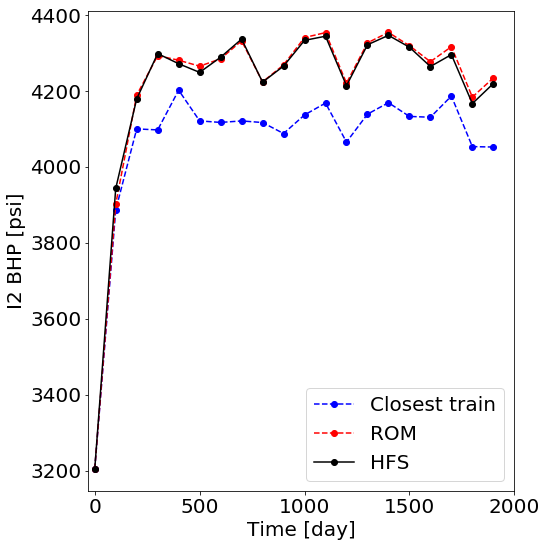

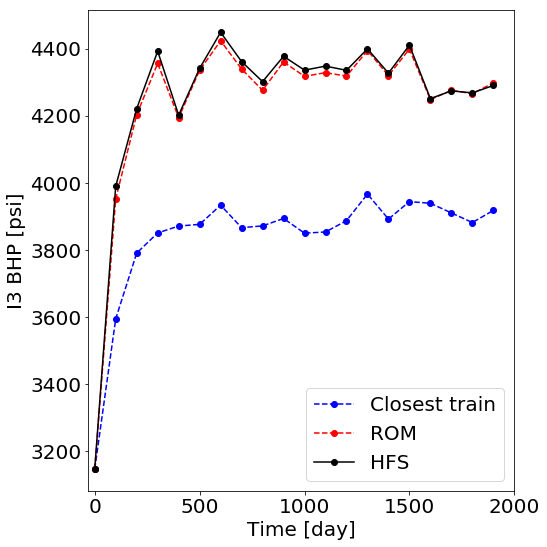

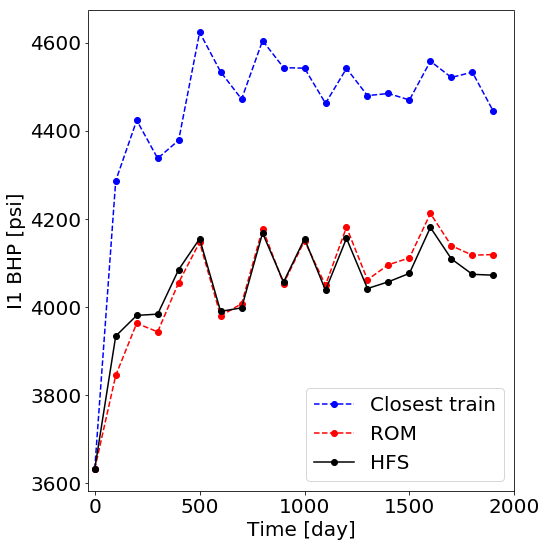

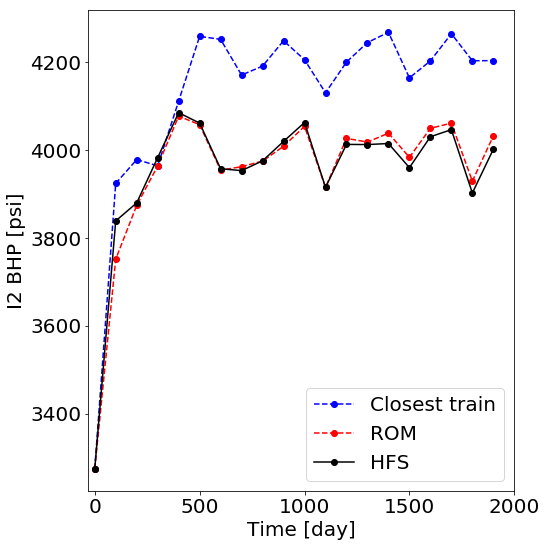

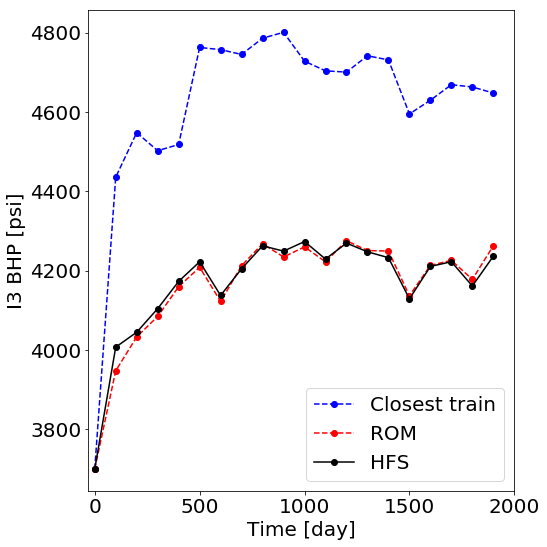

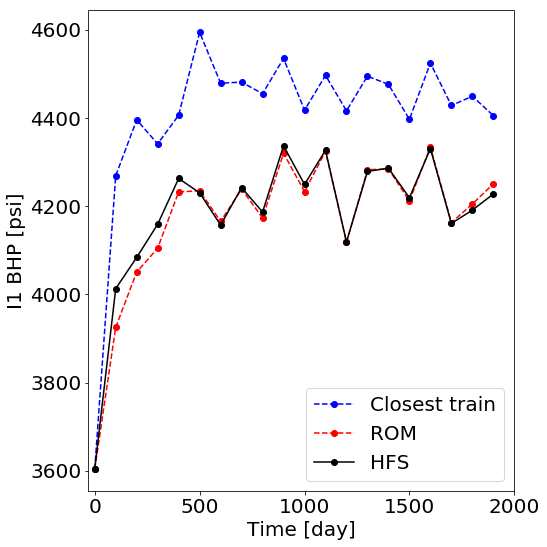

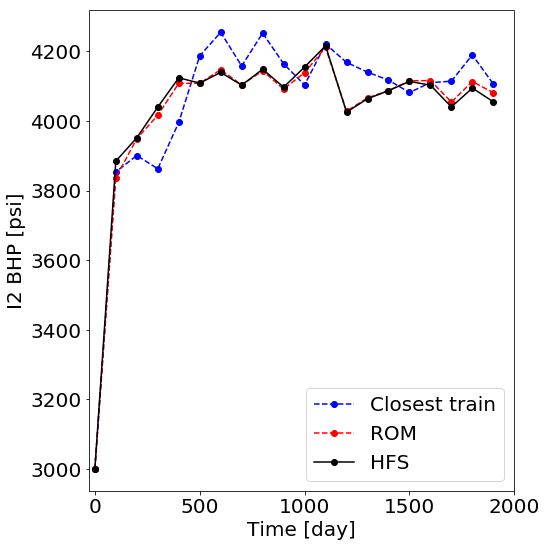

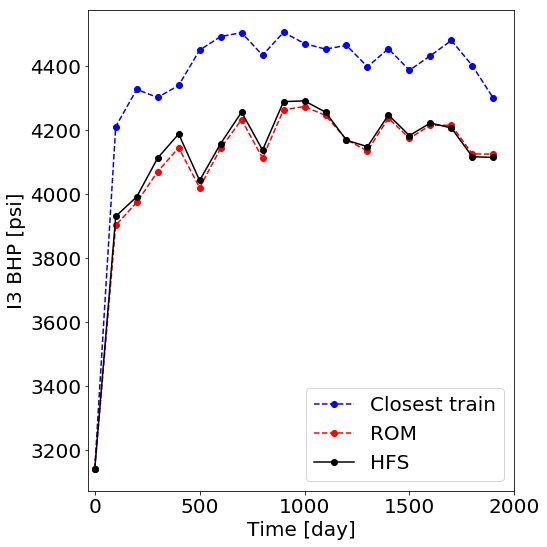

In [40]:
for k in range(num_case):
    print('Evaluation Case %d' % (k+1))
#     plt.figure(k, figsize=(16,4))
    for i in range(num_inj):
        injx = inj_loc[i, 0]
        injy = inj_loc[i, 1]
        perm = np.exp(get_logk(logk, injx, injy))
        sat_true = state_true[ind_case[k], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_pred = state_pred[ind_case[k], :, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_train = state_train[close_train[ind_case[k]], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        pres_true = state_true[ind_case[k], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_pred = state_pred[ind_case[k], :, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_train = state_train[close_train[ind_case[k]], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        inj_rate = ctrl[ind_case[k], :, i+num_prod+num_well] * q_diff + q_min
        
        inj_bhp_pred = np.zeros_like(inj_rate)
        inj_bhp_true = np.zeros_like(inj_rate)
        inj_bhp_train = np.zeros_like(inj_rate)
        
        for j in range(len(bhp)):
            inj_bhp_pred[j] = cal_inj_bhp(pres_pred[[j]], sat_pred[[j]], inj_rate[j], perm)
            inj_bhp_true[j] = cal_inj_bhp(pres_true[[j]], sat_true[[j]], inj_rate[j], perm)
            inj_bhp_train[j] = cal_inj_bhp(pres_train[[j]], sat_train[[j]], inj_rate[j], perm)
       
        
        plt.figure(figsize=(8,8))
        
        plt.plot(t_steps*10, inj_bhp_train, 'bo--')
        plt.plot(t_steps*10, inj_bhp_pred, 'ro--')
        plt.plot(t_steps*10, inj_bhp_true, 'ko-')
        
        plt.xlabel('Time [day]')
        plt.ylabel('I%d BHP [psi]' % (i+1))
        
        plt.xlim([-30, 2000])
        plt.legend(['Closest train', 'ROM', 'HFS'])
        plt.tight_layout()
        
        plt.savefig('figs/'+ 'inj_bhp_eval_%d_I%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='eps', pad_inches=0.1)
        plt.savefig('figs/'+ 'inj_bhp_eval_%d_I%d_'%(ind_case[k],i+1) + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
                orientation='landscape', format='pdf', pad_inches=0.1)

## Err. analysis oil/water production rates

In [42]:
### Calculate oil/water production rates
###
bbl2m3 = 6.2898 * 1000
wrat_true        = np.zeros((num_eval, num_step, num_prod))
wrat_pred        = np.zeros((num_eval, num_step, num_prod))
wrat_close_train = np.zeros((num_eval, num_step, num_prod))
orat_true        = np.zeros((num_eval, num_step, num_prod))
orat_pred        = np.zeros((num_eval, num_step, num_prod))
orat_close_train = np.zeros((num_eval, num_step, num_prod))

for k in range(num_eval):
    for i in range(num_prod):
        prodx = prod_loc[i, 0]
        prody = prod_loc[i, 1]
        perm = np.exp(get_logk(logk, prodx, prody))
        sat_true = state_true[k, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_pred = state_pred[k, :, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_close_train = state_train[close_train[k], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        pres_true = state_true[k, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_pred = state_pred[k, :, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_close_train = state_train[close_train[k], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        
        bhp = ctrl[k, :, i+num_well] * p_diff + p_min

        for j in range(len(bhp)):
            wrat_true[k,j,i], orat_true[k,j,i] = cal_prod_rate(pres_true[[j]], sat_true[[j]], bhp[j], perm)
            wrat_pred[k,j,i], orat_pred[k,j,i] = cal_prod_rate(pres_pred[[j]], sat_pred[[j]], bhp[j], perm)
            wrat_close_train[k,j,i], orat_close_train[k,j,i] = cal_prod_rate(pres_close_train[[j]], sat_close_train[[j]], bhp[j], perm)

wrat_true        /= bbl2m3
wrat_pred        /= bbl2m3
wrat_close_train /= bbl2m3
orat_true        /= bbl2m3
orat_pred        /= bbl2m3
orat_close_train /= bbl2m3

In [43]:
print(wrat_true.shape)
print(wrat_pred.shape)
print(wrat_close_train.shape)
print(orat_true.shape)
print(orat_pred.shape)
print(orat_close_train.shape)

(100, 20, 4)
(100, 20, 4)
(100, 20, 4)
(100, 20, 4)
(100, 20, 4)
(100, 20, 4)


Evaluation Case 1
err_o[0] 0.1886135204855604
base_o[0] 3.4907149208868518
oil error rate[0] 0.054032920121028165
err_w[0] 0.19629369231590432
base_w[0] 2.7290179407260338
water error rate[0] 0.07192832607897108
err_o[0] 0.17951970924770977
base_o[0] 3.100921509669374
oil error rate[0] 0.057892374472532364
err_w[0] 0.1946084364570867
base_w[0] 2.4829673147070714
water error rate[0] 0.07837736538229287
err_o[0] 0.18080760941075474
base_o[0] 3.3328309017411515
oil error rate[0] 0.054250459966719726
err_w[0] 0.0488588351690082
base_w[0] 0.20735516690556974
water error rate[0] 0.23562873256618044
err_o[0] 0.14365407245669173
base_o[0] 2.083265639225628
oil error rate[0] 0.06895619538470835
err_w[0] 0.19323433086394215
base_w[0] 1.3772028146764632
water error rate[0] 0.14030927674900037
err_o[0] 0.10699597431531344
base_o[0] 1.5724894762319053
oil error rate[0] 0.06804241041517409
err_w[0] 0.11616599286477619
base_w[0] 1.9131471854915136
water error rate[0] 0.06071984097498048


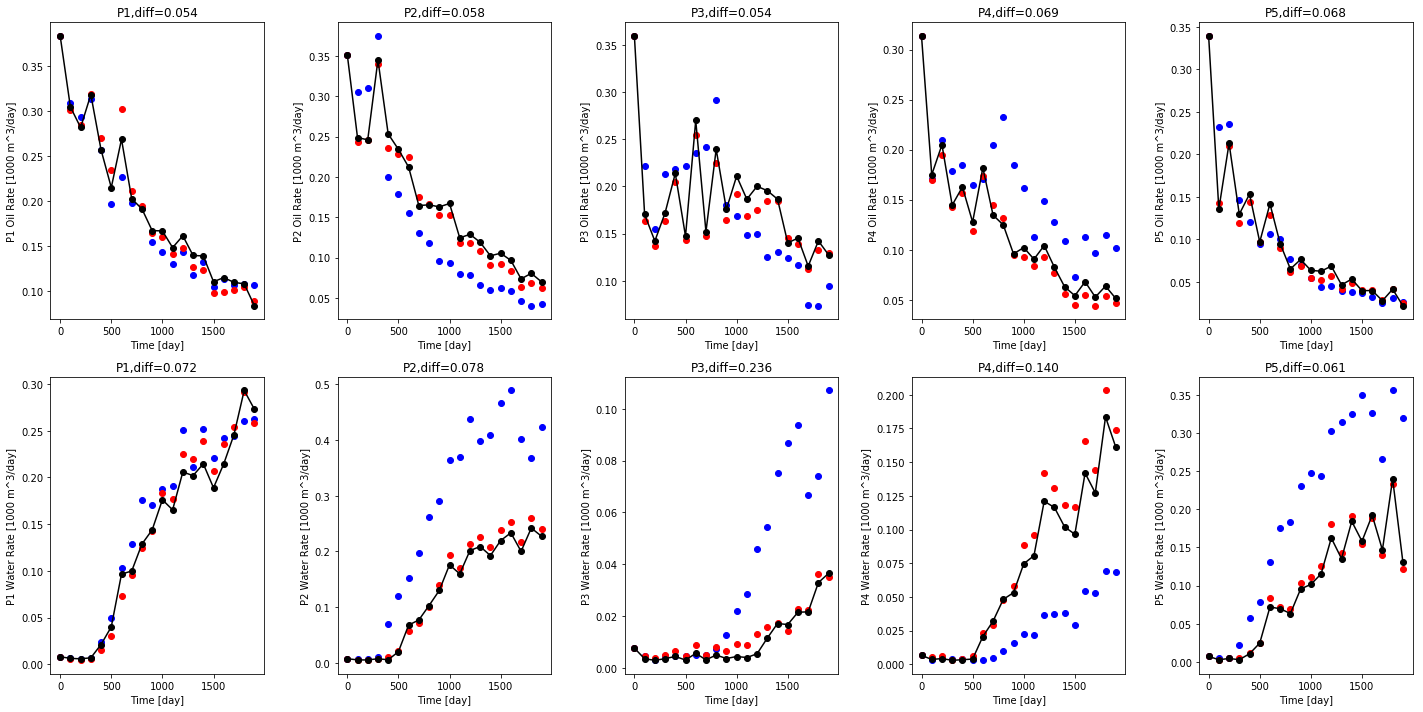

Evaluation Case 2
err_o[1] 0.23144771381501467
base_o[1] 3.875119849491616
oil error rate[1] 0.059726594996895054
err_w[1] 0.3755795025106445
base_w[1] 4.598121725530188
water error rate[1] 0.08168106999545302
err_o[1] 0.16078758859405293
base_o[1] 3.017754047473623
oil error rate[1] 0.05328054774001867
err_w[1] 0.4003634032423815
base_w[1] 6.268608293453048
water error rate[1] 0.06386798863481742
err_o[1] 0.14086433744864302
base_o[1] 3.846749831899987
oil error rate[1] 0.036619053383845156
err_w[1] 0.06546426767070161
base_w[1] 1.0459080576622997
water error rate[1] 0.06259084361298473
err_o[1] 0.2544706492263954
base_o[1] 2.854997778223443
oil error rate[1] 0.0891316452739038
err_w[1] 0.319040934286861
base_w[1] 1.5386061850373427
water error rate[1] 0.2073571115139627
err_o[1] 0.17462065991017228
base_o[1] 1.6536913351503555
oil error rate[1] 0.10559446989803305
err_w[1] 0.3709133119378949
base_w[1] 4.918284025843737
water error rate[1] 0.07541518748996288


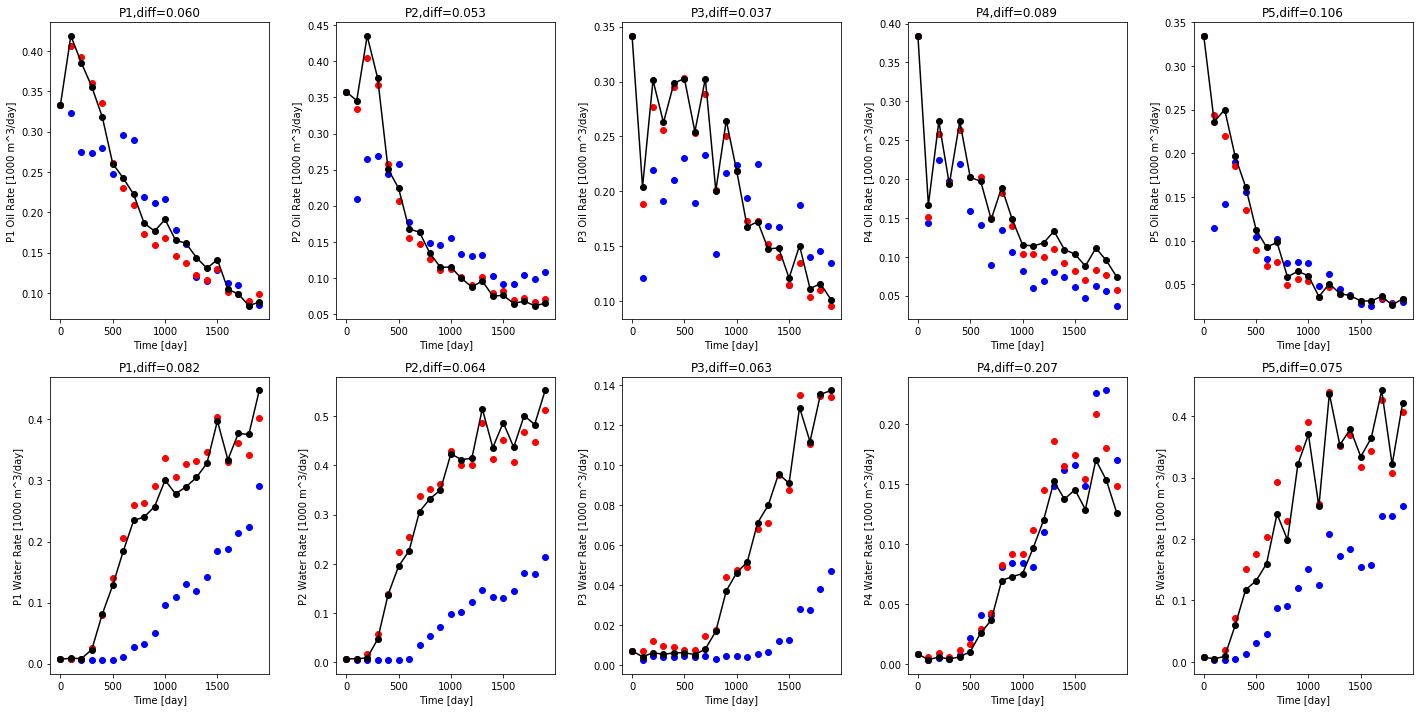

Evaluation Case 3
err_o[2] 0.18455230805393724
base_o[2] 4.010852215766578
oil error rate[2] 0.04601324060968038
err_w[2] 0.2537850879272344
base_w[2] 2.28555155867707
water error rate[2] 0.11103888116797991
err_o[2] 0.18247035680370988
base_o[2] 3.1746482676877963
oil error rate[2] 0.05747734596645858
err_w[2] 0.16301711168369779
base_w[2] 2.293814122613654
water error rate[2] 0.07106814369856186
err_o[2] 0.2739112793735259
base_o[2] 3.351189573054891
oil error rate[2] 0.08173553700927541
err_w[2] 0.21991685235811498
base_w[2] 0.5491187137348799
water error rate[2] 0.4004905439523831
err_o[2] 0.21450950565288862
base_o[2] 2.5511772476924133
oil error rate[2] 0.08408255672823847
err_w[2] 0.2934763735735632
base_w[2] 1.642950583904218
water error rate[2] 0.17862763277770777
err_o[2] 0.1419730645720838
base_o[2] 1.3722218537531001
oil error rate[2] 0.10346218010140261
err_w[2] 0.37298179999257064
base_w[2] 4.353062738526259
water error rate[2] 0.08568261529785454


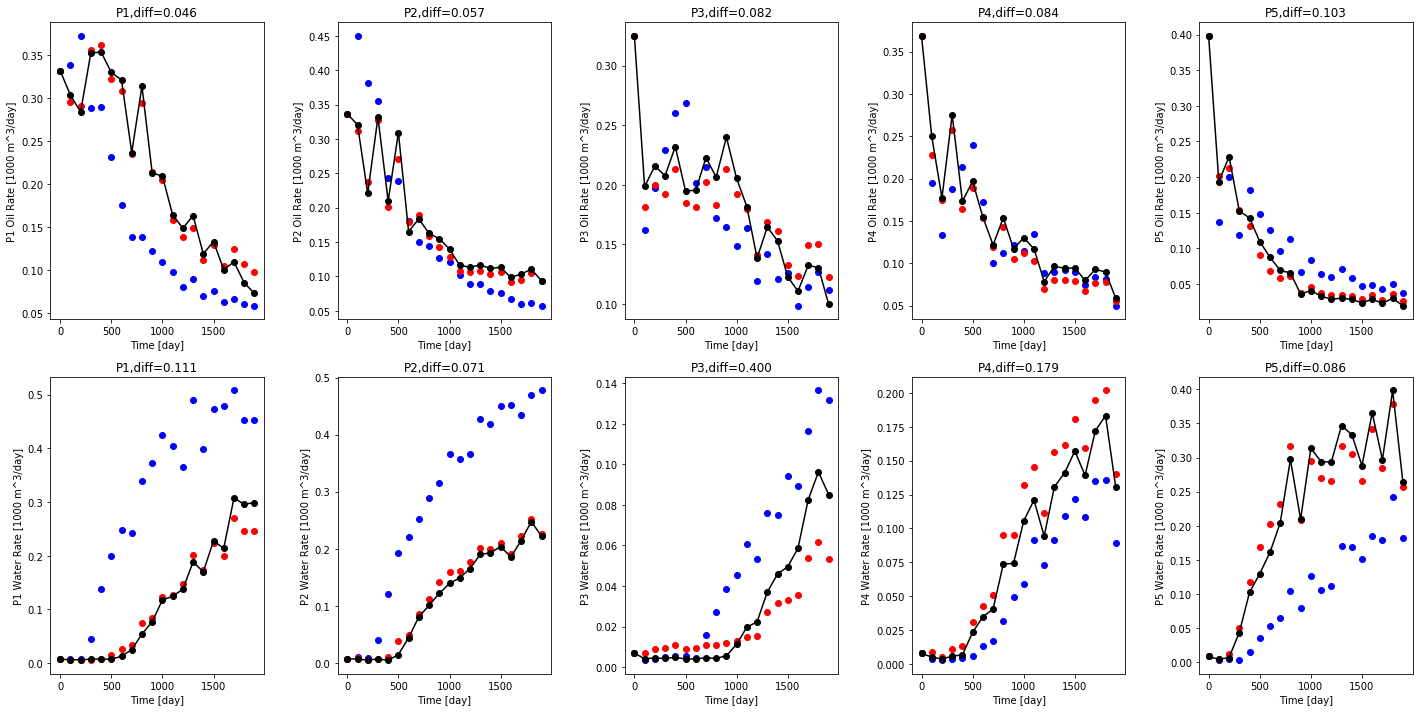

Evaluation Case 4
err_o[3] 0.18917218242499623
base_o[3] 3.7702442015194655
oil error rate[3] 0.05017504763982051
err_w[3] 0.21712800619427777
base_w[3] 1.940378428495222
water error rate[3] 0.111899824799981
err_o[3] 0.1559321883768303
base_o[3] 2.581948965501209
oil error rate[3] 0.06039321088848891
err_w[3] 0.30431539001895164
base_w[3] 3.6685065737820572
water error rate[3] 0.08295348090523301
err_o[3] 0.17738798349214052
base_o[3] 3.2120760336693617
oil error rate[3] 0.05522533764230319
err_w[3] 0.05377942035691357
base_w[3] 0.3035306767680903
water error rate[3] 0.17717952244412916
err_o[3] 0.18150045875392895
base_o[3] 1.9994802964906975
oil error rate[3] 0.09077381711261759
err_w[3] 0.27815643970611414
base_w[3] 1.4230136814726366
water error rate[3] 0.1954699686500961
err_o[3] 0.13287243078238392
base_o[3] 1.617192936503793
oil error rate[3] 0.08216238630725202
err_w[3] 0.20569358830686274
base_w[3] 1.9541856220342007
water error rate[3] 0.10525795809138486


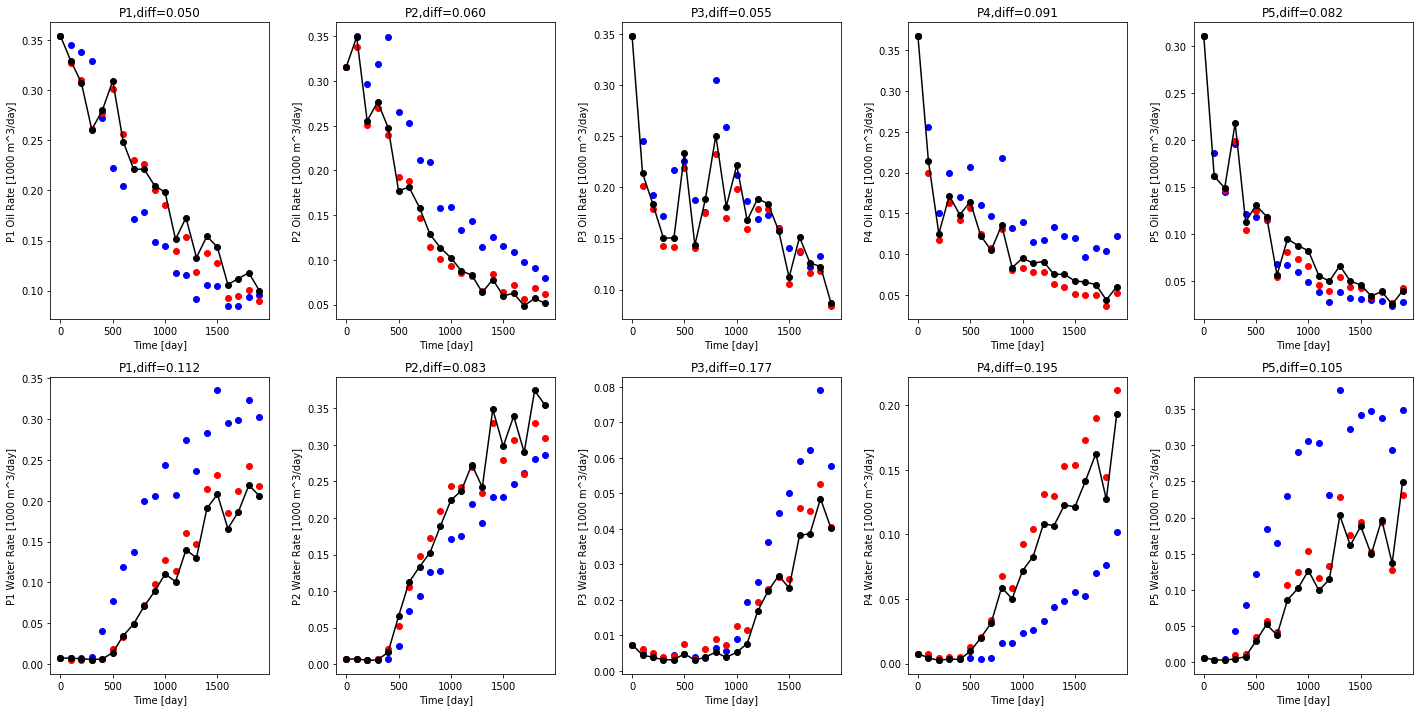

In [39]:
for k in range(num_case):
    print('Evaluation Case %d' % (k+1))
    plt.figure(k, figsize=(20,10))
    for i in range(num_prod):
        err_o = np.sum(np.fabs(orat_pred[ind_case[k],1:,i] - orat_true[ind_case[k],1:,i]))
        base_o = np.sum(np.fabs(orat_true[ind_case[k],1:,i]))
        print("err_o[%d]"%(k), err_o)
        print("base_o[%d]"%(k), base_o)
        print("oil error rate[%d]"%(k), err_o / base_o)
        
        plt.subplot(2, num_prod, i+1)
        plt.plot(t_steps*10, orat_close_train[ind_case[k],:,i], 'bo')
        plt.plot(t_steps*10, orat_pred[ind_case[k],:,i], 'ro')
        plt.plot(t_steps*10, orat_true[ind_case[k],:,i], 'ko-')
#         plt.ylim([0, 60])
        plt.xlabel('Time [day]')
        plt.ylabel('P%d Oil Rate [1000 m^3/day]' % (i+1))
#         plt.title('P%d,diff=%.3f'%(i+1, np.linalg.norm(orat_true - orat_pred)/bbl2m3))
        plt.title('P%d,diff=%.3f'%(i+1, err_o / base_o))
        
        err_w = np.sum(np.fabs(wrat_pred[ind_case[k],1:,i] - wrat_true[ind_case[k],1:,i]))
        base_w = np.sum(np.fabs(wrat_true[ind_case[k],1:,i]))
        print("err_w[%d]"%(k), err_w)
        print("base_w[%d]"%(k), base_w)
        print("water error rate[%d]"%(k), err_w / base_w)
        
        plt.subplot(2, num_prod, i+num_prod+1)
        plt.plot(t_steps*10, wrat_close_train[ind_case[k],:,i], 'bo')
        plt.plot(t_steps*10, wrat_pred[ind_case[k],:,i], 'ro')
        plt.plot(t_steps*10, wrat_true[ind_case[k],:,i], 'ko-')
#         plt.ylim([0, 60])
        plt.xlabel('Time [day]')
        plt.ylabel('P%d Water Rate [1000 m^3/day]' % (i+1))
#         plt.title('P%d,diff=%.3f'%(i+1, np.linalg.norm(wrat_true - wrat_pred)/bbl2m3))
        plt.title('P%d,diff=%.3f'%(i+1, err_w / base_w))
    plt.tight_layout()
    plt.show()
        


[0.00669022 0.0056768  0.00633852 0.00325284 0.0042572  0.00647894
 0.02314436 0.029081   0.04766    0.058021   0.08860024 0.09600024
 0.141846   0.13098484 0.11791591 0.11682046 0.16560248 0.14431616
 0.20313431 0.17415955]
[0.00669022 0.00366506 0.004279   0.00300977 0.00343846 0.0039423
 0.02062526 0.03207406 0.04824009 0.05317067 0.07458713 0.08063376
 0.12096726 0.11639871 0.1019321  0.09651546 0.1418779  0.1271763
 0.18350226 0.16116725]


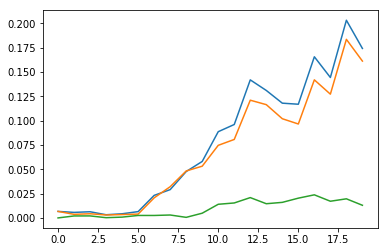

In [38]:
print(wrat_pred[10,:,3])
print(wrat_true[10,:,3])
plt.figure()
plt.plot(np.arange(20), wrat_pred[10,:,3])
plt.plot(np.arange(20), wrat_true[10,:,3])
plt.plot(np.arange(20), np.fabs(wrat_true[10,:,3] - wrat_pred[10,:,3]))

In [37]:
rates_true = np.concatenate((wrat_true[...,np.newaxis], orat_true[...,np.newaxis]),axis=3)
rates_pred = np.concatenate((wrat_pred[...,np.newaxis], orat_pred[...,np.newaxis]),axis=3)
rates_close_train = np.concatenate((wrat_close_train[...,np.newaxis], orat_close_train[...,np.newaxis]),axis=3)
print(rates_true.shape)
print(rates_pred.shape)
print(rates_close_train.shape)

(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 20, 5, 2)


In [38]:
epsilon = 1e-3
rates_diff_true_pred = np.fabs(rates_true - rates_pred)
rates_diff_true_close_train = np.fabs(rates_true - rates_close_train)
rates_true_abs = np.fabs(rates_true)

print(rates_diff_true_pred.shape)
print(rates_diff_true_close_train.shape)
print(rates_true_abs.shape)

rates_rel_err_true_pred_per_well_0 = np.sum(np.sum(rates_diff_true_pred, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon), axis=2)
rates_rel_err_true_close_train_per_well_0 = np.sum(np.sum(rates_diff_true_close_train, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon), axis=2)
#
rates_rel_err_true_pred_per_well_1 = np.sum(rates_diff_true_pred, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon)
rates_rel_err_true_close_train_per_well_1 = np.sum(rates_diff_true_close_train, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon)
#
# rates_rel_err_true_pred_per_well_2 = np.sum(rates_diff_true_pred / (rates_true_abs  + epsilon), axis=(1,3))
# rates_rel_err_true_close_train_per_well_2 = np.sum(rates_diff_true_close_train / (rates_true_abs  + epsilon), axis=(1,3))
#

rates_rel_err_true_pred_per_well = np.sum(rates_diff_true_pred, axis=(1,3)) / (np.sum(rates_true_abs, axis=(1,3)) + epsilon)
rates_rel_err_true_close_train_per_well = np.sum(rates_diff_true_close_train, axis=(1,3)) / (np.sum(rates_true_abs, axis=(1,3)) + epsilon)

print(rates_rel_err_true_pred_per_well.shape)
print(rates_rel_err_true_close_train_per_well.shape)

print(rates_rel_err_true_pred_per_well_0.shape)
print(rates_rel_err_true_close_train_per_well_0.shape)

print(rates_rel_err_true_pred_per_well_1.shape)
print(rates_rel_err_true_close_train_per_well_1.shape)

rates_rel_err_true_pred = np.mean(rates_rel_err_true_pred_per_well_0[:,:3], axis=1)
rates_rel_err_true_close_train = np.mean(rates_rel_err_true_close_train_per_well_0[:,:3], axis=1)
print(rates_rel_err_true_pred.shape)
print(rates_rel_err_true_close_train.shape)

(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 5)
(100, 5)
(100, 5)
(100, 5)
(100, 5, 2)
(100, 5, 2)
(100,)
(100,)


In [39]:
rates_rel_err_true_pred_aaa = np.mean(rates_rel_err_true_pred_per_well_0, axis=0)
rates_rel_err_true_close_train_aaa = np.mean(rates_rel_err_true_close_train_per_well_0, axis=0)
print(rates_rel_err_true_pred_aaa)
print(rates_rel_err_true_close_train_aaa)

[0.61398605 0.5844821  0.77105721 0.62242247 0.83931056]
[0.96345789 1.02536428 1.44720106 1.24916518 1.01210626]


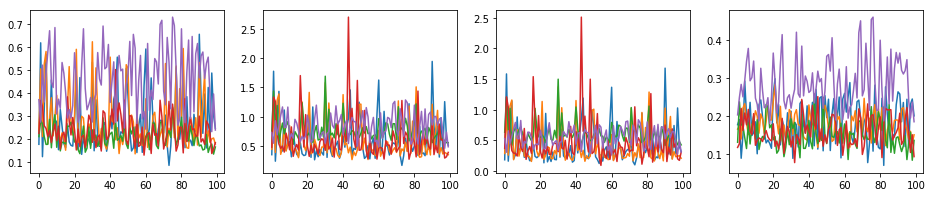

In [40]:
plt.figure(figsize=(16,3))
plt.subplot(141)
for i in range(5):
    plt.plot(np.arange(100), rates_rel_err_true_pred_per_well[:,i])
plt.subplot(142)
for i in range(5):
    plt.plot(np.arange(100), rates_rel_err_true_pred_per_well_0[:,i])
plt.subplot(143)
for i in range(5):
    plt.plot(np.arange(100), rates_rel_err_true_pred_per_well_1[:,i,0])
plt.subplot(144)
for i in range(5):
    plt.plot(np.arange(100), rates_rel_err_true_pred_per_well_1[:,i,1])


In [41]:
print(np.mean(rates_rel_err_true_pred))

0.6565084525352749


(0, 3)

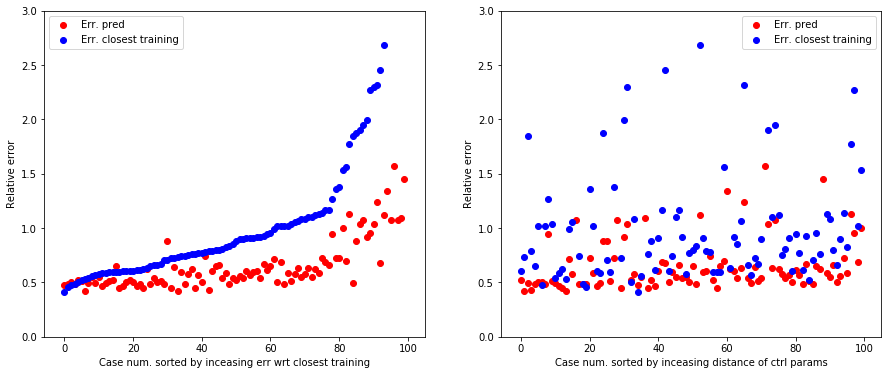

In [42]:
sort_idx_tr_err = np.argsort(rates_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(np.arange(100), rates_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(100), rates_rel_err_true_close_train[sort_idx_tr_err], c='b')
plt.ylabel('Relative error')
plt.xlabel('Case num. sorted by inceasing err wrt closest training')
plt.legend(['Err. pred', 'Err. closest training'])
plt.ylim([0, 3])

plt.subplot(122)
plt.scatter(np.arange(100), rates_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
plt.scatter(np.arange(100), rates_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
plt.ylabel('Relative error')
plt.legend(['Err. pred', 'Err. closest training'])
plt.ylim([0, 3])

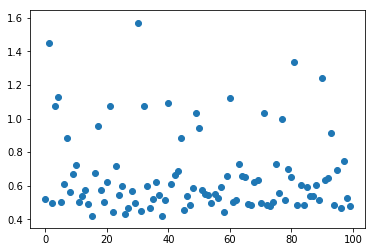

In [43]:
plt.figure()
plt.scatter(np.arange(100), rates_rel_err_true_pred)

## Err. analysis injection BHP

In [44]:
inj_bhp_pred        = np.zeros((num_eval, num_step, num_inj))
inj_bhp_true        = np.zeros((num_eval, num_step, num_inj))
inj_bhp_close_train = np.zeros((num_eval, num_step, num_inj))

for k in range(num_eval):
    for i in range(num_inj):
        injx = inj_loc[i, 0]
        injy = inj_loc[i, 1]
        perm = np.exp(get_logk(logk, injx, injy))
        sat_true = state_true[k, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_pred = state_pred[k, :, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_train = state_train[close_train[k], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        pres_true = state_true[k, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_pred = state_pred[k, :, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_train = state_train[close_train[k], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        inj_rate = ctrl[k, :, i+num_prod+num_well] * q_diff + q_min
        
        for j in range(len(bhp)):
            inj_bhp_pred[k,j,i] = cal_inj_bhp(pres_pred[[j]], sat_pred[[j]], inj_rate[j], perm)
            inj_bhp_true[k,j,i] = cal_inj_bhp(pres_true[[j]], sat_true[[j]], inj_rate[j], perm)
            inj_bhp_close_train[k,j,i] = cal_inj_bhp(pres_train[[j]], sat_train[[j]], inj_rate[j], perm)
        

In [45]:
print(inj_bhp_pred.shape)
print(inj_bhp_true.shape)
print(inj_bhp_close_train.shape)

(100, 20, 4)
(100, 20, 4)
(100, 20, 4)


In [46]:
epsilon = 1e-3
inj_bhp_diff_true_pred = np.fabs(inj_bhp_true - inj_bhp_pred)
inj_bhp_diff_true_close_train = np.fabs(inj_bhp_true - inj_bhp_close_train)
inj_bhp_true_abs = np.fabs(inj_bhp_true)

print(inj_bhp_diff_true_pred.shape)
print(inj_bhp_diff_true_close_train.shape)
print(inj_bhp_true_abs.shape)

inj_bhp_rel_err_true_pred_per_well = np.sum(inj_bhp_diff_true_pred, axis=1) / (np.sum(inj_bhp_true_abs, axis=1) + epsilon)
inj_bhp_rel_err_true_close_train_per_well = np.sum(inj_bhp_diff_true_close_train, axis=1) / (np.sum(inj_bhp_true_abs, axis=1) + epsilon)

print(inj_bhp_rel_err_true_pred_per_well.shape)
print(inj_bhp_rel_err_true_close_train_per_well.shape)

inj_bhp_rel_err_true_pred = np.mean(inj_bhp_rel_err_true_pred_per_well, axis=1)
inj_bhp_rel_err_true_close_train = np.mean(inj_bhp_rel_err_true_close_train_per_well, axis=1)
print(inj_bhp_rel_err_true_pred.shape)
print(inj_bhp_rel_err_true_close_train.shape)

(100, 20, 4)
(100, 20, 4)
(100, 20, 4)
(100, 4)
(100, 4)
(100,)
(100,)


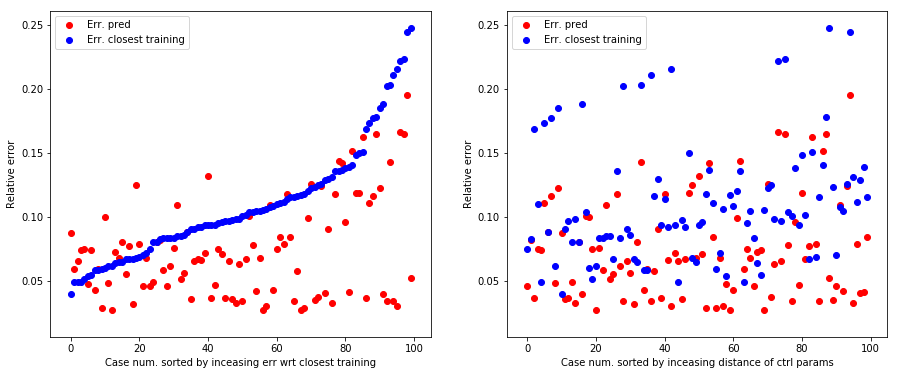

In [47]:
sort_idx_tr_err = np.argsort(inj_bhp_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_close_train[sort_idx_tr_err], c='b')
plt.ylabel('Relative error')
plt.xlabel('Case num. sorted by inceasing err wrt closest training')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

plt.subplot(122)
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
plt.ylabel('Relative error')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

## Err. Analysis Pres/Sat

In [48]:
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(close_train.shape)

(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(100,)


In [49]:
state_pred_0 = state_pred.reshape(num_eval, num_step, 3600, 2)
# state_pred_0[:,:,:,0] = np.clip(state_pred.reshape(num_eval, num_step, 3600, 2)[:,:,:,0], a_min=0.1229, a_max = 1)
print(state_pred_0.shape)
state_close_train = state_train[close_train, ...]
print(state_close_train.shape)

(100, 20, 3600, 2)
(100, 20, 3600, 2)


In [50]:
epsilon = 1e-4
state_diff_true_pred = np.fabs(state_true - state_pred_0)
state_diff_true_close_train = np.fabs(state_true - state_close_train)
state_true_abs = np.fabs(state_true)

print(state_diff_true_pred.shape)
print(state_diff_true_close_train.shape)
print(state_true_abs.shape)

(100, 20, 3600, 2)
(100, 20, 3600, 2)
(100, 20, 3600, 2)


In [51]:
print(ind_case)

[10 25 77 97]


3878.1934825062435
4686.28767694696


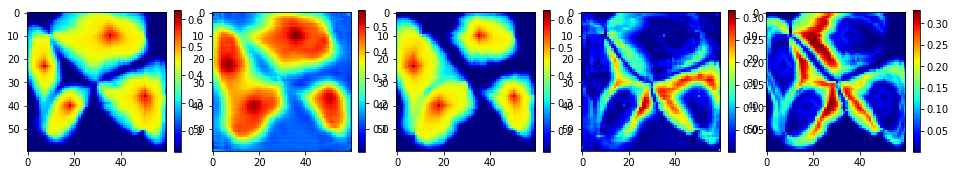

In [52]:
k = 2
plt.figure(figsize=(16,4))
plt.subplot(151)
plt.imshow(state_true[ind_case[k], -1, :, 0].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(152)
plt.imshow(state_pred_0[ind_case[k], -1, :, 0].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(153)
plt.imshow(state_close_train[ind_case[k], -1, :, 0].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(154)
plt.imshow(state_diff_true_pred[ind_case[k], -1, :, 0].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(155)
plt.imshow(state_diff_true_close_train[ind_case[k], -1, :, 0].reshape((60,60)))
plt.colorbar(fraction=0.046) 

print(np.sum(state_diff_true_pred[ind_case[k], :, :, 0]))
print(np.sum(state_diff_true_close_train[ind_case[k], :, :, 0]))
# print(i_tstep)
# print(divide)

3878.1934825062435
21350765.049763717


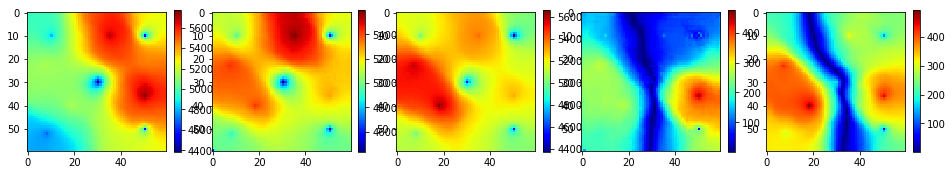

In [53]:
k = 2
plt.figure(figsize=(16,4))
plt.subplot(151)
plt.imshow(state_true[ind_case[k], -1, :, 1].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(152)
plt.imshow(state_pred_0[ind_case[k], -1, :, 1].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(153)
plt.imshow(state_close_train[ind_case[k], -1, :, 1].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(154)
plt.imshow(state_diff_true_pred[ind_case[k], -1, :, 1].reshape((60,60)))
plt.colorbar(fraction=0.046) 
plt.subplot(155)
plt.imshow(state_diff_true_close_train[ind_case[k], -1, :, 1].reshape((60,60)))
plt.colorbar(fraction=0.046) 

print(np.sum(state_diff_true_pred[ind_case[k], :, :, 0]))
print(np.sum(state_diff_true_close_train[ind_case[k], :, :, 1]))
# print(i_tstep)

[70 56 32 23 66 35  3 61 98 15 72 96 40 39  5 38 31 16 14 12 53 27 50 26
 13  1 10 84 87 37 51 83 33 67 44 93 24 47 88 71  7 11 89 36 65 92 78 57
 34 69 79 52 25 58  6 19 60 75 54 29 82 74 81 68 59 63 30 99 20 55 42  2
 97 73 80  9 86  0 21 45 95 49 17 46 91 94 48 43 22 85 64 90 18  8 62 76
 41 28  4 77]


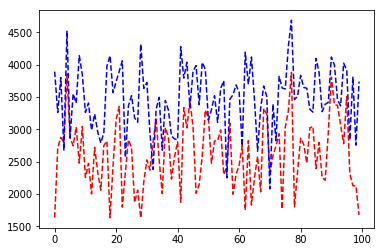

In [54]:
diff_1 = []
diff_2 = []
for i in range(100):
    diff_1.append(np.sum(state_diff_true_pred[i, :, :, 0]))
    diff_2.append(np.sum(state_diff_true_close_train[i, :, :, 0]))

diff_1 = np.array(diff_1)
diff_2 = np.array(diff_2)
plt.figure()
plt.plot(diff_1, 'r--')
plt.plot(diff_2, 'b--')

sort_idx_tr_err = np.argsort(diff_2)
print(sort_idx_tr_err)

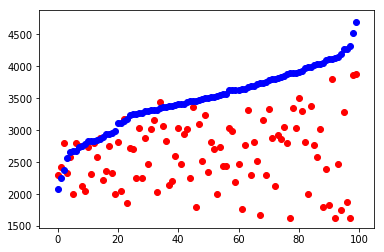

In [55]:
plt.figure()
plt.scatter(np.arange(num_eval), diff_1[[sort_idx_tr_err]], c='r')
plt.scatter(np.arange(num_eval), diff_2[[sort_idx_tr_err]], c='b')

In [56]:
pres_rel_err_true_pred = np.sum(state_diff_true_pred[:,:,:,1], axis=(1,2)) / (np.sum(state_true_abs[:,:,:,1], axis=(1,2)) + epsilon)
pres_rel_err_true_close_train = np.sum(state_diff_true_close_train[:,:,:,1], axis=(1,2)) / (np.sum(state_true_abs[:,:,:,1], axis=(1,2)) + epsilon)

print(pres_rel_err_true_pred.shape)
print(pres_rel_err_true_close_train.shape)

print(pres_rel_err_true_pred)
print(pres_rel_err_true_close_train)

(100,)
(100,)
[0.04074771 0.05694817 0.02805304 0.02943904 0.03651522 0.04169262
 0.07509395 0.02619578 0.02448426 0.08678797 0.01911809 0.01838756
 0.01457729 0.03738064 0.03203428 0.01828883 0.03477035 0.04143594
 0.0331819  0.01587632 0.04949818 0.03167825 0.02064792 0.01839259
 0.02514048 0.07493392 0.03023905 0.01534484 0.04442318 0.02764929
 0.03950196 0.01774493 0.02680224 0.02866691 0.02202921 0.03503108
 0.09046783 0.02504904 0.03539976 0.06376794 0.03344233 0.05920438
 0.03233186 0.03829782 0.02943074 0.02803293 0.05991835 0.04832425
 0.03083088 0.03127721 0.02619142 0.07680312 0.02108987 0.06372753
 0.05486799 0.01896706 0.01860342 0.03676402 0.01622825 0.01800868
 0.03238215 0.0559776  0.03436263 0.02752871 0.05158605 0.06589145
 0.04028411 0.03205633 0.09026464 0.09031378 0.01748734 0.01997564
 0.05897867 0.03040019 0.02919688 0.10755575 0.06234206 0.03909557
 0.01745364 0.03065958 0.07930705 0.02695697 0.02178257 0.03843488
 0.0496144  0.03219135 0.06315147 0.01669417 0.0

In [57]:
sat_rel_err_true_pred = np.sum(state_diff_true_pred[:,:,:,0], axis=(1,2)) / (np.sum(state_true_abs[:,:,:,0], axis=(1,2)) + epsilon)
sat_rel_err_true_close_train = np.sum(state_diff_true_close_train[:,:,:,0], axis=(1,2)) / (np.sum(state_true_abs[:,:,:,0], axis=(1,2)) + epsilon)

print(sat_rel_err_true_pred.shape)
print(sat_rel_err_true_close_train.shape)

(100,)
(100,)


(100,)


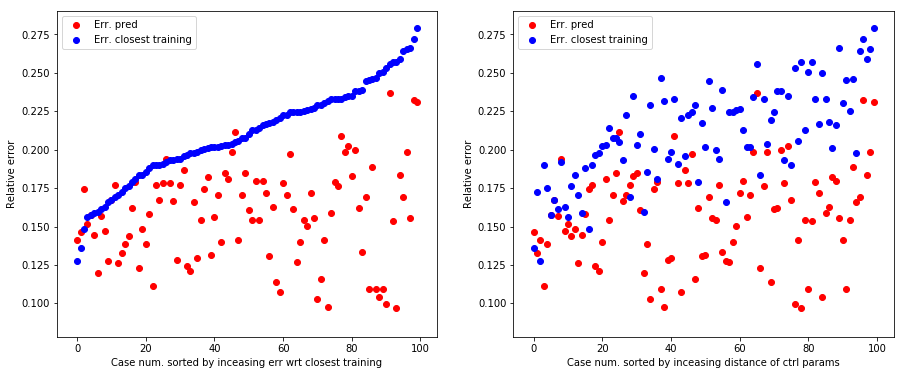

In [58]:
sort_idx_tr_err = np.argsort(sat_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
print(sort_idx_tr_err.shape)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(np.arange(num_eval), sat_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(num_eval), sat_rel_err_true_close_train[sort_idx_tr_err], c='b')
plt.ylabel('Relative error')
plt.xlabel('Case num. sorted by inceasing err wrt closest training')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

plt.subplot(122)
plt.scatter(np.arange(num_eval), sat_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
plt.scatter(np.arange(num_eval), sat_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
plt.ylabel('Relative error')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

(100,)


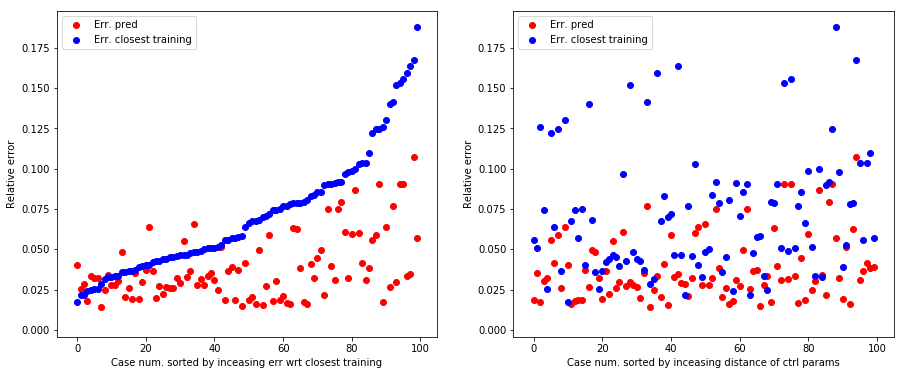

In [59]:
sort_idx_tr_err = np.argsort(pres_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
print(sort_idx_tr_err.shape)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(np.arange(num_eval), pres_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(num_eval), pres_rel_err_true_close_train[sort_idx_tr_err], c='b')
plt.ylabel('Relative error')
plt.xlabel('Case num. sorted by inceasing err wrt closest training')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

plt.subplot(122)
plt.scatter(np.arange(num_eval), pres_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
plt.scatter(np.arange(num_eval), pres_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
plt.ylabel('Relative error')
plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])

In [60]:
output_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_ms_bhp_rate_fix_wl/'

hf_w = h5py.File(output_dir + case_name + target_suffix + '_nt_%d_pred_err.mat'%(nt), 'w')
hf_w.create_dataset('pres_rel_err_true_pred', data=pres_rel_err_true_pred)
hf_w.create_dataset('pres_rel_err_true_close_train', data=pres_rel_err_true_close_train)
hf_w.create_dataset('sat_rel_err_true_pred', data=sat_rel_err_true_pred)
hf_w.create_dataset('sat_rel_err_true_close_train', data=sat_rel_err_true_close_train)
hf_w.create_dataset('inj_bhp_rel_err_true_pred', data=inj_bhp_rel_err_true_pred)
hf_w.create_dataset('inj_bhp_rel_err_true_close_train', data=inj_bhp_rel_err_true_close_train)
hf_w.create_dataset('rates_rel_err_true_pred', data=rates_rel_err_true_pred)
hf_w.create_dataset('rates_rel_err_true_close_train', data=rates_rel_err_true_close_train)
hf_w.create_dataset('sort_idx_tr_err', data=sort_idx_tr_err)
hf_w.create_dataset('sort_idx_ctrl_dist', data=sort_idx_ctrl_dist)
hf_w.close()